In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [4]:
#changed ipsi, contra_key

In [5]:
#msvd.reg_proj_vcount_norm.shape
order = ontological_order

In [6]:
sid = 549

In [7]:
ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)


NameError: name 'key' is not defined

In [88]:
        msvd = msvds[sid]
        nexp = msvd.projections.shape[0]

        minor_structures = np.unique(experiments_minor_structures[sid])
        nmins = len(minor_structures)

        projections = msvd.projections
        ipsi_proj = unionize(projections, ipsi_key)
        contra_proj = unionize(projections, contra_key)
        reg_proj = np.hstack([ipsi_proj, contra_proj])
        msvd.reg_proj = reg_proj

        ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
        contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
        target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
        reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
        msvd.reg_proj_vcount_norm = reg_proj_vcount_norm

        projections = msvds[sid].reg_proj_vcount_norm
        projections = projections / np.expand_dims(np.linalg.norm(projections, axis=1), 1)
        msvd.reg_proj_vcount_norm_renorm = projections

        source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
        source_key = source_mask.get_key(structure_ids=order)
        source_target_counts, source_target_counts = nonzero_unique(source_key, return_counts=True)

        injections = msvd.injections
        reg_ipsi_inj = unionize(injections, source_key)
        msvd.reg_inj = reg_ipsi_inj
        reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_target_counts[np.newaxis, :])
        msvd.reg_inj_vcount_norm = reg_inj_vcount_norm

In [89]:
source_target_counts.shape

(40,)

In [4]:
#order = ontological_order
def get_regionalized_normalized_data(msvds, cache, order, ipsi_key, contra_key, experiments_minor_structures):
    major_structure_ids = np.asarray(list(msvds.keys()))
    for sid in major_structure_ids:
        # print()
        msvd = msvds[sid]
        nexp = msvd.projections.shape[0]

        minor_structures = np.unique(experiments_minor_structures[sid])
        nmins = len(minor_structures)

        projections = msvd.projections
        ipsi_proj = unionize(projections, ipsi_key)
        contra_proj = unionize(projections, contra_key)
        reg_proj = np.hstack([ipsi_proj, contra_proj])
        msvd.reg_proj = reg_proj

        ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
        contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
        target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
        reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
        msvd.reg_proj_vcount_norm = reg_proj_vcount_norm

        projections = msvds[sid].reg_proj_vcount_norm
        projections = projections / np.expand_dims(np.linalg.norm(projections, axis=1), 1)
        msvd.reg_proj_vcount_norm_renorm = projections

        source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
        source_key = source_mask.get_key(structure_ids=order)
        source_target_counts, source_target_counts = nonzero_unique(source_key, return_counts=True)

        injections = msvd.injections
        reg_ipsi_inj = unionize(injections, source_key)
        msvd.reg_inj = reg_ipsi_inj
        reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_target_counts[np.newaxis, :])
        msvd.reg_inj_vcount_norm = reg_inj_vcount_norm
        #msvd.reg_proj_vcountnorm_totalnorm =

    return(msvds)


In [5]:
# def cartesian_product(*arrays):
#     la = len(arrays)
#     dtype = np.result_type(*arrays)
#     arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
#     for i, a in enumerate(np.ix_(*arrays)):
#         arr[...,i] = a
#     return arr.reshape(-1, la)

In [6]:
def get_loocv_predictions_code(projections, centroids, gammas, codes = None):

    if codes is None:
        #print('yehh')
        codes = np.zeros((projections.shape[0], 1))
        
    #print(codes)
    unique_codes = np.unique(codes, axis = 1)
    predictions = np.empty(np.append(ngam,projections.shape))
    
    for c in range(len(unique_codes)):
        print(unique_codes[c])
        code_ind = np.where(codes == unique_codes[c])[0]
        if len(code_ind) >1:
            predictions[:,code_ind] = np.asarray([get_loocv_predictions(projections[code_ind], centroids[code_ind], gammas[g]) for g in range(ngam)])
    
    return(predictions)

In [7]:
creline = get_cre_status(data_info, msvds)
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)
leavves = get_leaves_ontologicalorder(msvd, ontological_order)

# contra_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=1)
# ipsi_key = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=leavves, hemisphere_id=2)

key = list(msvd.experiments.keys())[0]
contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

msvds = get_regionalized_normalized_data(msvds,cache, ontological_order,ipsi_key,contra_key,experiments_minor_structures)
gammas = np.asarray([0.1,.5,1,2,10])
ngam  = 5
wt_2ormore = get_wt_inds(creline)

print('yah')
for sid in major_structure_ids:
    print(sid)
    #print(msvds[sid].projections.shape[0], len(wt_2ormore[sid]))
#     msvds[sid].loocv_predictions_all = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
#                                                                   centroids = msvds[sid].centroids,
#                                                                   gammas = gammas)    
#    msvds[sid].loocv_predictions_leaf = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
#                                                                 centroids = msvds[sid].centroids,
#                                                                 gammas = gammas,
#                                                                 codes = np.expand_dims(leafs[sid], axis = 1))
#     msvds[sid].loocv_predictions_cre = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
#                                                                  centroids = msvds[sid].centroids,
#                                                                  gammas = gammas,
#                                                                  codes=np.expand_dims(np.asarray(creline[sid], dtype = str), axis = 1))
    msvds[sid].loocv_predictions_creleaf = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                 centroids = msvds[sid].centroids,
                                                                 gammas = gammas,
                                                                 codes=np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose())
    #msvds[sid].loocv_predictions_all_totalnorm = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcountnorm_totalnorm, 
    #                                                             centroids = msvds[sid].centroids,
    #                                                             gammas = gammas)
    #get_nw_loocv(msvds[sid], np.asarray(list(range(msvds[sid].projections.shape[0]))), get_loocv_predictions, gammas)
    #msvds[sid].loocv_predictions_wt = get_nw_loocv(msvds[sid], wt_2ormore[sid], get_loocv_predictions, gammas)


yah
512


NameError: name 'leafs' is not defined

In [100]:
for sid in major_structure_ids:
    print(sid)
    #print(msvds[sid].projections.shape[0], len(wt_2ormore[sid]))
#     msvds[sid].loocv_predictions_all = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
#                                                                   centroids = msvds[sid].centroids,
#                                                                   gammas = gammas)    
#    msvds[sid].loocv_predictions_leaf = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
#                                                                 centroids = msvds[sid].centroids,
#                                                                 gammas = gammas,
#                                                                 codes = np.expand_dims(leafs[sid], axis = 1))
#     msvds[sid].loocv_predictions_cre = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
#                                                                  centroids = msvds[sid].centroids,
#                                                                  gammas = gammas,
#                                                                  codes=np.expand_dims(np.asarray(creline[sid], dtype = str), axis = 1))
    msvds[sid].loocv_predictions_creleaf = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                 centroids = msvds[sid].centroids,
                                                                 gammas = gammas,
                                                                 codes=np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose())
    #msvds[sid].loocv_predictions_all_totalnorm = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcountnorm_totalnorm, 
    #                                                             centroids = msvds[sid].centroids,
    #                                                             gammas = gammas)
    #get_nw_loocv(msvds[sid], np.asarray(list(range(msvds[sid].projections.shape[0]))), get_loocv_predictions, gammas)
    #msvds[sid].loocv_predictions_wt = get_nw_loocv(msvds[sid], wt_2ormore[sid], get_loocv_predictions, gammas)


512
['91' 'C57BL/6J']
['1064' 'Pcp2-Cre_GN135']
['1091' 'Gad2-IRES-Cre']
['1025' 'C57BL/6J']
['1056' 'Pcp2-Cre_GN135']
['1007' 'Gabra6-IRES-Cre']
['846' 'Htr2a-Cre_KM207']
['1007' 'Ppp1r17-Cre_NL146']
['1091' 'Grm2-Cre_MR90']
['984' 'C57BL/6J']
['968' 'Gad2-IRES-Cre']
['1091' 'C57BL/6J']
['91' 'Gpr26-Cre_KO250']
['1056' 'Gabra6-IRES-Cre']
['1007' 'Nos1-CreERT2']
['1007' 'Pcp2-Cre_GN135']
['91' 'Ntsr1-Cre_GN220']
['976' 'C57BL/6J']
['1056' 'Pvalb-IRES-Cre']
['984' 'Pcp2-Cre_GN135']
['1091' 'Efr3a-Cre_NO108']
['1091' 'C57BL/6J']
['951' 'C57BL/6J']
['1091' 'Slc17a6-IRES-Cre']
['1041' 'C57BL/6J']
['1041' 'Grik4-Cre']
['1091' 'Gabra6-IRES-Cre']
['1064' 'C57BL/6J']
['846' 'Slc17a6-IRES-Cre']
['1056' 'C57BL/6J']
['1007' 'C57BL/6J']
['1007' 'Ppp1r17-Cre_NL146']
['1091' 'Scnn1a-Tg3-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7

['1056' 'Grm2-Cre_MR90']
['1091' 'Pvalb-IRES-Cre']
['989' 'C57BL/6J']
703
['131' 'Cux2-IRES-Cre']
['780' 'Rbp4-Cre_KL100']
['311' 'Dlg3-Cre_KG118']
['583' 'Gnb4-IRES2-Cre']
['303' 'C57BL/6J']
['583' 'Gnb4-IRES2-Cre']
['131' 'Ppp1r17-Cre_NL146']
1089
['139' 'C57BL/6J']
['382' 'Vipr2-Cre_KE2']
['502' 'C57BL/6J']
['52' 'Htr2a-Cre_KM207']
['502' 'Grik4-Cre']
['463' 'Grp-Cre_KH288']
['843' 'Pcdh9-Cre_NP276']
['664' 'Slc17a6-IRES-Cre']
['632' 'Grik4-Cre']
['10703' 'Grik4-Cre']
['664' 'Nos1-CreERT2']
['382' 'C57BL/6J']
['502' 'Tac1-IRES2-Cre']
['52' 'Cux2-IRES-Cre']
['382' 'Gad2-IRES-Cre']
['463' 'Ppp1r17-Cre_NL146']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['664' 'Ntng2-IRES2-Cre']
['20' 'Drd3-Cre_KI196']
['632' 'Rbp4-Cre_KL100']
['10703' 'Ppp1r17-Cre_NL146']
['632' 'Oxtr-Cre_ON66']
['843' 'Wfs1-Tg3-CreERT2']
['632' 'Syt17-Cre_NO14']
['484682508' 'C57BL/6J']
['10703' 'Grm2-Cre_MR90']
['463' 'C57BL/6J']
['502' 'Grik4-Cre']
['727' 'Grik4-Cre']
['463' 'Grp-Cre_KH288']
['463' 'Grp-Cre_KH288']
['10703' 'Grm2-Cre_MR90']
['664' 'Cux2-CreERT2']
['139' 'Cux2-IRES-Cre']
['10704' 'Syt17-Cre_NO14']
['382' 'C57BL/6J']
['484682470' 'Drd3-Cre_KI196']
['664' 'Cux2-CreERT2']
['139' 'Chrnb4-Cre_OL57']
['139' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['10703' 'C57BL/6J']
['463' 'Ppp1r17-Cre_NL146']
['10704' 'Grik4-Cre']
['632' 'Nos1-CreERT2']
['843' 'Nos1-CreERT2']
['52' 'Glt25d2-Cre_NF107']
['52' 'Cux2-IRES-Cre']
['463' 'Gad2-IRES-Cre']
['463' 'C57BL/6J']
['502' 'Slc17a6-IRES-Cre']
['52' 'C57BL/6J']
['28' 'Chrna2-Cre_OE25']
['139' 'C57BL/6J']
['139' 'Otof-Cre']
['463' 'Grp-Cre_KH288']
['727' 'Scnn1a-Tg2-Cre']
['382' 'Etv1-CreERT2']
['632' 'Syt17-Cre_NO14']
['664' 'Cux2-CreERT2']
['1037' 'Scnn1a-Tg3-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['463' 'C57BL/6J']
['382' 'Etv1-CreERT2']
['52' 'Gpr26-Cre_KO250']
['382' 'Sim1-Cre_KJ18']
['382' 'Nos1-CreERT2']
['463' 'Ppp1r17-Cre_NL146']
['463' 'C57BL/6J']
['139' 'Grm2-Cre_MR90']
['382' 'Syt17-Cre_NO14']
['52' 'Cux2-IRES-Cre']
['463' 'Ppp1r17-Cre_NL146']
['139' 'C57BL/6J']
['632' 'Syt17-Cre_NO14']
['727' 'C57BL/6J']
['727' 'Grik4-Cre']
['10703' 'C57BL/6J']
['10704' 'Ppp1r17-Cre_NL146']
['632' 'Gad2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['727' 'Wfs1-Tg2-CreERT2']
['727' 'Cux2-CreERT2']
['10704' 'Slc17a7-IRES2-Cre']
['382' 'Drd3-Cre_KI198']
['10703' 'Rbp4-Cre_KL100']
['1084' 'Gad2-IRES-Cre']
['843' 'C57BL/6J']
['382' 'Chrna2-Cre_OE25']
['664' 'Scnn1a-Tg2-Cre']
['139' 'Syt17-Cre_NO14']
['382' 'C57BL/6J']
['28' 'Penk-IRES2-Cre-neo']
['727' 'Grik4-Cre']
['843' 'C57BL/6J']
['139' 'Otof-Cre']
['463' 'Oxtr-Cre_ON66']
['463' 'Grik4-Cre']
['632' 'Grm2-Cre_MR90']
['543' 'Syt17-Cre_NO14']
['463' 'Dlg3-Cre_KG118']
['543' 'Pcdh9-Cre_NP276']
['463' 'C57BL/6J']
['10704' 'Gal-Cre_KI87']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['382' 'Kcnc2-Cre']
['382' 'Gpr26-Cre_KO250']
['463' 'Grik4-Cre']
['139' 'C57BL/6J']
['463' 'C57BL/6J']
['382' 'Ppp1r17-Cre_NL146']
['632' 'Grm2-Cre_MR90']
['1037' 'Scnn1a-Tg3-Cre']
['139' 'Rbp4-Cre_KL100']
['382' 'Slc17a7-IRES2-Cre']
['664' 'Pcdh9-Cre_NP276']
['502' 'Trib2-F2A-CreERT2']
['463' 'Prkcd-GluCla-CFP-IRES-Cre']
['28' 'Rbp4-Cre_KL100']
['10704' 'Rbp4-Cre_KL100']
['382' 'Drd3-Cre_KI198']
['10703' 'C57BL/6J']
['727' 'C57BL/6J']
['382' 'Syt17-Cre_NO14']
['463' 'Nos1-CreERT2']
['52' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['727' 'C57BL/6J']
1097
['693' 'Erbb4-T2A-CreERT2']
['38' 'Oxt-IRES-Cre']
['194' 'Oxt-IRES-Cre']
['223' 'Pomc-Cre_BL']
['693' 'Nr5a1-Cre']
['223' 'Lepr-IRES-Cre']
['830' 'Lepr-IRES-Cre']
['286' 'Avp-IRES2-Cre']
['126' 'Agrp-IRES-Cre']
['614' 'Foxp2-IRES-Cre']
['693' 'Nr5a1-Cre']
['804' 'Slc32a1-IRES-Cre']
['946' 'Ppp1r17-Cre_NL146']
['210' 'Hdc-Cre_IM1']
['1004' 'Hdc-Cre_IM1']
['390' 'Oxt-IRES-Cre']
['223' 'Pomc-Cre_BL']
['804' 'Drd3-Cre_KI196']
['1004' 'Hdc-Cre_IM1']
['38' 'Oxt-IRES-Cre']
['830' 'Ins2-Cre_25']
['614' 'Avp-IRES2-Cre']
['693' 'Nkx2-1-CreERT2']
['804' 'Pvalb-IRES-Cre']
['223' 'Th-Cre_FI172']
['194' 'Pmch-Cre']
['223' 'Agrp-IRES-Cre']
['223' 'Pomc-Cre_ST']
['63' 'Oxt-IRES-Cre']
['693' 'Oxtr-T2A-Cre']
['1004' 'Slc6a3-Cre']
['804' 'Gabrr3-Cre_KC112']
['830' 'Lepr-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['693' 'Fezf1-T2A-dCre']
['515' 'Kiss1-Cre']
['693' 'C57BL/6J']
['210' 'Lypd6-Cre_KL156']
['1004' 'Lepr-IRES-Cre']
['470' 'Foxp2-IRES-Cre']
['525' 'Hdc-Cre_IM1']
['830' 'Gal-Cre_KI87']
['223' 'Ins2-Cre_25']
['390' 'Avp-IRES2-Cre']
['223' 'Kiss1-Cre']
['63' 'Efr3a-Cre_NO108']
['804' 'Th-Cre_FI172']
['210' 'Hdc-Cre_IM1']
['272' 'C57BL/6J']
['194' 'Calb2-IRES-Cre']
['1' 'Hdc-Cre_IM1']
['194' 'Lepr-IRES-Cre']
['693' 'C57BL/6J']
['223' 'Agrp-IRES-Cre']
['88' 'Gad2-IRES-Cre']
['38' 'Oxt-IRES-Cre']
['804' 'Gabrr3-Cre_KC112']
['804' 'Gad2-IRES-Cre']
['693' 'Fezf1-T2A-dCre']
['693' 'C57BL/6J']
['470' 'C57BL/6J']
['804' 'Scnn1a-Tg2-Cre']
['390' 'Oxt-IRES-Cre']
['38' 'Avp-IRES2-Cre']
['364' 'Ucn3-Cre_KF43']
['946' 'Adcyap1-2A-Cre']
['286' 'Vip-IRES-Cre']
['194' 'Pmch-Cre']
['88' 'Sim1-Cre_KJ18']
['804' 'Gad2-IRES-Cre']
['515' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['63' 'Oxt-IRES-Cre']
['194' 'Sim1-Cre_KJ18']
['390' 'Avp-IRES2-Cre']
['38' 'Avp-IRES2-Cre']
['194' 'Pmch-Cre']
['693' 'Ins2-Cre_25']
['126' 'Slc32a1-IRES-Cre']
['38' 'Pdyn-T2A-CreERT2']
['614' 'Foxp2-IRES-Cre']
['804' 'Lypd6-Cre_KL156']
['88' 'Sim1-Cre_KJ18']
['194' 'Pmch-Cre']
['126' 'Gad2-IRES-Cre']
['126' 'Gal-Cre_KI87']
['38' 'Avp-IRES2-Cre']
315
['430' 'Rbp4-Cre_KL100']
['821' 'Nr5a1-Cre']
['767' 'Sim1-Cre_KJ18']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1111' 'Efr3a-Cre_NO108']
['312782644' 'Cux2-IRES-Cre']
['844' 'Ntsr1-Cre_GN220']
['1047' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['233' 'Rbp4-Cre_KL100']
['412' 'Gpr26-Cre_KO250']
['847' 'C57BL/6J']
['767' 'Efr3a-Cre_NO108']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['233' 'Rbp4-Cre_KL100']
['565' 'Tlx3-Cre_PL56']
['613' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['889' 'Syt6-Cre_KI148']
['767' 'Sst-IRES-Cre']
['721' 'Nos1-CreERT2']
['1021' 'Syt6-Cre_KI148']
['821' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['906' 'Ntsr1-Cre_GN220']
['702' 'A930038C07Rik-Tg1-Cre']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['630' 'Syt6-Cre_KI148']
['721' 'Scnn1a-Tg3-Cre']
['772' 'Chrna2-Cre_OE25']
['767' 'Rorb-IRES2-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1090' 'Rorb-IRES2-Cre']
['1066' 'Cux2-IRES-Cre']
['201' 'Cux2-IRES-Cre']
['620' 'Syt6-Cre_KI148']
['767' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1070' 'Ntsr1-Cre_GN220']
['1070' 'Sim1-Cre_KJ18']
['312782590' 'C57BL/6J']
['767' 'Pvalb-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['889' 'Efr3a-Cre_NO108']
['721' 'Emx1-IRES-Cre']
['919' 'Ntsr1-Cre_GN220']
['556' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['233' 'A930038C07Rik-Tg1-Cre']
['721' 'Cux2-IRES-Cre']
['721' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'Cux2-IRES-Cre']
['767' 'A930038C07Rik-Tg1-Cre']
['1070' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['962' 'Htr3a-Cre_NO152']
['314' 'Rbp4-Cre_KL100']
['791' 'Cux2-IRES-Cre']
['1111' 'Chrna2-Cre_OE25']
['312782590' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['906' 'Ntsr1-Cre_GN220']
['778' 'Tlx3-Cre_PL56']
['1094' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['613' 'A930038C07Rik-Tg1-Cre']
['33' 'Penk-IRES2-Cre-neo']
['1021' 'Ntsr1-Cre_GN220']
['33' 'Efr3a-Cre_NO108']
['433' 'Gpr26-Cre_KO250']
['1066' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['774' 'Tlx3-Cre_PL56']
['582' 'Syt6-Cre_KI148']
['767' 'Cux2-IRES-Cre']
['1090' 'Scnn1a-Tg3-Cre']
['772' 'Scnn1a-Tg3-Cre']
['767' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['630' 'Glt25d2-Cre_NF107']
['113' 'Cux2-IRES-Cre']
['767' 'Penk-IRES2-Cre-neo']
['847' 'Gpr26-Cre_KO250']
['721' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['862' 'Rbp4-Cre_KL100']
['312782608' 'Tlx3-Cre_PL56']
['312782590' 'Chrna2-Cre_OE25']
['1038' 'Ntsr1-Cre_GN220']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'Rbp4-Cre_KL100']
['721' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1090' 'Rbp4-Cre_KL100']
['962' 'Cux2-IRES-Cre']
['1111' 'Slc18a2-Cre_OZ14']
['233' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['630' 'C57BL/6J']
['565' 'Cux2-IRES-Cre']
['613' 'Tlx3-Cre_PL56']
['312782612' 'Drd3-Cre_KI196']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['847' 'Sst-IRES-Cre']
['1038' 'Syt6-Cre_KI148']
['778' 'Scnn1a-Tg3-Cre']
['305' 'Ctgf-T2A-dgCre']
['1015' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['962' 'Grp-Cre_KH288']
['721' 'Emx1-IRES-Cre']
['430' 'Scnn1a-Tg3-Cre']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['862' 'Ntsr1-Cre_GN220']
['687' 'A930038C07Rik-Tg1-Cre']
['565' 'Rbp4-Cre_KL100']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['821' 'Sepw1-Cre_NP39']
['1090' 'Rbp4-Cre_KL100']
['363' 'Cux2-IRES-Cre']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['344' 'A930038C07Rik-Tg1-Cre']
['33' 'Syt6-Cre_KI148']
['767' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['687' 'Nos1-CreERT2']
['774' 'A930038C07Rik-Tg1-Cre']
['590' 'Rbp4-Cre_KL100']
['778' 'Emx1-IRES-Cre']
['1111' 'Tlx3-Cre_PL56']
['821' 'Scnn1a-Tg3-Cre']
['33' 'Ntsr1-Cre_GN220']
['312782644' 'Cux2-IRES-Cre']
['630' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['252' 'Pvalb-IRES-Cre']
['772' 'Grp-Cre_KH288']
['1023' 'C57BL/6J']
['778' 'Ctgf-T2A-dgCre']
['1094' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['233' 'A930038C07Rik-Tg1-Cre']
['772' 'C57BL/6J']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782644' 'Tlx3-Cre_PL56']
['1047' 'Trib2-F2A-CreERT2']
['821' 'Cux2-IRES-Cre']
['778' 'Chrna2-Cre_OE25']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['721' 'Cux2-IRES-Cre']
['772' 'Pvalb-IRES-Cre']
['1070' 'Calb2-IRES-Cre']
['767' 'Sim1-Cre_KJ18']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1021' 'Syt6-Cre_KI148']
['648' 'C57BL/6J']
['573' 'Rorb-IRES2-Cre']
['767' 'Gpr26-Cre_KO250']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['772' 'Etv1-CreERT2']
['312782644' 'Tlx3-Cre_PL56']
['687' 'Trib2-F2A-CreERT2']
['774' 'Rbp4-Cre_KL100']
['767' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782562' 'Rbp4-Cre_KL100']
['1015' 'Emx1-IRES-Cre']
['962' 'Rorb-IRES2-Cre-neo']
['772' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Gad2-IRES-Cre']
['289' 'Chrna2-Cre_OE25']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1111' 'Sim1-Cre_KJ18']
['1094' 'Tlx3-Cre_PL56']
['721' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1038' 'Ctgf-T2A-dgCre']
['312782644' 'Cux2-IRES-Cre']
['950' 'C57BL/6J']
['312782648' 'Syt6-Cre_KI148']
['844' 'Syt6-Cre_KI148']
['620' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'Cux2-IRES-Cre']
['630' 'Grm2-Cre_MR90']
['862' 'Cux2-IRES-Cre']
['1094' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['363' 'A930038C07Rik-Tg1-Cre']
['847' 'Rasgrf2-T2A-dCre']
['767' 'Cux2-IRES-Cre']
['363' 'Emx1-IRES-Cre']
['767' 'Sim1-Cre_KJ18']
['778' 'Chrna2-Cre_OE25']
['274' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['847' 'Sim1-Cre_KJ18']
['412' 'Nr5a1-Cre']
['772' 'Rbp4-Cre_KL100']
['721' 'Nr5a1-Cre']
['767' 'Pvalb-T2A-CreERT2']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['613' 'Drd3-Cre_KI196']
['312782558' 'Cux2-IRES-Cre']
['721' 'Rorb-IRES2-Cre-neo']
['943' 'Nr5a1-Cre']
['648' 'Rbp4-Cre_KL100']
['312782612' 'Nr5a1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['274' 'Ntsr1-Cre_GN220']
['778' 'Tlx3-Cre_PL56']
['1090' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782562' 'Tlx3-Cre_PL56']
['1047' 'Plxnd1-Cre_OG1']
['211' 'Gad2-IRES-Cre']
['721' 'Emx1-IRES-Cre']
['962' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['74' 'Ntsr1-Cre_GN220']
['774' 'Cux2-IRES-Cre']
['312782616' 'Emx1-IRES-Cre']
['862' 'Syt6-Cre_KI148']
['613' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1015' 'Gpr26-Cre_KO250']
['1021' 'Ntsr1-Cre_GN220']
['1101' 'Tlx3-Cre_PL56']
['767' 'Efr3a-Cre_NO108']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['312782594' 'Ntsr1-Cre_GN220']
['565' 'Tlx3-Cre_PL56']
['377' 'Ntsr1-Cre_GN220']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Penk-IRES2-Cre-neo']
['778' 'Emx1-IRES-Cre']
['721' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'A930038C07Rik-Tg1-Cre']
['974' 'C57BL/6J']
['1111' 'Gpr26-Cre_KO250']
['433' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['312782562' 'Tlx3-Cre_PL56']
['648' 'Crh-IRES-Cre_BL']
['778' 'A930038C07Rik-Tg1-Cre']
['778' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['433' 'Emx1-IRES-Cre']
['778' 'Slc17a8-IRES2-Cre']
['687' 'Chrna2-Cre_OE25']
['772' 'Glt25d2-Cre_NF107']
['312782648' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'Ntsr1-Cre_GN220']
['312782562' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'Efr3a-Cre_NO108']
['1102' 'Ntsr1-Cre_GN220']
['312782562' 'A930038C07Rik-Tg1-Cre']
['625' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1094' 'Cux2-IRES-Cre']
['778' 'Emx1-IRES-Cre']
['778' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['648' 'A930038C07Rik-Tg1-Cre']
['962' 'Cux2-IRES-Cre']
['767' 'Syt6-Cre_KI148']
['565' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['778' 'Emx1-IRES-Cre']
['613' 'Scnn1a-Tg3-Cre']
['721' 'Calb2-IRES-Cre']
['847' 'Vip-IRES-Cre']
['778' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Nos1-CreERT2']
['1015' 'Emx1-IRES-Cre']
['1070' 'Gpr26-Cre_KO250']
['1047' 'Drd3-Cre_KI196']
['1090' 'Chrna2-Cre_OE25']
['433' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['610' 'Tlx3-Cre_PL56']
['156' 'Ctgf-T2A-dgCre']
['484' 'Grp-Cre_KH288']
['767' 'C57BL/6J']
['590' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['182305709' 'Ntsr1-Cre_GN220']
['687' 'Etv1-CreERT2']
['721' 'Cux2-IRES-Cre']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1046' 'Ntsr1-Cre_GN220']
['702' 'Gng7-Cre_KH71']
['778' 'A930038C07Rik-Tg1-Cre']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1114' 'Scnn1a-Tg3-Cre']
['906' 'Ntsr1-Cre_GN220']
['772' 'Cux2-IRES-Cre']
['1015' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['412' 'C57BL/6J']
['1038' 'Ntsr1-Cre_GN220']
['857' 'C57BL/6J']
['767' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'Vip-IRES-Cre']
['33' 'Penk-IRES2-Cre-neo']
['1101' 'Ntsr1-Cre_GN220']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782616' 'A930038C07Rik-Tg1-Cre']
['1070' 'Emx1-IRES-Cre']
['902' 'Tlx3-Cre_PL56']
['1128' 'Sim1-Cre_KJ18']
['767' 'Efr3a-Cre_NO108']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['778' 'Rbp4-Cre_KL100']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['778' 'Rbp4-Cre_KL100']
['721' 'Emx1-IRES-Cre']
['648' 'Cux2-IRES-Cre']
['1047' 'Calb1-T2A-dgCre']
['678' 'Tlx3-Cre_PL56']
['1047' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['847' 'Ntsr1-Cre_GN220']
['1015' 'Syt6-Cre_KI148']
['565' 'A930038C07Rik-Tg1-Cre']
['312782616' 'Sim1-Cre_KJ18']
['800' 'Ntng2-IRES2-Cre']
['1070' 'Nos1-CreERT2']
['590' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1015' 'Emx1-IRES-Cre']
['854' 'Cux2-IRES-Cre']
['274' 'C57BL/6J']
['1111' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Slc17a8-iCre']
['312782590' 'Chrna2-Cre_OE25']
['721' 'Penk-IRES2-Cre-neo']
['1125' 'Grp-Cre_KH288']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['889' 'Chrna2-Cre_OE25']
['1015' 'Syt6-Cre_KI148']
['702' 'Tac1-IRES2-Cre']
['1101' 'Grp-Cre_KH288']
['565' 'Syt6-Cre_KI148']
['1015' 'Etv1-CreERT2']
['613' 'A930038C07Rik-Tg1-Cre']
['687' 'Trib2-F2A-CreERT2']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'Scnn1a-Tg3-Cre']
['772' 'Syt6-Cre_KI148']
['1015' 'Emx1-IRES-Cre']
['33' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['211' 'Grp-Cre_KH288']
['821' 'C57BL/6J']
['778' 'Rbp4-Cre_KL100']
['1038' 'Ntsr1-Cre_GN220']
['1047' 'A930038C07Rik-Tg1-Cre']
['577' 'Drd3-Cre_KI196']
['274' 'Ntsr1-Cre_GN220']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1090' 'A930038C07Rik-Tg1-Cre']
['312782644' 'Rbp4-Cre_KL100']
['1125' 'C57BL/6J']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['33' 'Ntsr1-Cre_GN220']
['778' 'Emx1-IRES-Cre']
['1015' 'Sst-IRES-Cre']
['1090' 'Chrna2-Cre_OE25']
['962' 'Nr5a1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['721' 'C57BL/6J']
['721' 'Trib2-F2A-CreERT2']
['577' 'Sim1-Cre_KJ18']
['721' 'Scnn1a-Tg3-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['312782644' 'Cux2-IRES-Cre']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Sim1-Cre_KJ18']
['778' 'Cort-T2A-Cre']
['1047' 'Tlx3-Cre_PL56']
['1070' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['648' 'C57BL/6J']
['962' 'Sepw1-Cre_NP39']
['721' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['257' 'Ntsr1-Cre_GN220']
['778' 'Penk-IRES2-Cre-neo']
['778' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Rbp4-Cre_KL100']
['1111' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['613' 'Drd3-Cre_KI196']
['312782648' 'A930038C07Rik-Tg1-Cre']
['312782608' 'Cux2-IRES-Cre']
['962' 'Calb1-T2A-dgCre']
['721' 'Rorb-IRES2-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['590' 'Scnn1a-Tg3-Cre']
['702' 'Penk-IRES2-Cre-neo']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['778' 'Rbp4-Cre_KL100']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'Rbp4-Cre_KL100']
['962' 'Cux2-IRES-Cre']
['778' 'A930038C07Rik-Tg1-Cre']
['312782562' 'Npr3-IRES2-Cre']
['312782616' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['433' 'C57BL/6J']
['648' 'Chrna2-Cre_OE25']
['433' 'Tlx3-Cre_PL56']
['33' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['778' 'Erbb4-T2A-CreERT2']
['312782562' 'A930038C07Rik-Tg1-Cre']
['648' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['687' 'Sst-IRES-Cre']
['249' 'Ntsr1-Cre_GN220']
['772' 'Rbp4-Cre_KL100']
['312782554' 'Sepw1-Cre_NP39']
['1070' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'C57BL/6J']
['902' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['772' 'Ctgf-T2A-dgCre']
['1015' 'Tlx3-Cre_PL56']
['1094' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782616' 'Rbp4-Cre_KL100']
['33' 'Rbp4-Cre_KL100']
['1015' 'Drd3-Cre_KI196']
['778' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['772' 'Syt6-Cre_KI148']
['363' 'Cux2-IRES-Cre']
['1015' 'Rbp4-Cre_KL100']
['847' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'Htr2a-Cre_KM207']
['962' 'Grm2-Cre_MR90']
['648' 'C57BL/6J']
['821' 'Oxtr-Cre_ON66']
['767' 'Htr2a-Cre_KM207']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1015' 'Tac1-IRES2-Cre']
['1070' 'Rbp4-Cre_KL100']
['201' 'Cux2-IRES-Cre']
['312782590' 'Nr5a1-Cre']
['1070' 'Etv1-CreERT2']
['767' 'Etv1-CreERT2']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['412' 'Grp-Cre_KH288']
['556' 'Cux2-IRES-Cre']
['962' 'Cux2-IRES-Cre']
['962' 'Calb2-IRES-Cre']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['943' 'Scnn1a-Tg3-Cre']
['772' 'Syt6-Cre_KI148']
['778' 'Scnn1a-Tg3-Cre']
['721' 'C57BL/6J']
['526157192' 'Htr2a-Cre_KM207']
['344' 'Ntng2-IRES2-Cre']
['687' 'Drd3-Cre_KI196']
['902' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['962' 'Sepw1-Cre_NP39']
['610' 'Emx1-IRES-Cre']
['847' 'Nos1-CreERT2']
['74' 'Syt6-Cre_KI148']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1070' 'Efr3a-Cre_NO108']
['774' 'Cux2-IRES-Cre']
['721' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['33' 'Ntsr1-Cre_GN220']
['721' 'Scnn1a-Tg3-Cre']
['1090' 'Efr3a-Cre_NO108']
['821' 'Cux2-IRES-Cre']
['211' 'Rasgrf2-T2A-dCre']
['187' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['565' 'A930038C07Rik-Tg1-Cre']
['1128' 'Rbp4-Cre_KL100']
['721' 'Etv1-CreERT2']
['590' 'Syt6-Cre_KI148']
['988' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['288' 'Rbp4-Cre_KL100']
['1015' 'Efr3a-Cre_NO108']
['767' 'Gpr26-Cre_KO250']
['478' 'Ntsr1-Cre_GN220']
['274' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['974' 'C57BL/6J']
['889' 'Syt6-Cre_KI148']
['648' 'C57BL/6J']
['433' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782616' 'Tlx3-Cre_PL56']
['1015' 'Etv1-CreERT2']
['767' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['233' 'Cux2-IRES-Cre']
['1070' 'Rbp4-Cre_KL100']
['590' 'Chrna2-Cre_OE25']
['1015' 'Chrna2-Cre_OE25']
['767' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'Nr5a1-Cre']
['433' 'Rbp4-Cre_KL100']
['312782590' 'C57BL/6J']
['767' 'Sim1-Cre_KJ18']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['767' 'Tlx3-Cre_PL56']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Gpr26-Cre_KO250']
['721' 'Oxtr-T2A-Cre']
['774' 'C57BL/6J']
['767' 'Npr3-IRES2-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'Scnn1a-Tg3-Cre']
['974' 'Tlx3-Cre_PL56']
['630' 'Chrna2-Cre_OE25']
['810' 'Ntsr1-Cre_GN220']
['954' 'Syt6-Cre_KI148']
['565' 'Scnn1a-Tg3-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['902' 'Rbp4-Cre_KL100']
['1070' 'Cux2-IRES-Cre']
['363' 'Grp-Cre_KH288']
['573' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'Sim1-Cre_KJ18']
['314' 'Cux2-IRES-Cre']
['312782590' 'A930038C07Rik-Tg1-Cre']
['821' 'Crh-IRES-Cre_BL']
['74' 'Ntng2-IRES2-Cre']
['1125' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['113' 'Nr5a1-Cre']
['1047' 'Slc18a2-Cre_OZ14']
['821' 'Vip-IRES-Cre']
['440' 'Npr3-IRES2-Cre']
['847' 'Htr3a-Cre_NO152']
['772' 'Efr3a-Cre_NO108']
['1015' 'Chrna2-Cre_OE25']
['1070' 'Ntsr1-Cre_GN220']
['33' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782562' 'Rbp4-Cre_KL100']
['702' 'Rbp4-Cre_KL100']
['778' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['791' 'Emx1-IRES-Cre']
['312782644' 'Emx1-IRES-Cre']
['613' 'C57BL/6J']
['687' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1021' 'Ntsr1-Cre_GN220']
['233' 'Scnn1a-Tg3-Cre']
['1070' 'Rbp4-Cre_KL100']
['687' 'Gpr26-Cre_KO250']
['433' 'Scnn1a-Tg3-Cre']
['288' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['33' 'Ntsr1-Cre_GN220']
['862' 'Gnb4-IRES2-CreERT2']
['1090' 'Tlx3-Cre_PL56']
['721' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['772' 'Chrna2-Cre_OE25']
['721' 'C57BL/6J']
['778' 'Gpr26-Cre_KO250']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'Rorb-IRES2-Cre-neo']
['252' 'Npr3-IRES2-Cre']
['610' 'Tlx3-Cre_PL56']
['973' 'Emx1-IRES-Cre']
['702' 'Nr5a1-Cre']
['433' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782644' 'Scnn1a-Tg3-Cre']
['767' 'Penk-IRES2-Cre-neo']
['312782644' 'Tlx3-Cre_PL56']
['630' 'Efr3a-Cre_NO108']
['590' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Penk-IRES2-Cre-neo']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1101' 'Htr2a-Cre_KM207']
['1094' 'Rorb-IRES2-Cre']
['847' 'Gng7-Cre_KH71']
['573' 'Cux2-IRES-Cre']
['778' 'Emx1-IRES-Cre']
['721' 'C57BL/6J']
['778' 'Pvalb-IRES-Cre']
['565' 'Scnn1a-Tg3-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['962' 'Rasgrf2-T2A-dCre']
['657' 'Cux2-IRES-Cre']
['1015' 'Syt6-Cre_KI148']
['721' 'Scnn1a-Tg3-Cre']
['312782590' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['211' 'Cux2-IRES-Cre']
['33' 'Ntsr1-Cre_GN220']
['573' 'Emx1-IRES-Cre']
['1047' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['433' 'Efr3a-Cre_NO108']
['774' 'Rbp4-Cre_KL100']
['767' 'Grp-Cre_KH288']
['862' 'Cux2-IRES-Cre']
['312782648' 'Syt6-Cre_KI148']
['201' 'Sepw1-Cre_NP39']
['257' 'Emx1-IRES-Cre']
['767' 'Sim1-Cre_KJ18']
['1015' 'Erbb4-T2A-CreERT2']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['233' 'Tlx3-Cre_PL56']
['721' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['312782644' 'Rbp4-Cre_KL100']
['767' 'Sim1-Cre_KJ18']
['573' 'Cux2-IRES-Cre']
['1070' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1058' 'Sim1-Cre_KJ18']
['1047' 'C57BL/6J']
['1094' 'Rorb-IRES2-Cre']
['312782558' 'Tlx3-Cre_PL56']
['1021' 'Syt6-Cre_KI148']
['613' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['729' 'Ntsr1-Cre_GN220']
['430' 'C57BL/6J']
['687' 'Emx1-IRES-Cre']
['1015' 'Calb2-IRES-Cre']
['1047' 'Gad2-IRES-Cre']
['778' 'Rorb-IRES2-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1101' 'Chrna2-Cre_OE25']
['1070' 'Emx1-IRES-Cre']
['1102' 'Syt6-Cre_KI148']
['610' 'Gpr26-Cre_KO250']
['638' 'A930038C07Rik-Tg1-Cre']
['526157196' 'Syt6-Cre_KI148']
['1015' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['233' 'C57BL/6J']
['772' 'Npr3-IRES2-Cre']
['501' 'Rorb-IRES2-Cre']
['433' 'Sim1-Cre_KJ18']
['1015' 'Emx1-IRES-Cre']
['1047' 'Scnn1a-Tg3-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['847' 'Tlx3-Cre_PL56']
['1070' 'Scnn1a-Tg3-Cre']
['648' 'C57BL/6J']
['314' 'Chrna2-Cre_OE25']
['433' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1047' 'Nr5a1-Cre']
['721' 'Emx1-IRES-Cre']
['767' 'Tlx3-Cre_PL56']
['702' 'Scnn1a-Tg3-Cre']
['721' 'C57BL/6J']
['767' 'Plxnd1-Cre_OG1']
['954' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1035' 'Nr5a1-Cre']
['613' 'Efr3a-Cre_NO108']
['778' 'Chrna2-Cre_OE25']
['312782644' 'Rbp4-Cre_KL100']
['433' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['678' 'Nr5a1-Cre']
['778' 'A930038C07Rik-Tg1-Cre']
['721' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'Emx1-IRES-Cre']
['1125' 'Chrna2-Cre_OE25']
['943' 'C57BL/6J']
['1128' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1070' 'Efr3a-Cre_NO108']
['312782644' 'Rbp4-Cre_KL100']
['767' 'Sim1-Cre_KJ18']
['721' 'Nr5a1-Cre']
['33' 'Npr3-IRES2-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['778' 'Tlx3-Cre_PL56']
['767' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['434' 'Scnn1a-Tg3-Cre']
['577' 'C57BL/6J']
['33' 'Gpr26-Cre_KO250']
['1128' 'A930038C07Rik-Tg1-Cre']
['1015' 'Crh-IRES-Cre_BL']
['1047' 'Sst-IRES-Cre']
['312782644' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'Rbp4-Cre_KL100']
['312782640' 'Cux2-IRES-Cre']
['1038' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'Cux2-IRES-Cre']
['312782594' 'Syt6-Cre_KI148']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'Erbb4-T2A-CreERT2']
['767' 'A930038C07Rik-Tg1-Cre']
['721' 'Nos1-CreERT2']
['687' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Tac1-IRES2-Cre']
['827' 'Rbp4-Cre_KL100']
['312782648' 'Ntsr1-Cre_GN220']
['1021' 'Rbp4-Cre_KL100']
['312782648' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['950' 'Nr5a1-Cre']
['1111' 'Rasgrf2-T2A-dCre']
['1015' 'Efr3a-Cre_NO108']
['767' 'Sim1-Cre_KJ18']
['1090' 'Rbp4-Cre_KL100']
['1070' 'Sim1-Cre_KJ18']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['791' 'C57BL/6J']
['565' 'Chrna2-Cre_OE25']
['565' 'Scnn1a-Tg3-Cre']
['847' 'Emx1-IRES-Cre']
['767' 'Chrna2-Cre_OE25']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['902' 'Syt6-Cre_KI148']
['648' 'Tlx3-Cre_PL56']
['721' 'C57BL/6J']
['430' 'Sepw1-Cre_NP39']
['721' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['33' 'Ctgf-T2A-dgCre']
['1066' 'Cux2-IRES-Cre']
['821' 'Cux2-IRES-Cre']
['767' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1015' 'Trib2-F2A-CreERT2']
['1015' 'Gng7-Cre_KH71']
['827' 'Ntsr1-Cre_GN220']
['630' 'Cux2-IRES-Cre']
['778' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['687' 'A930038C07Rik-Tg1-Cre']
['233' 'Emx1-IRES-Cre']
['654' 'Vip-IRES-Cre']
['791' 'Rbp4-Cre_KL100']
['767' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['613' 'Tlx3-Cre_PL56']
['33' 'Ntsr1-Cre_GN220']
['950' 'Slc18a2-Cre_OZ14']
['312782644' 'Ntsr1-Cre_GN220']
['767' 'Efr3a-Cre_NO108']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['433' 'Rbp4-Cre_KL100']
['772' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['816' 'Calb1-T2A-dgCre']
['687' 'Emx1-IRES-Cre']
['772' 'Rasgrf2-T2A-dCre']
['1015' 'Ntsr1-Cre_GN220']
['862' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['687' 'Emx1-IRES-Cre']
['312782612' 'Cux2-IRES-Cre']
['772' 'Grp-Cre_KH288']
['33' 'Emx1-IRES-Cre']
['767' 'Chrna2-Cre_OE25']
['312782616' 'A930038C07Rik-Tg1-Cre']
['767' 'Chrna2-Cre_OE25']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['721' 'A930038C07Rik-Tg1-Cre']
['1094' 'Cux2-IRES-Cre']
['565' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'A930038C07Rik-Tg1-Cre']
['767' 'Grp-Cre_KH288']
['401' 'Trib2-F2A-CreERT2']
['1090' 'Tac1-IRES2-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1111' 'Ntsr1-Cre_GN220']
['821' 'Oxtr-T2A-Cre']
['721' 'Rorb-IRES2-Cre-neo']
['1058' 'C57BL/6J']
['648' 'Npr3-IRES2-Cre']
['312782644' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['433' 'Tlx3-Cre_PL56']
['610' 'Cux2-IRES-Cre']
['772' 'C57BL/6J']
['721' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['906' 'Ntsr1-Cre_GN220']
['613' 'Tlx3-Cre_PL56']
['590' 'Syt6-Cre_KI148']
['1021' 'Ctgf-T2A-dgCre']
['721' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['211' 'C57BL/6J']
['675' 'Oxtr-Cre_ON66']
['296' 'Sepw1-Cre_NP39']
['1125' 'Sst-IRES-Cre']
['613' 'Efr3a-Cre_NO108']
['648' 'Efr3a-Cre_NO108']
['721' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Cort-T2A-Cre']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'C57BL/6J']
['33' 'Ntsr1-Cre_GN220']
['648' 'Sim1-Cre_KJ18']
['783' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'C57BL/6J']
['630' 'Nos1-CreERT2']
['778' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'Rorb-IRES2-Cre-neo']
['656' 'Sepw1-Cre_NP39']
['678' 'Cux2-IRES-Cre']
['573' 'Tlx3-Cre_PL56']
['501' 'Rorb-IRES2-Cre']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['412' 'C57BL/6J']
['249' 'Rbp4-Cre_KL100']
['312782644' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['847' 'Trib2-F2A-CreERT2']
['889' 'Gnb4-IRES2-CreERT2']
['448' 'Sepw1-Cre_NP39']
['274' 'Ntsr1-Cre_GN220']
['778' 'Rbp4-Cre_KL100']
['687' 'Npr3-IRES2-Cre']
['363' 'Ntsr1-Cre_GN220']
['433' 'Cux2-IRES-Cre']
['827' 'Chrna2-Cre_OE25']
['778' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['721' 'Slc17a8-IRES2-Cre']
['767' 'Rbp4-Cre_KL100']
['377' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['74' 'Ntsr1-Cre_GN220']
['778' 'Emx1-IRES-Cre']
['962' 'Htr2a-Cre_KM207']
['974' 'Scnn1a-Tg3-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'Grm2-Cre_MR90']
['774' 'Emx1-IRES-Cre']
['974' 'Efr3a-Cre_NO108']
['791' 'Cux2-IRES-Cre']
['844' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['312782612' 'Nr5a1-Cre']
['1090' 'Tlx3-Cre_PL56']
['902' 'Syt6-Cre_KI148']
['847' 'Gad2-IRES-Cre']
['1015' 'Tlx3-Cre_PL56']
['778' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['377' 'Ctgf-T2A-dgCre']
['974' 'Sim1-Cre_KJ18']
['767' 'Rbp4-Cre_KL100']
['862' 'Oxtr-Cre_ON66']
['613' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['625' 'Rbp4-Cre_KL100']
['800' 'Rbp4-Cre_KL100']
['778' 'Sim1-Cre_KJ18']
['1111' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1102' 'Cux2-IRES-Cre']
['772' 'Drd3-Cre_KI196']
['1114' 'Tlx3-Cre_PL56']
['648' 'Htr2a-Cre_KM207']
['721' 'Nr5a1-Cre']
['433' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['613' 'A930038C07Rik-Tg1-Cre']
['721' 'Plxnd1-Cre_OG1']
['1128' 'Rbp4-Cre_KL100']
['565' 'Emx1-IRES-Cre']
['862' 'Gnb4-IRES2-CreERT2']
['1125' 'Htr2a-Cre_KM207']
['778' 'Pvalb-T2A-CreERT2']
['906' 'Rbp4-Cre_KL100']
['573' 'Cux2-IRES-Cre']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['774' 'Emx1-IRES-Cre']
['363' 'Tlx3-Cre_PL56']
['613' 'Gpr26-Cre_KO250']
['573' 'Rorb-IRES2-Cre']
['772' 'Scnn1a-Tg3-Cre']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['847' 'C57BL/6J']
['847' 'Calb2-IRES-Cre']
['648' 'Syt6-Cre_KI148']
['478' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1111' 'Npr3-IRES2-Cre']
['772' 'Gpr26-Cre_KO250']
['778' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['821' 'Penk-IRES2-Cre-neo']
['778' 'Rbp4-Cre_KL100']
['827' 'Oxtr-Cre_ON66']
['1015' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['962' 'Nos1-CreERT2']
['630' 'Etv1-CreERT2']
['565' 'Emx1-IRES-Cre']
['721' 'Emx1-IRES-Cre']
['721' 'Nr5a1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782566' 'A930038C07Rik-Tg1-Cre']
['772' 'Cux2-IRES-Cre']
['590' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'A930038C07Rik-Tg1-Cre']
['767' 'Grp-Cre_KH288']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['962' 'Nr5a1-Cre']
['767' 'Grm2-Cre_MR90']
['1125' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['304' 'Htr2a-Cre_KM207']
['312782586' 'Cux2-IRES-Cre']
['778' 'Drd3-Cre_KI196']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['943' 'Calb1-T2A-dgCre']
['702' 'C57BL/6J']
['363' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'A930038C07Rik-Tg1-Cre']
['620' 'Crh-IRES-Cre_BL']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['430' 'Cux2-IRES-Cre']
['778' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1058' 'C57BL/6J']
['774' 'A930038C07Rik-Tg1-Cre']
['484' 'Cux2-IRES-Cre']
['774' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'C57BL/6J']
['613' 'Efr3a-Cre_NO108']
['774' 'Tlx3-Cre_PL56']
['687' 'Chrna2-Cre_OE25']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['721' 'Emx1-IRES-Cre']
['1058' 'C57BL/6J']
['687' 'Drd3-Cre_KI196']
['778' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'Tlx3-Cre_PL56']
['1070' 'Etv1-CreERT2']
['296' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['312782562' 'Syt6-Cre_KI148']
['1101' 'Glt25d2-Cre_NF107']
['625' 'Tlx3-Cre_PL56']
['687' 'Drd3-Cre_KI196']
['625' 'C57BL/6J']
['702' 'Gpr26-Cre_KO250']
['610' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['778' 'C57BL/6J']
['778' 'Chrna2-Cre_OE25']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782644' 'Ntsr1-Cre_GN220']
['565' 'Rbp4-Cre_KL100']
['950' 'Rorb-IRES2-Cre']
['654' 'C57BL/6J']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['778' 'Pvalb-T2A-CreERT2']
['821' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['312782616' 'Scnn1a-Tg3-Cre']
['233' 'Rbp4-Cre_KL100']
['767' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['767' 'Rbp4-Cre_KL100']
['1047' 'Rorb-IRES2-Cre']
['702' 'Crh-IRES-Cre_BL']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['721' 'Penk-IRES2-Cre-neo']
['847' 'Scnn1a-Tg3-Cre']
['847' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['821' 'Htr3a-Cre_NO152']
['74' 'Ntsr1-Cre_GN220']
['778' 'Chrna2-Cre_OE25']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['721' 'Rorb-IRES2-Cre']
['1021' 'Ntsr1-Cre_GN220']
['974' 'Rbp4-Cre_KL100']
['573' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['201' 'Nr5a1-Cre']
['1015' 'A930038C07Rik-Tg1-Cre']
['648' 'Sim1-Cre_KJ18']
['847' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['363' 'Rbp4-Cre_KL100']
['1015' 'Scnn1a-Tg3-Cre']
['1128' 'Gpr26-Cre_KO250']
['687' 'Cux2-IRES-Cre']
['312782644' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['721' 'C57BL/6J']
['233' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['252' 'C57BL/6J']
['1101' 'Cux2-IRES-Cre']
['974' 'Ntsr1-Cre_GN220']
['211' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['654' 'Rorb-IRES2-Cre']
['1021' 'Penk-IRES2-Cre-neo']
['821' 'Rorb-IRES2-Cre']
['1090' 'Sim1-Cre_KJ18']
['1070' 'C57BL/6J']
['1015' 'Npr3-IRES2-Cre']
['233' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['702' 'Erbb4-T2A-CreERT2']
['613' 'Emx1-IRES-Cre']
['950' 'A930038C07Rik-Tg1-Cre']
['791' 'Emx1-IRES-Cre']
['767' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['767' 'Glt25d2-Cre_NF107']
['573' 'Cux2-IRES-Cre']
['721' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['304' 'Glt25d2-Cre_NF107']
['767' 'A930038C07Rik-Tg1-Cre']
['767' 'Sim1-Cre_KJ18']
['778' 'Gng7-Cre_KH71']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1101' 'Cux2-IRES-Cre']
['721' 'Cux2-IRES-Cre']
['201' 'Rasgrf2-T2A-dCre']
['648' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['791' 'Emx1-IRES-Cre']
['1047' 'C57BL/6J']
['974' 'Scnn1a-Tg3-Cre']
['791' 'A930038C07Rik-Tg1-Cre']
['772' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['778' 'Emx1-IRES-Cre']
['33' 'Ntsr1-Cre_GN220']
['312782616' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Rbp4-Cre_KL100']
['778' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['433' 'Tlx3-Cre_PL56']
['233' 'Tlx3-Cre_PL56']
['1090' 'Slc18a2-Cre_OZ14']
['721' 'Gad2-IRES-Cre']
['772' 'Htr2a-Cre_KM207']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1021' 'Ntsr1-Cre_GN220']
['767' 'Tlx3-Cre_PL56']
['1035' 'Erbb4-T2A-CreERT2']
['778' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['565' 'Cux2-IRES-Cre']
['772' 'A930038C07Rik-Tg1-Cre']
['654' 'C57BL/6J']
['1038' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['610' 'Emx1-IRES-Cre']
['630' 'A930038C07Rik-Tg1-Cre']
['791' 'Cux2-IRES-Cre']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'A930038C07Rik-Tg1-Cre']
['565' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['774' 'Rbp4-Cre_KL100']
['783' 'C57BL/6J']
['1128' 'C57BL/6J']
['778' 'Efr3a-Cre_NO108']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782562' 'Ntsr1-Cre_GN220']
['950' 'C57BL/6J']
['767' 'Rorb-IRES2-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'Chrna2-Cre_OE25']
['778' 'Slc17a8-IRES2-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['613' 'Cux2-IRES-Cre']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['778' 'A930038C07Rik-Tg1-Cre']
['33' 'Ntsr1-Cre_GN220']
['778' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['573' 'Emx1-IRES-Cre']
['1015' 'Scnn1a-Tg3-Cre']
['182305701' 'Pvalb-IRES-Cre']
['312782644' 'Rbp4-Cre_KL100']
['767' 'Syt6-Cre_KI148']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['962' 'Penk-IRES2-Cre-neo']
['312782644' 'Rbp4-Cre_KL100']
['767' 'Trib2-F2A-CreERT2']
['74' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['433' 'Drd3-Cre_KI196']
['778' 'A930038C07Rik-Tg1-Cre']
['906' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['582' 'C57BL/6J']
['827' 'C57BL/6J']
['772' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['767' 'A930038C07Rik-Tg1-Cre']
['767' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['950' 'Scnn1a-Tg3-Cre']
['1015' 'A930038C07Rik-Tg1-Cre']
['767' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1070' 'Scnn1a-Tg3-Cre']
['847' 'Crh-IRES-Cre_BL']
['702' 'Rbp4-Cre_KL100']
['902' 'Tlx3-Cre_PL56']
['312782648' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'Tlx3-Cre_PL56']
['625' 'A930038C07Rik-Tg1-Cre']
['778' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['577' 'Efr3a-Cre_NO108']
['1046' 'Ntsr1-Cre_GN220']
['526157192' 'C57BL/6J']
['1035' 'Cux2-IRES-Cre']
['767' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['889' 'Sim1-Cre_KJ18']
['1128' 'Efr3a-Cre_NO108']
['767' 'Crh-IRES-Cre_BL']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['974' 'Sim1-Cre_KJ18']
['687' 'Efr3a-Cre_NO108']
['657' 'Nr5a1-Cre']
['906' 'Syt6-Cre_KI148']
['620' 'Emx1-IRES-Cre']
['1070' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['312782620' 'Syt6-Cre_KI148']
['600' 'Sepw1-Cre_NP39']
['778' 'Cux2-IRES-Cre']
['902' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['648' 'Sim1-Cre_KJ18']
['778' 'Nos1-CreERT2']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['667' 'Cux2-IRES-Cre']
['33' 'Syt6-Cre_KI148']
['625' 'Chrna2-Cre_OE25']
['772' 'Efr3a-Cre_NO108']
['257' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['33' 'Ctgf-T2A-dgCre']
['1070' 'A930038C07Rik-Tg1-Cre']
['1094' 'Slc18a2-Cre_OZ14']
['821' 'Sepw1-Cre_NP39']
['312782616' 'Rbp4-Cre_KL100']
['430' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['847' 'Cort-T2A-Cre']
['1015' 'Erbb4-T2A-CreERT2']
['767' 'C57BL/6J']
['778' 'Trib2-F2A-CreERT2']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782590' 'A930038C07Rik-Tg1-Cre']
['648' 'C57BL/6J']
['613' 'Emx1-IRES-Cre']
['721' 'Slc17a8-iCre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['648' 'A930038C07Rik-Tg1-Cre']
['772' 'Trib2-F2A-CreERT2']
['1090' 'C57BL/6J']
['767' 'Glt25d2-Cre_NF107']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'Cux2-IRES-Cre']
['625' 'Scnn1a-Tg3-Cre']
['687' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'Tlx3-Cre_PL56']
['312782648' 'Ntsr1-Cre_GN220']
['1015' 'Cort-T2A-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['252' 'Etv1-CreERT2']
['1128' 'C57BL/6J']
['657' 'Drd3-Cre_KI196']
['312782616' 'Emx1-IRES-Cre']
['312782562' 'Efr3a-Cre_NO108']
['772' 'Grp-Cre_KH288']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7

['274' 'Ntsr1-Cre_GN220']
['577' 'Slc18a2-Cre_OZ14']
['974' 'C57BL/6J']
['767' 'Chrnb4-Cre_OL57']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782612' 'Cux2-IRES-Cre']
['252' 'C57BL/6J']
['721' 'Sst-IRES-Cre']
['1090' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['288' 'C57BL/6J']
['721' 'C57BL/6J']
['648' 'Chrna2-Cre_OE25']
['656' 'Penk-IRES2-Cre-neo']
['630' 'Rasgrf2-T2A-dCre']
['1070' 'Rbp4-Cre_KL100']
['1070' 'Cort-T2A-Cre']
['478' 'Ntsr1-Cre_GN220']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1101' 'C57BL/6J']
['1015' 'C57BL/6J']
['767' 'Sim1-Cre_KJ18']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['312782648' 'Ntsr1-Cre_GN220']
['778' 'Emx1-IRES-Cre']
['573' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['1015' 'Rbp4-Cre_KL100']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['33' 'Ntsr1-Cre_GN220']
['827' 'Chrna2-Cre_OE25']
['625' 'Scnn1a-Tg3-Cre']
['816' 'Rorb-IRES2-Cre']
['962' 'Penk-IRES2-Cre-neo']
['962' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['577' 'Cux2-IRES-Cre']
['1102' 'Rbp4-Cre_KL100']
['577' 'Sim1-Cre_KJ18']
['783' 'Syt6-Cre_KI148']
['312782562' 'Chrnb4-Cre_OL57']
['962' 'Cux2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['962' 'Sim1-Cre_KJ18']
['702' 'Npr3-IRES2-Cre']
['1090' 'C57BL/6J']
['1021' 'Ntsr1-Cre_GN220']
['778' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['721' 'Rorb-IRES2-Cre']
['613' 'Rbp4-Cre_KL100']
['778' 'A930038C07Rik-Tg1-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['573' 'Nr5a1-Cre']
['630' 'C57BL/6J']
['610' 'C57BL/6J']
['778' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['433' 'Sst-IRES-Cre']
['767' 'Tlx3-Cre_PL56']
['847' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['778' 'Emx1-IRES-Cre']
['847' 'C57BL/6J']
['847' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1015' 'Gpr26-Cre_KO250']
['312782644' 'Rbp4-Cre_KL100']
['783' 'Rbp4-Cre_KL100']
['1070' 'Chrna2-Cre_OE25']
['565' 'Etv1-CreERT2']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['33' 'Syt6-Cre_KI148']
['778' 'Scnn1a-Tg3-Cre']
['767' 'Chrnb4-Cre_OL57']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['565' 'Emx1-IRES-Cre']
['620' 'Htr2a-Cre_KM207']
['687' 'C57BL/6J']
['412' 'Oxtr-Cre_ON66']
['721' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'Htr2a-Cre_KM207']
['962' 'Grp-Cre_KH288']
['613' 'Rbp4-Cre_KL100']
['778' 'Rorb-IRES2-Cre-neo']
['767' 'Etv1-CreERT2']
['257' 'Ntsr1-Cre_GN220']
['821' 'Nr5a1-Cre']
['433' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['573' 'Cux2-IRES-Cre']
['778' 'Emx1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


['778' 'Emx1-IRES-Cre']
['312782612' 'Emx1-IRES-Cre']
['974' 'Scnn1a-Tg3-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['721' 'C57BL/6J']
['1102' 'Ntsr1-Cre_GN220']
['778' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1102' 'Syt6-Cre_KI148']
['1046' 'Ntsr1-Cre_GN220']
['582' 'Cux2-IRES-Cre']
['778' 'Rbp4-Cre_KL100']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['767' 'Vip-IRES-Cre']
['721' 'Scnn1a-Tg3-Cre']
['1125' 'Tlx3-Cre_PL56']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1047' 'Drd3-Cre_KI196']
['862' 'Ntsr1-Cre_GN220']
['363' 'Cux2-IRES-Cre']
['601' 'Ntsr1-Cre_GN220']
['610' 'Efr3a-Cre_NO108']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['33' 'Rbp4-Cre_KL100']
['767' 'Pvalb-T2A-CreERT2']
['1038' 'Syt6-Cre_KI148']
['1094' 'Trib2-F2A-CreERT2']
['827' 'Syt6-Cre_KI148']
['312782644' 'Emx1-IRES-Cre']
['1047' 'Slc18a2-Cre_OZ14']
['312782644' 'Drd3-Cre_KI196']
['767' 'Efr3a-Cre_NO108']
['767' 'Slc17a8-IRES2-Cre']
['721' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['1047' 'Tlx3-Cre_PL56']
['767' 'C57BL/6J']
313
['214' 'Rbp4-Cre_KL100']
['607344854' 'Ntrk1-IRES-Cre']
['10' 'Ppp1r17-Cre_NL146']
['128' 'C57BL/6J']
['614454277' 'Cck-IRES-Cre']
['749' 'Th-Cre_FI172']
['811' 'Chrna2-Cre_OE25']
['128' 'Nos1-CreERT2']
['820' 'Nos1-CreERT2']
['128' 'C57BL/6J']
['607344862' 'Drd3-Cre_KI196']
['872' 'Slc17a8-IRES2-Cre']
['35' 'Htr3a-Cre_NO152']
['842' 'Ppp1r17-Cre_NL146']
['17' 'Pvalb-IRES-Cre']
['381' 'Pvalb-IRES-Cre']
['828' 'Nxph4-2A-CreERT2']
['811' 'C57BL/6J']
['1052' 'Chat-IRES-Cre-neo']
['128' 'C57BL/6J']
['128' 'C57BL/6J']
['828' 'C57BL/6J']
['811' 'Pvalb-IRES-Cre']
['820' 'Slc17a6-IRES-Cre']
['614454277' 'Grm2-Cre_MR90']
['811' 'C57BL/6J']
['614454277' 'Drd3-Cre_KI196']
['614454277' 'Slc6a3-Cre']
['872' 'Slc6a4-CreERT2_EZ13']
['614454277' 'Lypd6-Cre_KL156']
['872' 'Esr2-IRES2-Cre']
['811' 'A930038C07Rik-Tg1-Cre']
['35' 'Chat-IRES-Cre-neo']
['607344858' 'C57BL/6J']
['614454277' 'Rbp4-Cre_KL100']
['820' 'Pdzk1ip1-Cre_KD31']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['842' 'Rorb-IRES2-Cre']
['872' 'Slc6a4-Cre_ET33']
['215' 'Efr3a-Cre_NO108']
['215' 'C57BL/6J']
['587' 'Pdzk1ip1-Cre_KD31']
['1052' 'Pvalb-IRES-Cre']
['872' 'Slc6a4-Cre_ET33']
['214' 'Kcng4-Cre']
['607344834' 'Nos1-CreERT2']
['215' 'Grp-Cre_KH288']
['26' 'Slc17a6-IRES-Cre']
['842' 'Rorb-IRES2-Cre']
['749' 'Slc6a3-Cre']
['17' 'Ppp1r17-Cre_NL146']
['634' 'Slc17a6-IRES-Cre']
['834' 'Pdzk1ip1-Cre_KD31']
['614454277' 'Pvalb-IRES-Cre']
['834' 'Rorb-IRES2-Cre']
['614454277' 'Th-Cre_FI172']
['614454277' 'Syt6-Cre_KI148']
['872' 'Slc6a4-Cre_ET33']
['614454277' 'Vip-IRES-Cre']
['10' 'Ppp1r17-Cre_NL146']
['811' 'Slc17a6-IRES-Cre']
['614454277' 'Th-Cre_FI172']
['10' 'Ppp1r17-Cre_NL146']
['614454277' 'Adcyap1-2A-Cre']
['614454277' 'Rbp4-Cre_KL100']
['17' 'C57BL/6J']
['1052' 'Lypd6-Cre_KL156']
['614454277' 'C57BL/6J']
['614454277' 'Dbh-Cre_KH212']
354
['1039' 'C57BL/6J']
['1048' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['429' 'C57BL/6J']
['839' 'Slc18a2-Cre_OZ14']
['642' 'Nos1-CreERT2']
['429' 'C57BL/6J']
['202' 'Adcyap1-2A-Cre']
['852' 'C57BL/6J']
['955' 'Scnn1a-Tg2-Cre']
['429' 'C57BL/6J']
['83' 'Crh-IRES-Cre_BL']
['661' 'Scnn1a-Tg2-Cre']
['96' 'Slc6a5-Cre_KF109']
['1039' 'Adcyap1-2A-Cre']
['96' 'Pnmt-Cre']
['136' 'Chat-IRES-Cre-neo']
['429' 'Slc32a1-IRES-Cre']
['653' 'Chat-IRES-Cre-neo']
['83' 'Gal-Cre_KI87']
['222' 'Slc18a2-Cre_OZ14']
['96' 'Prkcd-GluCla-CFP-IRES-Cre']
['222' 'Slc6a4-Cre_ET33']
['955' 'Crh-IRES-Cre_BL']
['222' 'Slc6a4-CreERT2_EZ13']
['661' 'Chat-IRES-Cre-neo']
['437' 'C57BL/6J']
['136' 'C57BL/6J']
['839' 'Slc6a3-Cre']
['101' 'Ntrk1-IRES-Cre']
['773' 'C57BL/6J']
['429' 'Cck-IRES-Cre']
['101' 'C57BL/6J']
['225' 'C57BL/6J']
['661' 'Grik4-Cre']
['202' 'C57BL/6J']
['96' 'Crh-IRES-Cre_BL']
['773' 'Scnn1a-Tg2-Cre']
['222' 'Slc6a4-CreERT2_EZ13']
['978' 'C57BL/6J']
['978' 'Pvalb-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['1039' 'Sst-IRES-Cre']
['96' 'Slc17a6-IRES-Cre']
['429' 'Syt6-Cre_KI148']
['202' 'Dbh-Cre_KH212']
['222' 'Slc6a4-Cre_ET33']
['1048' 'Pdzk1ip1-Cre_KD31']
698
['961' 'Cart-Tg1-Cre']
['961' 'C57BL/6J']
['961' 'Adcyap1-2A-Cre']
['507' 'Gpr26-Cre_KO250']
['961' 'C57BL/6J']
['961' 'Adcyap1-2A-Cre']
['268' 'Slc17a6-IRES-Cre']
['204' 'Cdhr1-Cre_KG66']
['961' 'Gpr26-Cre_KO250']
['507' 'Cdhr1-Cre_KG66']
['507' 'C57BL/6J']
['204' 'Syt17-Cre_NO14']
['961' 'Cux2-CreERT2']
['159' 'Syt17-Cre_NO14']
['159' 'Htr2a-Cre_KM207']
['663' 'Grik4-Cre']
['159' 'Syt17-Cre_NO14']
['159' 'Chrna2-Cre_OE25']
['507' 'Slc6a3-Cre']
['597' 'Nos1-CreERT2']
['507' 'Slc6a3-Cre']
['961' 'C57BL/6J']
['566' 'C57BL/6J']
['507' 'Cdhr1-Cre_KG66']
['961' 'Syt17-Cre_NO14']
['188' 'Efr3a-Cre_NO108']
['961' 'Drd3-Cre_KI196']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['961' 'Vip-IRES-Cre']
['961' 'C57BL/6J']
['961' 'C57BL/6J']
['507' 'Slc6a3-Cre']
['159' 'C57BL/6J']
['961' 'Gpr26-Cre_KO250']
['507' 'Cdhr1-Cre_KG66']
['663' 'C57BL/6J']
771
['612' 'Scnn1a-Tg3-Cre']
['123' 'Tacr1-T2A-Cre']
['123' 'Npr3-IRES2-Cre']
['621' 'Chat-IRES-Cre-neo']
['123' 'Slc17a6-IRES-Cre']
['358' 'Crh-IRES-Cre_BL']
['146' 'Slc6a5-Cre_KF109']
['123' 'Rasgrf2-T2A-dCre']
['146' 'C57BL/6J']
['679' 'Slc17a8-IRES2-Cre']
['123' 'Calb2-IRES-Cre']
['574' 'Dlg3-Cre_KG118']
['123' 'Chat-IRES-Cre-neo']
['123' 'Adcyap1-2A-Cre']
['162' 'Dbh-Cre_KH212']
['1093' 'Pvalb-IRES-Cre']
['114' 'Nxph4-2A-CreERT2']
['604' 'Slc17a8-IRES2-Cre']
['123' 'Chat-IRES-Cre-neo']
['162' 'Lypd6-Cre_KL156']
['123' 'Htr3a-Cre_NO152']
['574' 'C57BL/6J']
['621' 'Pcdh9-Cre_NP276']
['574' 'Dlg3-Cre_KG118']
['123' 'Pdyn-T2A-CreERT2']
['898' 'C57BL/6J']
['123' 'Th-Cre_FI172']
['679' 'C57BL/6J']
['931' 'Gabrr3-Cre_KC112']
['612' 'Pdzk1ip1-Cre_KD31']
['162' 'Dbh-Cre_KH212']
['123' 'Tac1-IRES2-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['931' 'Gabrr3-Cre_KC112']
803
['1022' 'Ntrk1-IRES-Cre']
['564' 'Gad2-IRES-Cre']
['564' 'Chat-IRES-Cre-neo']
['351' 'Htr3a-Cre_NO152']
['342' 'Slc17a6-IRES-Cre']
['342' 'Chat-IRES-Cre-neo']
['342' 'Chat-IRES-Cre-neo']
['564' 'C57BL/6J']
['1022' 'Ntrk1-IRES-Cre']
['351' 'C57BL/6J']
['351' 'Rbp4-Cre_KL100']
['581' 'Calb2-IRES-Cre']
['342' 'Chat-IRES-Cre-neo']
['596' 'Ntrk1-IRES-Cre']
['351' 'Ppp1r17-Cre_NL146']
['1022' 'C57BL/6J']
['351' 'Slc6a3-Cre']
['342' 'Efr3a-Cre_NO108']
['1031' 'Rbp4-Cre_KL100']
['351' 'Cck-IRES-Cre']
['596' 'Chat-IRES-Cre-neo']
['351' 'C57BL/6J']
['564' 'Ntrk1-IRES-Cre']
['351' 'Prkcd-GluCla-CFP-IRES-Cre']
['564' 'Oxtr-Cre_ON66']
['596' 'Chat-IRES-Cre-neo']
['342' 'Ntrk1-IRES-Cre']
['564' 'Tacr1-T2A-Cre']
['596' 'Ntrk1-IRES-Cre']
['1022' 'Pvalb-IRES-Cre']
477
['672' 'Slc18a2-Cre_OZ14']
['672' 'Drd2-Cre_ER44']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['672' 'C57BL/6J']
['403' 'C57BL/6J']
['551' 'Prkcd-GluCla-CFP-IRES-Cre']
['559' 'Erbb4-T2A-CreERT2']
['672' 'C57BL/6J']
['672' 'Drd2-Cre_ER44']
['672' 'C57BL/6J']
['672' 'C57BL/6J']
['403' 'Nos1-CreERT2']
['672' 'Chat-IRES-Cre-neo']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['258' 'Ppp1r17-Cre_NL146']
['672' 'Ntrk1-IRES-Cre']
['250' 'Slc18a2-Cre_OZ14']
['672' 'Chat-IRES-Cre-neo']
['672' 'Drd2-Cre_ER44']
['403' 'Fezf1-T2A-dCre']
['672' 'Ntrk1-IRES-Cre']
['258' 'C57BL/6J']
['403' 'C57BL/6J']
['672' 'Ntng2-IRES2-Cre']
['672' 'Drd2-Cre_ER44']
['672' 'Cux2-CreERT2']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['250' 'Ndnf-IRES2-dgCre']
['672' 'C57BL/6J']
['56' 'Drd1a-Cre_EY262']
['56' 'C57BL/6J']
['672' 'C57BL/6J']
['672' 'Drd1a-Cre_EY262']
['672' 'Drd1a-Cre_EY262']
['258' 'Sst-IRES-Cre']
['56' 'Ntrk1-IRES-Cre']
['672' 'Gnb4-IRES2-Cre']
['250' 'C57BL/6J']
['403' 'Avp-IRES2-Cre']
['672' 'Chat-IRES-Cre-neo']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['672' 'Drd2-Cre_ER44']
['258' 'Efr3a-Cre_NO108']
['258' 'Cart-Tg1-Cre']
['672' 'Drd2-Cre_ER44']
['672' 'Plxnd1-Cre_OG1']
['672' 'Chat-IRES-Cre-neo']
['403' 'Slc6a3-Cre']
['672' 'Gad2-IRES-Cre']
['403' 'Adcyap1-2A-Cre']
['551' 'C57BL/6J']
['551' 'Pdyn-T2A-CreERT2']
['56' 'Drd2-Cre_ER44']
['672' 'Ntrk1-IRES-Cre']
['559' 'Sst-IRES-Cre']
['672' 'Ntrk1-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

['672' 'Slc32a1-IRES-Cre']
['258' 'Slc18a2-Cre_OZ14']
['56' 'Drd3-Cre_KI196']
['56' 'Ntrk1-IRES-Cre']
['672' 'Drd2-Cre_ER44']
['403' 'Sim1-Cre_KJ18']
['672' 'Drd2-Cre_ER44']
['403' 'C57BL/6J']
['258' 'C57BL/6J']
['672' 'Th-Cre_FI172']
['672' 'C57BL/6J']
['672' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['672' 'Ntrk1-IRES-Cre']
['250' 'Sst-Cre']
['672' 'Penk-IRES2-Cre-neo']
['672' 'Ntng2-IRES2-Cre']
['672' 'Plxnd1-Cre_OG1']
['672' 'C57BL/6J']
['56' 'Ntrk1-IRES-Cre']
['672' 'Efr3a-Cre_NO108']
['672' 'Oxtr-Cre_ON66']
['754' 'Ntrk1-IRES-Cre']
['56' 'Drd1a-Cre_EY262']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['672' 'C57BL/6J']
['672' 'Penk-IRES2-Cre-neo']
['754' 'Drd2-Cre_ER44']
549
['733' 'C57BL/6J']
['362' 'Foxp2-IRES-Cre']
['362' 'Ppp1r17-Cre_NL146']
['181' 'Cart-Tg1-Cre']
['255' 'Grp-Cre_KH288']
['629' 'Slc17a6-IRES-Cre']
['362' 'Prkcd-GluCla-CFP-IRES-Cre']
['560581563' 'Adcyap1-2A-Cre']
['1020' 'C57BL/6J']
['218' 'Calb2-IRES-Cre']
['155' 'Gal-Cre_KI87']
['1096' 'Gal-Cre_KI87']
['181' 'Calb1-T2A-dgCre']
['15' 'Crh-IRES-Cre_BL']
['155' 'C57BL/6J']
['599' 'C57BL/6J']
['560581563' 'Calb2-IRES-Cre']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['483' 'Chat-IRES-Cre-neo']
['496345668' 'Slc17a6-IRES-Cre']
['255' 'Gal-Cre_KI87']
['930' 'C57BL/6J']
['366' 'Vipr2-Cre_KE2']
['629' 'Grik4-Cre']
['262' 'Gad2-IRES-Cre']
['262' 'Slc32a1-IRES-Cre']
['685' 'C57BL/6J']
['1020' 'C57BL/6J']
['496345672' 'Scnn1a-Tg2-Cre']
['1072' 'Calb2-IRES-Cre']
['733' 'Slc17a6-IRES-Cre']
['149' 'Ntrk1-IRES-Cre']
['685' 'Cck-IRES-Cre']
['496345668' 'Slc17a6-IRES-Cre']
['255' 'Gpr26-Cre_KO250']
['1079' 'Prkcd-GluCla-CFP-IRES-Cre']
['1020' 'Grik4-Cre']
['155' 'C57BL/6J']
['362' 'Gal-Cre_KI87']
['149' 'Gal-Cre_KI87']
['1096' 'Slc17a6-IRES-Cre']
['1096' 'Prkcd-GluCla-CFP-IRES-Cre']
['733' 'Ppp1r17-Cre_NL146']
['496345668' 'Scnn1a-Tg2-Cre']
['15' 'Cart-Tg1-Cre']
['930' 'Efr3a-Cre_NO108']
['218' 'Grm2-Cre_MR90']
['15' 'Slc17a6-IRES-Cre']
['930' 'Rbp4-Cre_KL100']
['15' 'Slc17a6-IRES-Cre']
['483' 'Grm2-Cre_MR90']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['907' 'Grp-Cre_KH288']
['218' 'Calb2-IRES-Cre']
['262' 'Gad2-IRES-Cre']
['718' 'Scnn1a-Tg2-Cre']
['496345668' 'Scnn1a-Tg2-Cre']
['1079' 'C57BL/6J']
['1113' 'Gal-Cre_KI87']
['15' 'Slc17a8-IRES2-Cre']
['59' 'Grm2-Cre_MR90']
['496345672' 'Vipr2-IRES2-Cre']
['255' 'C57BL/6J']
['218' 'Grik4-Cre']
['496345668' 'Scnn1a-Tg2-Cre']
['362' 'Ppp1r17-Cre_NL146']
['262' 'Slc32a1-IRES-Cre']
['362' 'Grik4-Cre']
['483' 'Tac2-IRES2-Cre']
['496345668' 'Scnn1a-Tg2-Cre']
['149' 'Calb2-IRES-Cre']
['362' 'Grp-Cre_KH288']
['362' 'Slc17a6-IRES-Cre']
['496345672' 'Scnn1a-Tg2-Cre']
['362' 'Slc17a6-IRES-Cre']
['186' 'Tac1-IRES2-Cre']
['186' 'Htr2a-Cre_KM207']
['262' 'Pvalb-IRES-Cre']
['733' 'Scnn1a-Tg2-Cre']
['155' 'C57BL/6J']
['178' 'Ppp1r17-Cre_NL146']
['255' 'C57BL/6J']
['362' 'C57BL/6J']
['414' 'Pdzk1ip1-Cre_KD31']
['362' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/pyth

In [23]:

for sid in major_structure_ids:
    print(sid)
    #print(msvds[sid].projections.shape[0], len(wt_2ormore[sid]))
#     msvds[sid].loocv_predictions_all = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
#                                                                  centroids = msvds[sid].centroids,
#                                                                  gammas = gammas)    
    msvds[sid].loocv_predictions_leaf = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                 centroids = msvds[sid].centroids,
                                                                 gammas = gammas,
                                                                 codes = np.expand_dims(leafs[sid], axis = 1))

512
[91]
[1064]
[1091]
[1025]
[1056]
[1007]
[846]
[1007]
[1091]
[984]
[968]
[1091]
[91]
[1056]
[1007]
[1007]
[91]
[976]
[1056]
[984]
[1091]
[1091]
[951]
[1091]
[1041]
[1041]
[1091]
[1064]
[846]
[1056]
[1007]
[1007]
[1091]
[1056]
[1091]
[989]
703
[131]
[780]
[311]
[583]
[303]
[583]
[131]
1089
[139]
[382]
[502]
[52]
[502]
[463]
[843]
[664]
[632]
[10703]
[664]
[382]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[502]
[52]
[382]
[463]
[664]
[20]
[632]
[10703]
[632]
[843]
[632]
[484682508]
[10703]
[463]
[502]
[727]
[463]
[463]
[10703]
[664]
[139]
[10704]
[382]
[484682470]
[664]
[139]
[139]
[10703]
[463]
[10704]
[632]
[843]
[52]
[52]
[463]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[463]
[502]
[52]
[28]
[139]
[139]
[463]
[727]
[382]
[632]
[664]
[1037]
[463]
[382]
[52]
[382]
[382]
[463]
[463]
[139]
[382]
[52]
[463]
[139]
[632]
[727]
[727]
[10703]
[10704]
[632]
[727]
[727]
[10704]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[382]
[10703]
[1084]
[843]
[382]
[664]
[139]
[382]
[28]
[727]
[843]
[139]
[463]
[463]
[632]
[543]
[463]
[543]
[463]
[10704]
[382]
[382]
[463]
[139]
[463]
[382]
[632]
[1037]
[139]
[382]
[664]
[502]
[463]
[28]
[10704]
[382]
[10703]
[727]
[382]
[463]
[52]
[727]
1097
[693]
[38]
[194]
[223]
[693]
[223]
[830]
[286]
[126]
[614]
[693]
[804]
[946]
[210]
[1004]
[390]
[223]
[804]
[1004]
[38]
[830]
[614]
[693]
[804]
[223]
[194]
[223]
[223]
[63]
[693]
[1004]
[804]
[830]
[693]
[515]
[693]
[210]
[1004]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[470]
[525]
[830]
[223]
[390]
[223]
[63]
[804]
[210]
[272]
[194]
[1]
[194]
[693]
[223]
[88]
[38]
[804]
[804]
[693]
[693]
[470]
[804]
[390]
[38]
[364]
[946]
[286]
[194]
[88]
[804]
[515]
[63]
[194]
[390]
[38]
[194]
[693]
[126]
[38]
[614]
[804]
[88]
[194]
[126]
[126]
[38]
315
[430]
[821]
[767]
[1111]
[312782644]
[844]
[1047]
[233]
[412]
[847]
[767]
[233]
[565]
[613]
[889]
[767]
[721]
[1021]
[821]
[906]
[702]
[778]
[630]
[721]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[772]
[767]
[1090]
[1066]
[201]
[620]
[767]
[1070]
[1070]
[312782590]
[767]
[889]
[721]
[919]
[556]
[233]
[721]
[721]
[721]
[767]
[1070]
[962]
[314]
[791]
[1111]
[312782590]
[906]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[1094]
[613]
[33]
[1021]
[33]
[433]
[1066]
[774]
[582]
[767]
[1090]
[772]
[767]
[630]
[113]
[767]
[847]
[721]
[862]
[312782608]
[312782590]
[1038]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[778]
[721]
[1090]
[962]
[1111]
[233]
[630]
[565]
[613]
[312782612]
[847]
[1038]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[305]
[1015]
[962]
[721]
[430]
[778]
[862]
[687]
[565]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[821]
[1090]
[363]
[778]
[344]
[33]
[767]
[687]
[774]
[590]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[1111]
[821]
[33]
[312782644]
[630]
[252]
[772]
[1023]
[778]
[1094]
[233]
[772]
[778]
[312782644]
[1047]
[821]
[778]
[721]
[772]
[1070]
[767]
[1021]
[648]
[573]
[767]
[772]
[312782644]
[687]
[774]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[312782562]
[1015]
[962]
[772]
[767]
[289]
[778]
[1111]
[1094]
[721]
[1038]
[312782644]
[950]
[312782648]
[844]
[620]
[721]
[630]
[862]
[1094]
[363]
[847]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[363]
[767]
[778]
[274]
[847]
[412]
[772]
[721]
[767]
[613]
[312782558]
[721]
[943]
[648]
[312782612]
[274]
[778]
[1090]
[312782562]
[1047]
[211]
[721]
[962]
[74]
[774]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[312782616]
[862]
[613]
[1015]
[1021]
[1101]
[767]
[312782594]
[565]
[377]
[778]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[778]
[721]
[778]
[974]
[1111]
[433]
[312782562]
[648]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[778]
[778]
[433]
[778]
[687]
[772]
[312782648]
[778]
[312782562]
[778]
[1102]
[312782562]
[625]
[1094]
[778]
[778]
[648]
[962]
[767]
[565]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[613]
[721]
[847]
[778]
[767]
[1015]
[1070]
[1047]
[1090]
[433]
[610]
[156]
[484]
[767]
[590]
[182305709]
[687]
[721]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[778]
[1046]
[702]
[778]
[778]
[1114]
[906]
[772]
[1015]
[412]
[1038]
[857]
[767]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[33]
[1101]
[778]
[312782616]
[1070]
[902]
[1128]
[767]
[778]
[778]
[778]
[721]
[648]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.

[1047]
[678]
[1047]
[847]
[1015]
[565]
[312782616]
[800]
[1070]
[590]
[1015]
[854]
[274]
[1111]
[767]
[312782590]
[721]
[1125]
[778]
[889]
[1015]
[702]
[1101]
[565]
[1015]
[613]
[687]
[778]
[772]
[1015]
[33]
[211]
[821]
[778]
[1038]
[1047]
[577]
[274]
[778]
[1090]
[312782644]
[1125]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[33]
[778]
[1015]
[1090]
[962]
[721]
[721]
[577]
[721]
[312782644]
[778]
[767]
[778]
[1047]
[1070]
[648]
[962]
[721]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[257]
[778]
[778]
[767]
[1111]
[613]
[312782648]
[312782608]
[962]
[721]
[590]
[702]
[778]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[778]
[778]
[962]
[778]
[312782562]
[312782616]
[433]
[648]
[433]
[33]
[778]
[312782562]
[648]
[687]
[249]
[772]
[312782554]
[1070]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[902]
[772]
[1015]
[1094]
[312782616]
[33]
[1015]
[778]
[772]
[363]
[1015]
[847]
[767]
[962]
[648]
[821]
[767]
[1015]
[1070]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[201]
[312782590]
[1070]
[767]
[412]
[556]
[962]
[962]
[778]
[943]
[772]
[778]
[721]
[526157192]
[344]
[687]
[902]
[962]
[610]
[847]
[74]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[1070]
[774]
[721]
[33]
[721]
[1090]
[821]
[211]
[187]
[565]
[1128]
[721]
[590]
[988]
[288]
[1015]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[767]
[478]
[274]
[974]
[889]
[648]
[433]
[312782616]
[1015]
[767]
[233]
[1070]
[590]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[1015]
[767]
[721]
[433]
[312782590]
[767]
[767]
[778]
[767]
[721]
[774]
[767]
[721]
[974]
[630]
[810]
[954]
[565]
[902]
[1070]
[363]
[573]
[778]
[314]
[312782590]
[821]
[74]
[1125]
[113]
[1047]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[821]
[440]
[847]
[772]
[1015]
[1070]
[33]
[312782562]
[702]
[778]
[791]
[312782644]
[613]
[687]
[1021]
[233]
[1070]
[687]
[433]
[288]
[33]
[862]
[1090]
[721]
[772]
[721]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[767]
[252]
[610]
[973]
[702]
[433]
[312782644]
[767]
[312782644]
[630]
[590]
[767]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[1101]
[1094]
[847]
[573]
[778]
[721]
[778]
[565]
[962]
[657]
[1015]
[721]
[312782590]
[211]
[33]
[573]
[1047]
[433]
[774]
[767]
[862]
[312782648]
[201]
[257]
[767]
[1015]
[233]
[721]
[312782644]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[767]
[573]
[1070]
[1058]
[1047]
[1094]
[312782558]
[1021]
[613]
[729]
[430]
[687]
[1015]
[1047]
[778]
[1101]
[1070]
[1102]
[610]
[638]
[526157196]
[1015]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[233]
[772]
[501]
[433]
[1015]
[1047]
[847]
[1070]
[648]
[314]
[433]
[1047]
[721]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[702]
[721]
[767]
[954]
[1035]
[613]
[778]
[312782644]
[433]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[678]
[778]
[721]
[778]
[1125]
[943]
[1128]
[1070]
[312782644]
[767]
[721]
[33]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[767]
[434]
[577]
[33]
[1128]
[1015]
[1047]
[312782644]
[778]
[312782640]
[1038]
[721]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[312782594]
[778]
[767]
[767]
[721]
[687]
[767]
[827]
[312782648]
[1021]
[312782648]
[950]
[1111]
[1015]
[767]
[1090]
[1070]
[791]
[565]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[565]
[847]
[767]
[902]
[648]
[721]
[430]
[721]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[33]
[1066]
[821]
[767]
[1015]
[1015]
[827]
[630]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[687]
[233]
[654]
[791]
[767]
[613]
[33]
[950]
[312782644]
[767]
[433]
[772]
[816]
[687]
[772]
[1015]
[862]
[687]
[312782612]
[772]
[33]
[767]
[312782616]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[721]
[1094]
[565]
[778]
[767]
[401]
[1090]
[1111]
[821]
[721]
[1058]
[648]
[312782644]
[433]
[610]
[772]
[721]
[906]
[613]
[590]
[1021]
[721]
[211]
[675]
[296]
[1125]
[613]
[648]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.

[721]
[767]
[778]
[721]
[33]
[648]
[783]
[767]
[630]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[767]
[656]
[678]
[573]
[501]
[778]
[412]
[249]
[312782644]
[847]
[889]
[448]
[274]
[778]
[687]
[363]
[433]
[827]
[778]
[721]
[767]
[377]
[74]
[778]
[962]
[974]
[767]
[774]
[974]
[791]
[844]
[312782612]
[1090]
[902]
[847]
[1015]
[778]
[377]
[974]
[767]
[862]
[613]
[625]
[800]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[1111]
[1102]
[772]
[1114]
[648]
[721]
[433]
[613]
[721]
[1128]
[565]
[862]
[1125]
[778]
[906]
[573]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[774]
[363]
[613]
[573]
[772]
[778]
[847]
[847]
[648]
[478]
[1111]
[772]
[778]
[821]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[827]
[1015]
[962]
[630]
[565]
[721]
[721]
[312782566]
[772]
[590]
[721]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[767]
[962]
[767]
[1125]
[304]
[312782586]
[778]
[943]
[702]
[363]
[778]
[620]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[430]
[778]
[1058]
[774]
[484]
[774]
[721]
[613]
[774]
[687]
[721]
[1058]
[687]
[778]
[778]
[1070]
[296]
[312782562]
[1101]
[625]
[687]
[625]
[702]
[610]
[778]
[778]
[312782644]
[565]
[950]
[654]
[778]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[821]
[312782616]
[233]
[767]
[767]
[1047]
[702]
[721]
[847]
[847]
[821]
[74]
[778]
[721]
[1021]
[974]
[573]
[201]
[1015]
[648]
[847]
[363]
[1015]
[1128]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[687]
[312782644]
[721]
[233]
[252]
[1101]
[974]
[211]
[654]
[1021]
[821]
[1090]
[1070]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[1015]
[233]
[702]
[613]
[950]
[791]
[767]
[767]
[573]
[721]
[304]
[767]
[767]
[778]
[1101]
[721]
[201]
[648]
[791]
[1047]
[974]
[791]
[772]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[33]
[312782616]
[767]
[778]
[433]
[233]
[1090]
[721]
[772]
[1021]
[767]
[1035]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[565]
[772]
[654]
[1038]
[610]
[630]
[791]
[778]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[565]
[774]
[783]
[1128]
[778]
[312782562]
[950]
[767]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[778]
[613]
[778]
[778]
[33]
[778]
[573]
[1015]
[182305701]
[312782644]
[767]
[962]
[312782644]
[767]
[74]
[433]
[778]
[906]
[582]
[827]
[772]
[767]
[767]
[950]
[1015]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[767]
[1070]
[847]
[702]
[902]
[312782648]
[721]
[625]
[778]
[577]
[1046]
[526157192]
[1035]
[767]
[889]
[1128]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[778]
[974]
[687]
[657]
[906]
[620]
[1070]
[312782620]
[600]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[902]
[648]
[778]
[778]
[667]
[33]
[625]
[772]
[257]
[33]
[1070]
[1094]
[821]
[312782616]
[430]
[847]
[1015]
[767]
[778]
[312782590]
[648]
[613]
[721]
[648]
[772]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[1090]
[767]
[721]
[625]
[687]
[767]
[312782648]
[1015]
[252]
[1128]
[657]
[312782616]
[312782562]
[772]
[274]
[577]
[974]
[767]
[312782612]
[252]
[721]
[1090]
[288]
[721]
[648]
[656]
[630]
[1070]
[1070]
[478]
[1101]
[1015]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[767]
[312782648]
[778]
[573]
[1015]
[778]
[33]
[827]
[625]
[816]
[962]
[962]
[577]
[1102]
[577]
[783]
[312782562]
[962]
[962]
[702]
[1090]
[1021]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[721]
[613]
[778]
[573]
[630]
[610]
[778]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[433]
[767]
[847]
[778]
[847]
[847]
[1015]
[312782644]
[783]
[1070]
[565]
[33]
[778]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: overflow encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[565]
[620]
[687]
[412]
[721]
[767]
[962]
[613]
[778]
[767]
[257]
[821]
[433]
[573]
[778]
[778]
[312782612]
[974]
[721]
[1102]
[778]
[1102]
[1046]
[582]
[778]
[767]
[721]
[1125]
[1047]
[862]
[363]
[601]
[610]
[33]
[767]
[1038]
[1094]
[827]
[312782644]
[1047]
[312782644]
[767]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


[767]
[721]
[1047]
[767]
313
[214]
[607344854]
[10]
[128]
[614454277]
[749]
[811]
[128]
[820]
[128]
[607344862]
[872]
[35]
[842]
[17]
[381]
[828]
[811]
[1052]
[128]
[128]
[828]
[811]
[820]
[614454277]
[811]
[614454277]
[614454277]
[872]
[614454277]
[872]
[811]
[35]
[607344858]
[614454277]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[820]
[842]
[872]
[215]
[215]
[587]
[1052]
[872]
[214]
[607344834]
[215]
[26]
[842]
[749]
[17]
[634]
[834]
[614454277]
[834]
[614454277]
[614454277]
[872]
[614454277]
[10]
[811]
[614454277]
[10]
[614454277]
[614454277]
[17]
[1052]
[614454277]
[614454277]
354
[1039]
[1048]
[429]
[839]
[642]
[429]
[202]
[852]
[955]
[429]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[83]
[661]
[96]
[1039]
[96]
[136]
[429]
[653]
[83]
[222]
[96]
[222]
[955]
[222]
[661]
[437]
[136]
[839]
[101]
[773]
[429]
[101]
[225]
[661]
[202]
[96]
[773]
[222]
[978]
[978]
[1039]
[96]
[429]
[202]
[222]
[1048]
698
[961]
[961]
[961]
[507]
[961]
[961]
[268]
[204]
[961]
[507]
[507]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[204]
[961]
[159]
[159]
[663]
[159]
[159]
[507]
[597]
[507]
[961]
[566]
[507]
[961]
[188]
[961]
[961]
[961]
[961]
[507]
[159]
[961]
[507]
[663]
771
[612]
[123]
[123]
[621]
[123]
[358]
[146]
[123]
[146]
[679]
[123]
[574]
[123]
[123]
[162]
[1093]
[114]
[604]
[123]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[162]
[123]
[574]
[621]
[574]
[123]
[898]
[123]
[679]
[931]
[612]
[162]
[123]
[931]
803
[1022]
[564]
[564]
[351]
[342]
[342]
[342]
[564]
[1022]
[351]
[351]
[581]
[342]
[596]
[351]
[1022]
[351]
[342]
[1031]
[351]
[596]
[351]
[564]
[351]
[564]
[596]
[342]
[564]
[596]
[1022]
477
[672]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[672]
[672]
[403]
[551]
[559]
[672]
[672]
[672]
[672]
[403]
[672]
[258]
[672]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[250]
[672]
[672]
[403]
[672]
[258]
[403]
[672]
[672]
[672]
[250]
[672]
[56]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[56]
[672]
[672]
[672]
[258]
[56]
[672]
[250]
[403]
[672]
[672]
[258]
[258]
[672]
[672]
[672]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[403]
[672]
[403]
[551]
[551]
[56]
[672]
[559]
[672]
[672]
[258]
[56]
[56]
[672]
[403]
[672]
[403]
[258]
[672]
[672]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[672]
[672]
[250]
[672]
[672]
[672]
[672]
[56]
[672]
[672]
[754]
[56]
[672]
[672]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

[754]
549
[733]
[362]
[362]
[181]
[255]
[629]
[362]
[560581563]
[1020]
[218]
[155]
[1096]
[181]
[15]
[155]
[599]
[560581563]
[483]
[496345668]
[255]
[930]
[366]
[629]
[262]
[262]
[685]
[1020]
[496345672]
[1072]
[733]
[149]
[685]
[496345668]
[255]
[1079]
[1020]
[155]
[362]
[149]
[1096]
[1096]
[733]
[496345668]
[15]
[930]
[218]
[15]
[930]
[15]
[483]
[907]
[218]
[262]
[718]
[496345668]
[1079]
[1113]
[15]
[59]
[496345672]
[255]
[218]
[496345668]
[362]
[262]
[362]
[483]
[496345668]
[149]
[362]
[362]
[496345672]
[362]
[186]
[186]
[262]
[733]
[155]
[178]
[255]
[362]
[414]
[362]


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:15: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


In [22]:
#before didnt compute loss whereever culdnt cross validate
#this time didnt segregate fine sections (only major)
#also this time i did wt not allwt

#homo_loocv_predictions_all = {}
homo_loocv_predictions_finest = {}
#homo_loocv_predictions_wt = {}
homo_reg_proj_vcount_norm_renorms= {}
homo_loocv_predictions_creleaf = {}
for sid in major_structure_ids:
    #homo_loocv_predictions_all[sid ] = msvds[sid].loocv_predictions_all
    #homo_loocv_predictions_all[sid ] = msvds[sid].loocv_predictions_all
    #homo_loocv_predictions_finest[sid] = msvds[sid].loocv_predictions_leaf
    homo_reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    homo_loocv_predictions_creleaf[sid]= msvds[sid].loocv_predictions_creleaf
    
inds_good = {}
for sid in major_structure_ids:
    inds_good[sid] = np.asarray(list(range(msvds[sid].injections.shape[0])))
    
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

#sel_ga_wt = get_best_hyperparameters(losses_wts,keys)

#losses_all = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = inds_good, true_ind = inds_good,keys = keys)
#losses_wts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_wt,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)
#losses_allwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)


In [23]:
losses_finestcreall = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_creleaf,pred_ind = finestcre_twoormore, true_ind = finestcre_twoormore,keys = keys)

In [42]:
losses_finestcreall[512]

array([[8.43150269e-03, 2.33002468e-01, 2.45308642e-01, 1.83671463e-01],
       [5.94932096e-09, 2.34376207e-01, 2.34376294e-01, 4.35486610e-02],
       [1.72094872e-15, 2.34376208e-01, 2.34376224e-01, 2.59801136e-03],
       [1.11319988e-15, 2.34376208e-01, 2.34376224e-01, 5.53566990e-06],
       [1.11319988e-15,            nan,            nan, 1.92631957e-16]])

In [32]:
np.asarray(np.vstack([leafs[512], creline[512]])).transpose()[finestcre_twoormore[512]]

array([[1007, 'Ppp1r17-Cre_NL146'],
       [1091, 'C57BL/6J'],
       [1091, 'C57BL/6J'],
       [1007, 'Ppp1r17-Cre_NL146']], dtype=object)

In [33]:
sel_ga_creall = get_best_hyperparameters(losses_finestcreall,keys)

0
1
2
3
4
5
6
7
8
9
10
11


In [34]:
meanloss_nw_wt_wt = get_loss_best_hyp(losses_finestcreall, sel_ga_creall)

In [37]:
meanloss_nw_wt_wt[0]

6.529159166176676e-16

In [39]:
losses_finestcreall[512]

(5, 4)

In [43]:
#before didnt compute loss whereever culdnt cross validate
#this time didnt segregate fine sections (only major)
#also this time i did wt not allwt

#homo_loocv_predictions_all = {}
homo_loocv_predictions_finest = {}
#homo_loocv_predictions_wt = {}
homo_reg_proj_vcount_norm_renorms= {}
homo_loocv_predictions_finestcre = {}
for sid in major_structure_ids:
    #homo_loocv_predictions_all[sid ] = msvds[sid].loocv_predictions_all
    #homo_loocv_predictions_all[sid ] = msvds[sid].loocv_predictions_all
    homo_loocv_predictions_finestcre[sid ] = msvds[sid].loocv_predictions_creleaf
    #homo_loocv_predictions_finest[sid] = msvds[sid].loocv_predictions_leaf
    homo_reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    
inds_good = {}
for sid in major_structure_ids:
    inds_good[sid] = np.asarray(list(range(msvds[sid].injections.shape[0])))
    
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

#sel_ga_wt = get_best_hyperparameters(losses_wts,keys)

#losses_all = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = inds_good, true_ind = inds_good,keys = keys)
#losses_wts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_wt,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)
#losses_allwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)


In [130]:
losses_finestallwts[512].shape

(5, 8)

In [53]:
losses_finestcreall = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_creleaf,pred_ind = finest_twoormorecre_twoormorewtinds, true_ind = finest_twoormorecre_twoormorewtinds,keys = keys)

In [ ]:
losses_finestall = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_finest,pred_ind = finest_twoormore, true_ind = finest_twoormore,keys = keys)

In [55]:
losses_finestcreall[512]

array([[0.23300247, 0.24530864],
       [0.23437621, 0.23437629],
       [0.23437621, 0.23437622],
       [0.23437621, 0.23437622],
       [       nan,        nan]])

In [56]:

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)


In [57]:
sel_ga_all = get_best_hyperparameters(losses_finestcreall,keys)

0
1
2
3
4
5
6
7
8
9
10
11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [60]:
mean_nw_wt = get_loss_best_hyp(losses_finestcreall, sel_ga_all)

In [61]:
mean_nw_wt

array([0.23437622,        nan, 0.25052767, 0.15654909, 0.16293599,
       0.1784922 , 0.31883125, 0.09983318,        nan, 0.16222868,
       0.52523973, 0.29401735])

In [64]:
#kaiju 
major_structure_ids[6]

354

In [65]:
losses_finestcreall[354].shape

(5, 3)

In [66]:
losses_finestcreall[354]

array([[0.26064604, 0.43503766, 0.26081007],
       [0.26080913, 0.53054448, 0.26080911],
       [0.26080913, 0.58181322, 0.26080911],
       [0.26080913, 0.65110934, 0.26080911],
       [0.26080913, 0.73767533, 0.26080911]])

In [101]:
msvds[354].reg_proj_vcount_norm_renorm[finest_twoormorecre_twoormorewtinds[354]]

array([[1.29242627e-02, 1.40088592e-05, 2.66937121e-01, ...,
        2.93423811e-07, 2.33471270e-06, 1.21951262e-04],
       [1.34433485e-03, 1.07536380e-03, 2.66426558e-01, ...,
        1.28723548e-05, 0.00000000e+00, 0.00000000e+00],
       [7.41730140e-03, 1.01529189e-04, 1.24962033e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.53014010e-05]])

In [103]:
finest_twoormorecre_twoormorewtinds[354]

array([2, 5, 9])

In [107]:
msvds[354].loocv_predictions_creleaf[0][finest_twoormorecre_twoormorewtinds[354]]
#kaiju

array([[7.41586741e-03, 1.01507365e-04, 1.25001520e-01, ...,
        5.54738588e-10, 5.52297852e-09, 1.53229412e-05],
       [8.02010074e-02, 3.78420409e-05, 2.64359295e-01, ...,
        1.87235142e-04, 1.90040539e-03, 4.84079821e-03],
       [1.29242325e-02, 1.40088305e-05, 2.66937196e-01, ...,
        2.93425273e-07, 2.33472815e-06, 1.21951154e-04]])

In [108]:
projections = msvds[sid].reg_proj_vcount_norm_renorm
centroids = msvds[sid].centroids
gammas = gammas
codes=np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose()


In [109]:
def get_loocv_predictions_code(projections, centroids, gammas, codes = None):

    if codes is None:
        #print('yehh')
        codes = np.zeros((projections.shape[0], 1))
        
    #print(codes)
    unique_codes = np.unique(codes, axis = 1)
    predictions = np.empty(np.append(ngam,projections.shape))
    
    for c in range(len(unique_codes)):
        print(unique_codes[c])
        code_ind = np.where(codes == unique_codes[c])[0]
        if len(code_ind) >1:
            predictions[:,code_ind] = np.asarray([get_loocv_predictions(projections[code_ind], centroids[code_ind], gammas[g]) for g in range(ngam)])
    
    return(predictions)

In [112]:
    if codes is None:
        #print('yehh')
        codes = np.zeros((projections.shape[0], 1))
        
    #print(codes)
    unique_codes = np.unique(codes, axis = 1)
    predictions = np.empty(np.append(ngam,projections.shape))
    
    for c in range(len(unique_codes)):
        print(unique_codes[c])
        code_ind = np.where(codes == unique_codes[c])[0]
        print(code_ind)
        if len(code_ind) >1:
            predictions[:,code_ind] = np.asarray([get_loocv_predictions(projections[code_ind], centroids[code_ind], gammas[g]) for g in range(ngam)])
    


['1039' 'C57BL/6J']
[ 0  0  1  2  5  7  9 13 25 26 29 31 32 34 38 40]
['1048' 'C57BL/6J']
[ 0  1  1  2  5  7  9 25 26 29 31 32 34 38 45]
['429' 'C57BL/6J']
[ 0  1  2  2  5  5  7  9  9 16 25 26 29 30 31 32 34 38 42]
['839' 'Slc18a2-Cre_OZ14']
[ 3  3 19 27]
['642' 'Nos1-CreERT2']
[4 4]
['429' 'C57BL/6J']
[ 0  1  2  2  5  5  7  9  9 16 25 26 29 30 31 32 34 38 42]
['202' 'Adcyap1-2A-Cre']
[ 6  6 13 34 43]
['852' 'C57BL/6J']
[ 0  1  2  5  7  7  9 25 26 29 31 32 34 38]
['955' 'Scnn1a-Tg2-Cre']
[ 8  8 11 22 36]
['429' 'C57BL/6J']
[ 0  1  2  2  5  5  7  9  9 16 25 26 29 30 31 32 34 38 42]
['83' 'Crh-IRES-Cre_BL']
[10 10 18 22 35]
['661' 'Scnn1a-Tg2-Cre']
[ 8 11 11 24 33 36]
['96' 'Slc6a5-Cre_KF109']
[12 12 14 20 35 41]
['1039' 'Adcyap1-2A-Cre']
[ 0  6 13 13 40]
['96' 'Pnmt-Cre']
[12 14 14 20 35 41]
['136' 'Chat-IRES-Cre-neo']
[15 15 17 24 26]
['429' 'Slc32a1-IRES-Cre']
[ 2  5  9 16 16 30 42]
['653' 'Chat-IRES-Cre-neo']
[15 17 17 24]
['83' 'Gal-Cre_KI87']
[10 18 18]
['222' 'Slc18a2-Cre_OZ14']
[

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['978' 'Pvalb-IRES-Cre']
[38 39 39]
['1039' 'Sst-IRES-Cre']
[ 0 13 40 40]
['96' 'Slc17a6-IRES-Cre']
[12 14 20 35 41 41]
['429' 'Syt6-Cre_KI148']
[ 2  5  9 16 30 42 42]
['202' 'Dbh-Cre_KH212']
[ 6 34 43 43]
['222' 'Slc6a4-Cre_ET33']
[19 21 21 23 37 44 44]
['1048' 'Pdzk1ip1-Cre_KD31']
[ 1 45 45]


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [113]:
unique_codes

array([['1039', 'C57BL/6J'],
       ['1048', 'C57BL/6J'],
       ['429', 'C57BL/6J'],
       ['839', 'Slc18a2-Cre_OZ14'],
       ['642', 'Nos1-CreERT2'],
       ['429', 'C57BL/6J'],
       ['202', 'Adcyap1-2A-Cre'],
       ['852', 'C57BL/6J'],
       ['955', 'Scnn1a-Tg2-Cre'],
       ['429', 'C57BL/6J'],
       ['83', 'Crh-IRES-Cre_BL'],
       ['661', 'Scnn1a-Tg2-Cre'],
       ['96', 'Slc6a5-Cre_KF109'],
       ['1039', 'Adcyap1-2A-Cre'],
       ['96', 'Pnmt-Cre'],
       ['136', 'Chat-IRES-Cre-neo'],
       ['429', 'Slc32a1-IRES-Cre'],
       ['653', 'Chat-IRES-Cre-neo'],
       ['83', 'Gal-Cre_KI87'],
       ['222', 'Slc18a2-Cre_OZ14'],
       ['96', 'Prkcd-GluCla-CFP-IRES-Cre'],
       ['222', 'Slc6a4-Cre_ET33'],
       ['955', 'Crh-IRES-Cre_BL'],
       ['222', 'Slc6a4-CreERT2_EZ13'],
       ['661', 'Chat-IRES-Cre-neo'],
       ['437', 'C57BL/6J'],
       ['136', 'C57BL/6J'],
       ['839', 'Slc6a3-Cre'],
       ['101', 'Ntrk1-IRES-Cre'],
       ['773', 'C57BL/6J'],
       ['429',

In [111]:
predictions[0][[2,5,9]]

array([[7.41586741e-03, 1.01507365e-04, 1.25001520e-01, ...,
        5.54738588e-10, 5.52297852e-09, 1.53229412e-05],
       [8.02010074e-02, 3.78420409e-05, 2.64359295e-01, ...,
        1.87235142e-04, 1.90040539e-03, 4.84079821e-03],
       [1.29242325e-02, 1.40088305e-05, 2.66937196e-01, ...,
        2.93425273e-07, 2.33472815e-06, 1.21951154e-04]])

In [70]:
finest_twoormorecre_twoormorewtinds[354]

array([2, 5, 9])

In [75]:
np.asarray(creleafs_merged[354])[np.asarray([2,5,9])]

array(['429C57BL/6J', '429C57BL/6J', '429C57BL/6J'], dtype='<U27')

In [105]:
get_loocv_predictions(msvds[354].reg_proj_vcount_norm_renorm[np.asarray([2,5,9])], 
                      msvds[354].centroids[np.asarray([2,5,9])], 
                      .1)

array([[7.41729606e-03, 1.01529993e-04, 1.24962151e-01, ...,
        1.06326926e-11, 0.00000000e+00, 1.53013880e-05],
       [1.29032396e-02, 1.43429752e-05, 2.66395092e-01, ...,
        2.92303667e-07, 2.32579987e-06, 1.21544115e-04],
       [1.29242623e-02, 1.40088632e-05, 2.66937107e-01, ...,
        2.93423852e-07, 2.33471269e-06, 1.21951263e-04]], dtype=float32)

In [78]:
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

In [82]:
gammas

array([ 0.1,  0.5,  1. ,  2. , 10. ])

In [99]:
msvds[354].loocv_predictions_creleaf[0][np.asarray([2,5,9])]


array([[7.41586741e-03, 1.01507365e-04, 1.25001520e-01, ...,
        5.54738588e-10, 5.52297852e-09, 1.53229412e-05],
       [8.02010074e-02, 3.78420409e-05, 2.64359295e-01, ...,
        1.87235142e-04, 1.90040539e-03, 4.84079821e-03],
       [1.29242325e-02, 1.40088305e-05, 2.66937196e-01, ...,
        2.93425273e-07, 2.33472815e-06, 1.21951154e-04]])

In [86]:
msvds[sid].reg_proj_vcount_norm_renorm[[2,5,9]]

array([[1.29242627e-02, 1.40088592e-05, 2.66937121e-01, ...,
        2.93423811e-07, 2.33471270e-06, 1.21951262e-04],
       [1.34433485e-03, 1.07536380e-03, 2.66426558e-01, ...,
        1.28723548e-05, 0.00000000e+00, 0.00000000e+00],
       [7.41730140e-03, 1.01529189e-04, 1.24962033e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.53014010e-05]])

In [97]:
projections = msvds[354].reg_proj_vcount_norm_renorm[np.asarray([2,5,9])]
centroids= msvds[354].centroids[np.asarray([2,5,9])]
gamma  = .1
#def get_loocv_predictions(projections, centroids, gamma):
projections = np.asarray(projections, dtype=np.float32)
nexp = centroids.shape[0]
predictions = projections.copy()
weights = get_weights(centroids, gamma)

for i in range(nexp):
    otherindices = np.setdiff1d(np.asarray(list(range(nexp))), i)
    weights_i = weights[i] / weights[i][otherindices].sum()
    weights_i[i] = 0
    weights_i = np.asarray(weights_i, dtype=np.float32)
    pred = np.dot(weights_i, projections)
    predictions[i] = pred

#return (predictions)



In [98]:
predictions

array([[7.41729606e-03, 1.01529993e-04, 1.24962151e-01, ...,
        1.06326926e-11, 0.00000000e+00, 1.53013880e-05],
       [1.29032396e-02, 1.43429752e-05, 2.66395092e-01, ...,
        2.92303667e-07, 2.32579987e-06, 1.21544115e-04],
       [1.29242623e-02, 1.40088632e-05, 2.66937107e-01, ...,
        2.93423852e-07, 2.33471269e-06, 1.21951263e-04]], dtype=float32)

In [36]:
mean_nw_all

array([0.78692754, 0.29068181, 0.35803372, 0.27034826, 0.44147834,
       0.49263346, 0.31888494, 0.3827807 , 0.34821835, 0.49121184,
       0.64899939, 0.3360901 ])

In [15]:
def get_twoormore(classdict):
    
    major_structure_ids = np.asarray(list(classdict.keys()))
    output = {}
    for sid in major_structure_ids:
        count = Counter(classdict[sid])
        freq = np.asarray([count[classdict[sid][i]] for i in range(len(classdict[sid]) )])
        output[sid] = np.where(freq > 1)[0]
    return(output)

from collections import Counter

creleafs = {}
creleafs_merged = {}
for sid in major_structure_ids:
    creleafs[sid] = np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose()
    creleafs_merged[sid] = [creleafs[sid][:,0][i]  + creleafs[sid][:,1][i] for i in range(creleafs[sid].shape[0])]
    
finest_twoormore = get_twoormore(leafs)
finestcre_twoormore = get_twoormore(creleafs_merged)

In [49]:
np.asarray(creleafs_merged[512])[finestcre_twoormore[512]]

array(['1007Ppp1r17-Cre_NL146', '1091C57BL/6J', '1091C57BL/6J',
       '1007Ppp1r17-Cre_NL146'], dtype='<U21')

In [46]:
finestcre_twoormore[512]

array([ 7, 11, 21, 31])

In [52]:
finest_twoormore_oneormorewtinds = {}
finest_twoormorecre_twoormorewtinds = {}
for sid in major_structure_ids:
    finest_twoormore_oneormorewtinds[sid] = np.intersect1d(finest_twoormore[sid], np.where(creline[sid] == 'C57BL/6J')[0])
    finest_twoormorecre_twoormorewtinds[sid] = np.intersect1d(finestcre_twoormore[sid], np.where(creline[sid] == 'C57BL/6J')[0])

In [30]:
losses_finestall = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_finest,pred_ind = finest_twoormore, true_ind = finest_twoormore,keys = keys)

In [132]:
losses_finestallwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_finest,pred_ind = finest_twoormore_oneormorewtinds, true_ind = finest_twoormore_oneormorewtinds, keys = keys)

In [136]:
losses_finestallwts[512]

array([[0.34174093, 1.65425879, 0.21638183, 1.14073591, 0.6425    ,
        1.12506149, 0.72780486, 1.04390712],
       [0.35124271, 1.65425879, 0.21026201, 1.32445258, 0.6425    ,
        1.12506149, 0.83424494, 1.22832153],
       [0.36399655, 1.65425879, 0.2399193 , 1.32447863, 0.6425    ,
        1.12506149, 0.86154553, 1.28456278],
       [0.38932652, 1.65425879, 0.30518207, 1.32447863, 0.6425    ,
        1.12506149, 0.86407479, 1.32012681],
       [0.44595791, 1.65425879, 0.48245589, 1.32447863, 0.6425    ,
        1.12506149,        nan,        nan]])

In [135]:
finest_twoormore_oneormorewtinds[512]

array([ 0,  9, 11, 21, 24, 27, 29, 30])

In [50]:
losses_finest_wtwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_finestcre,pred_ind = finest_twoormorecre_twoormorewtinds, true_ind = finest_twoormorecre_twoormorewtinds, keys = keys)

NameError: name 'homo_loocv_predictions_finestcre' is not defined

In [ ]:
#losses_wts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_wt,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)


In [ ]:
#losses_cre = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = crefinest_twoormore, true_ind = crefinest_twoormore, keys = keys)


In [49]:

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)
    

In [50]:
sel_ga_all = get_best_hyperparameters(losses_finestall,keys)
sel_ga_wt = get_best_hyperparameters(losses_finest_wtwts,keys)

0
1
2
3
4
5
6
7
8
9
10
11
0
1
2
3
4
5
6
7
8
9
10
11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [51]:
#best_gamma_major_wtwt = get_best_hyperparameters(losses_finest_wtwts,keys)
meanloss_nw_wt_wt = get_loss_best_hyp(losses_finest_wtwts, sel_ga_wt)

/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:263: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [53]:
meanloss_nw_wt_wt

array([0.23437622,        nan, 0.25052767, 0.15654909, 0.16293599,
       0.1784922 , 0.31883125, 0.09983318,        nan, 0.16222868,
       0.52523973, 0.29401735])

In [56]:
losses_finest_wtwts[512]

array([[0.23300247, 0.24530864],
       [0.23437621, 0.23437629],
       [0.23437621, 0.23437622],
       [0.23437621, 0.23437622],
       [       nan,        nan]])

In [ ]:
cen

In [57]:
homo_loocv_predictions_finestcre[512].shape

(5, 36, 577)

In [58]:
homo_loocv_predictions_finestcre[512][0][0]

array([1.94231402e-02, 8.85777808e-06, 1.58438619e-04, 1.25408760e-05,
       0.00000000e+00, 7.66613260e-02, 1.30347116e-03, 2.60207874e-37,
       2.78486883e-14, 0.00000000e+00, 2.38269968e-05, 1.08078734e-06,
       7.73963272e-12, 2.86858936e-04, 6.00020940e-07, 9.86033934e-04,
       6.03054541e-05, 2.12910309e-04, 4.59916188e-10, 3.66650040e-18,
       3.74322262e-04, 0.00000000e+00, 2.68095061e-02, 1.98736321e-04,
       3.69049772e-03, 1.70366187e-03, 2.23176880e-03, 3.82456636e-15,
       3.70392692e-04, 0.00000000e+00, 8.70046733e-07, 1.52797613e-03,
       1.28852937e-03, 5.50730736e-04, 5.33014303e-04, 1.63472578e-08,
       1.99417844e-17, 4.89220338e-06, 4.41818452e-03, 3.02729663e-04,
       3.54052568e-03, 2.91423821e-05, 4.13072157e-05, 6.97791256e-05,
       1.52549510e-05, 2.05695350e-03, 2.17075199e-02, 8.42004192e-06,
       5.43080511e-12, 2.62771454e-03, 5.17805282e-04, 2.44185881e-04,
       1.41200551e-04, 2.49110086e-21, 1.03524001e-02, 7.78018672e-04,
      

In [ ]:
#godzilla

In [106]:
    sid = 354
    msvds[sid].loocv_predictions_creleaf = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                 centroids = msvds[sid].centroids,
                                                                 gammas = gammas,
                                                                 codes=np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose())


['1039' 'C57BL/6J']
['1048' 'C57BL/6J']
['429' 'C57BL/6J']
['839' 'Slc18a2-Cre_OZ14']
['642' 'Nos1-CreERT2']
['429' 'C57BL/6J']
['202' 'Adcyap1-2A-Cre']
['852' 'C57BL/6J']
['955' 'Scnn1a-Tg2-Cre']
['429' 'C57BL/6J']
['83' 'Crh-IRES-Cre_BL']
['661' 'Scnn1a-Tg2-Cre']
['96' 'Slc6a5-Cre_KF109']
['1039' 'Adcyap1-2A-Cre']
['96' 'Pnmt-Cre']
['136' 'Chat-IRES-Cre-neo']
['429' 'Slc32a1-IRES-Cre']
['653' 'Chat-IRES-Cre-neo']
['83' 'Gal-Cre_KI87']
['222' 'Slc18a2-Cre_OZ14']
['96' 'Prkcd-GluCla-CFP-IRES-Cre']
['222' 'Slc6a4-Cre_ET33']
['955' 'Crh-IRES-Cre_BL']
['222' 'Slc6a4-CreERT2_EZ13']
['661' 'Chat-IRES-Cre-neo']
['437' 'C57BL/6J']
['136' 'C57BL/6J']
['839' 'Slc6a3-Cre']
['101' 'Ntrk1-IRES-Cre']
['773' 'C57BL/6J']
['429' 'Cck-IRES-Cre']
['101' 'C57BL/6J']
['225' 'C57BL/6J']
['661' 'Grik4-Cre']
['202' 'C57BL/6J']
['96' 'Crh-IRES-Cre_BL']
['773' 'Scnn1a-Tg2-Cre']
['222' 'Slc6a4-CreERT2_EZ13']
['978' 'C57BL/6J']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/li

['978' 'Pvalb-IRES-Cre']
['1039' 'Sst-IRES-Cre']
['96' 'Slc17a6-IRES-Cre']
['429' 'Syt6-Cre_KI148']
['202' 'Dbh-Cre_KH212']
['222' 'Slc6a4-Cre_ET33']
['1048' 'Pdzk1ip1-Cre_KD31']


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [61]:
msvds[sid].loocv_predictions_creleaf[0].max()

0.9936118721961975

In [62]:
msvds[sid].reg_proj_vcount_norm_renorm[0].max()


0.6157449559467582

In [ ]:
def get_loocv_predictions_code(projections, centroids, gammas, codes = None):

    if codes is None:
        #print('yehh')
        codes = np.zeros((projections.shape[0], 1))
        
    #print(codes)
    unique_codes = np.unique(codes, axis = 1)
    predictions = np.empty(np.append(ngam,projections.shape))
    
    for c in range(len(unique_codes)):
        print(unique_codes[c])
        code_ind = np.where(codes == unique_codes[c])[0]
        if len(code_ind) >1:
            predictions[:,code_ind] = np.asarray([get_loocv_predictions(projections[code_ind], centroids[code_ind], gammas[g]) for g in range(ngam)])
    
    return(predictions)

In [66]:
projections = msvds[sid].reg_proj_vcount_norm_renorm
centroids= msvds[sid].centroids
gamma = gammas[0]
codes =np.asarray(np.vstack([leafs[sid], creline[sid]]), dtype = str).transpose()

In [68]:
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights


In [ ]:
#theres 12 leafs

In [123]:
len(np.unique(creline[sid]))

15

In [ ]:
#13 leasfs 1 doubled up, means 2 in the same combo only once

In [106]:
    if codes is None:
        #print('yehh')
        codes = np.zeros((projections.shape[0], 1))
        
    #print(codes)
    unique_codes = np.unique(codes, axis = 0)
    predictions = np.empty(np.append(ngam,projections.shape))
    
    for c in range(len(unique_codes)):
        print(unique_codes[c])
        code_ind = np.where((codes == unique_codes[c]).all(axis=1))[0]
        #code_ind = np.where(codes == unique_codes[c])[0]
        print(code_ind.shape)
        if len(code_ind) >1:
            temp = np.asarray([get_loocv_predictions(projections[code_ind], centroids[code_ind], gammas[g]) for g in range(ngam)])
            #print(temp.max())
            predictions[:,code_ind] = temp
    


['1007' 'C57BL/6J']
(1,)
['1007' 'Gabra6-IRES-Cre']
(1,)
['1007' 'Nos1-CreERT2']
(1,)
['1007' 'Pcp2-Cre_GN135']
(1,)
['1007' 'Ppp1r17-Cre_NL146']
(2,)
['1025' 'C57BL/6J']
(1,)
['1041' 'C57BL/6J']
(1,)
['1041' 'Grik4-Cre']
(1,)
['1056' 'C57BL/6J']
(1,)
['1056' 'Gabra6-IRES-Cre']
(1,)
['1056' 'Grm2-Cre_MR90']
(1,)
['1056' 'Pcp2-Cre_GN135']
(1,)
['1056' 'Pvalb-IRES-Cre']
(1,)
['1064' 'C57BL/6J']
(1,)
['1064' 'Pcp2-Cre_GN135']
(1,)
['1091' 'C57BL/6J']
(2,)
['1091' 'Efr3a-Cre_NO108']
(1,)
['1091' 'Gabra6-IRES-Cre']
(1,)
['1091' 'Gad2-IRES-Cre']
(1,)
['1091' 'Grm2-Cre_MR90']
(1,)
['1091' 'Pvalb-IRES-Cre']
(1,)
['1091' 'Scnn1a-Tg3-Cre']
(1,)
['1091' 'Slc17a6-IRES-Cre']
(1,)
['846' 'Htr2a-Cre_KM207']
(1,)
['846' 'Slc17a6-IRES-Cre']
(1,)
['91' 'C57BL/6J']
(1,)
['91' 'Gpr26-Cre_KO250']
(1,)
['91' 'Ntsr1-Cre_GN220']
(1,)
['951' 'C57BL/6J']
(1,)
['968' 'Gad2-IRES-Cre']
(1,)
['976' 'C57BL/6J']
(1,)
['984' 'C57BL/6J']
(1,)
['984' 'Pcp2-Cre_GN135']
(1,)
['989' 'C57BL/6J']
(1,)


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [ ]:
#this has like 34 codes

In [121]:
np.nanmax(predictions)

0.9966638088226318

In [119]:
np.where(codes[:,1] == 'C57BL/6J')[0].shape

(12,)

In [103]:
np.where((codes == unique_codes[0]).all(axis=1))[0]

array([30])

In [99]:
codes.shape

(36, 2)

In [120]:
unique_codes.shape

(34, 2)

In [114]:
codes

array([['91', 'C57BL/6J'],
       ['1064', 'Pcp2-Cre_GN135'],
       ['1091', 'Gad2-IRES-Cre'],
       ['1025', 'C57BL/6J'],
       ['1056', 'Pcp2-Cre_GN135'],
       ['1007', 'Gabra6-IRES-Cre'],
       ['846', 'Htr2a-Cre_KM207'],
       ['1007', 'Ppp1r17-Cre_NL146'],
       ['1091', 'Grm2-Cre_MR90'],
       ['984', 'C57BL/6J'],
       ['968', 'Gad2-IRES-Cre'],
       ['1091', 'C57BL/6J'],
       ['91', 'Gpr26-Cre_KO250'],
       ['1056', 'Gabra6-IRES-Cre'],
       ['1007', 'Nos1-CreERT2'],
       ['1007', 'Pcp2-Cre_GN135'],
       ['91', 'Ntsr1-Cre_GN220'],
       ['976', 'C57BL/6J'],
       ['1056', 'Pvalb-IRES-Cre'],
       ['984', 'Pcp2-Cre_GN135'],
       ['1091', 'Efr3a-Cre_NO108'],
       ['1091', 'C57BL/6J'],
       ['951', 'C57BL/6J'],
       ['1091', 'Slc17a6-IRES-Cre'],
       ['1041', 'C57BL/6J'],
       ['1041', 'Grik4-Cre'],
       ['1091', 'Gabra6-IRES-Cre'],
       ['1064', 'C57BL/6J'],
       ['846', 'Slc17a6-IRES-Cre'],
       ['1056', 'C57BL/6J'],
       ['1007', 'C5

In [88]:
np.nanmax(predictions)

0.9966638088226318

In [76]:

def get_loocv_predictions(projections, centroids, gamma):
    projections = np.asarray(projections, dtype=np.float32)
    nexp = centroids.shape[0]
    predictions = projections.copy()
    weights = get_weights(centroids, gamma)

    for i in range(nexp):
        otherindices = np.setdiff1d(np.asarray(list(range(nexp))), i)
        weights_i = weights[i] / weights[i][otherindices].sum()
        weights_i[i] = 0
        weights_i = np.asarray(weights_i, dtype=np.float32)
        pred = np.dot(weights_i, projections)
        predictions[i] = pred

    return (predictions)



In [270]:
def get_best_hyperparameters(losses, keys):
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if len(np.where(np.isnan(lvec))[0]) != len(lvec):
            output[m] = keys[np.nanargmin(lvec)]
    return(np.asarray(output, dtype = int))
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))


In [367]:
%matplotlib inline
nms = len(major_structure_ids)
fig, axes = plt.subplots(nms,1, figsize = (80,250))
#for m in range(1):
for m in range(nms):
    print(m)
    sid = major_structure_ids[m]
#     sns.boxplot(x = creline[sid], y = paperlosses_all[sid][selected_gamma_all[m]], ax=axes[m,0])
#     axes[m,0].set_xticklabels(axes[m,0].get_xticklabels(), rotation=90, fontsize = 35)
#     #axes[m,0].set_yticklabels(axes[m,0].get_yticklabels(), fontsize = 40)
#     axes[m,0].tick_params(axis='y', which='major', labelsize=30)
#     #axes[m,0].set_xl
#     axes[m,0].set_ylabel(major_structures[m], fontsize = 60)
    losses_bycre = pd.DataFrame(np.asarray([losses_finestall[sid][sel_ga_all[m,0]], creline[sid][finest_twoormore[sid]]]).transpose())
    losses_bycre = losses_bycre.astype({0: np.float64})
    order = np.unique(losses_bycre[1])[losses_bycre.groupby(by=[1])[0].mean().argsort()]
    sns.boxplot(x = creline[sid][finest_twoormore[sid]], y = losses_finestall[sid][sel_ga_all[m,0]], ax=axes[m], order = order)
    #axes[m,1].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
    axes[m].set_xticklabels(axes[m].get_xticklabels(), rotation=90, fontsize = 35)
    #axes[m,0].set_xl
    axes[m].tick_params(axis='y', which='major', labelsize=30)
    axes[m].set_ylabel(major_structures[m], fontsize = 60)
    
#     sns.boxplot(x = creline[sid], y = paperlosses_all_reg[sid][selected_gamma_all_reg[m]], ax=axes[m,2])
#     #axes[m,2].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
#     axes[m,2].set_xticklabels(axes[m,2].get_xticklabels(), rotation=90, fontsize = 35)
#     axes[m,2].tick_params(axis='y', which='major', labelsize=30)
#     #axes[m,0].set_xl
#     axes[m,2].set_ylabel(major_structures[m], fontsize = 60)
    
    axes[0].set_title('Voxel-loss', fontsize = 60)
plt.tight_layout() 
    #axes[0,1].set_title('All-normalized-voxelloss', fontsize = 60)
    #axes[0,2].set_title('All-regionalloss', fontsize = 60)
    #add losses for crenorm

0
1
2
3
4
5
6
7
8
9
10
11


0
1
2
3
4
5
6
7
8
9
10
11


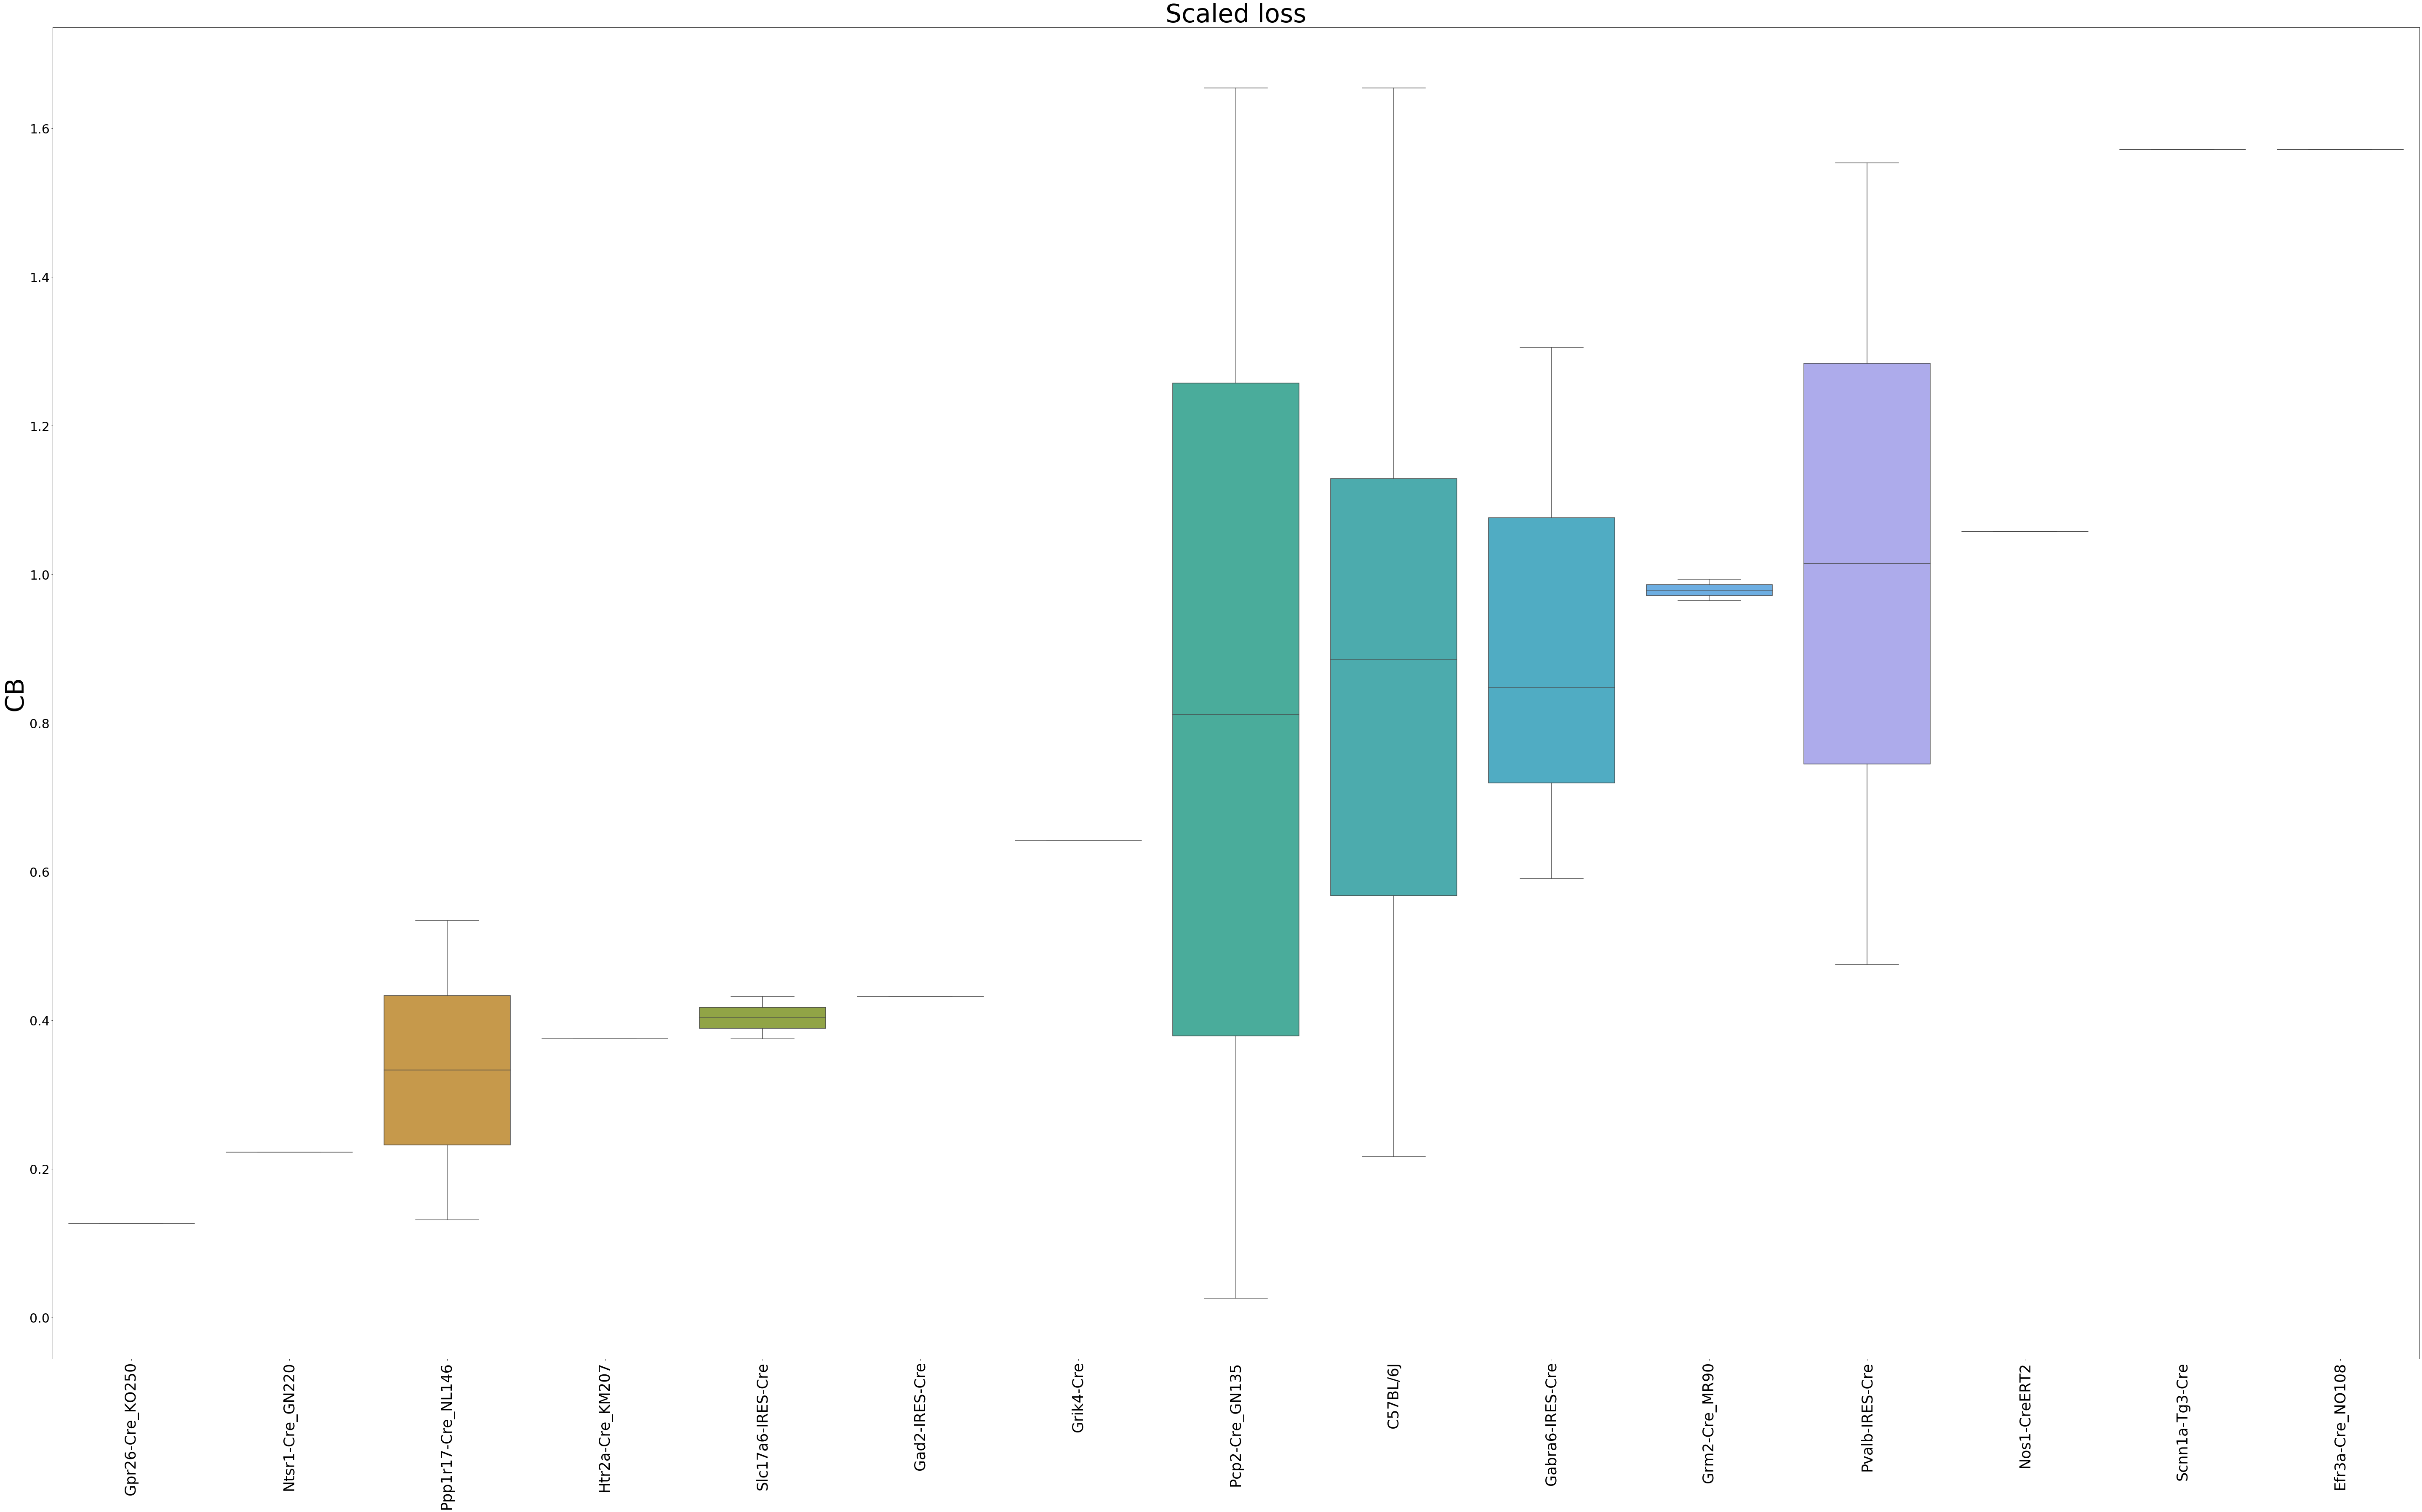

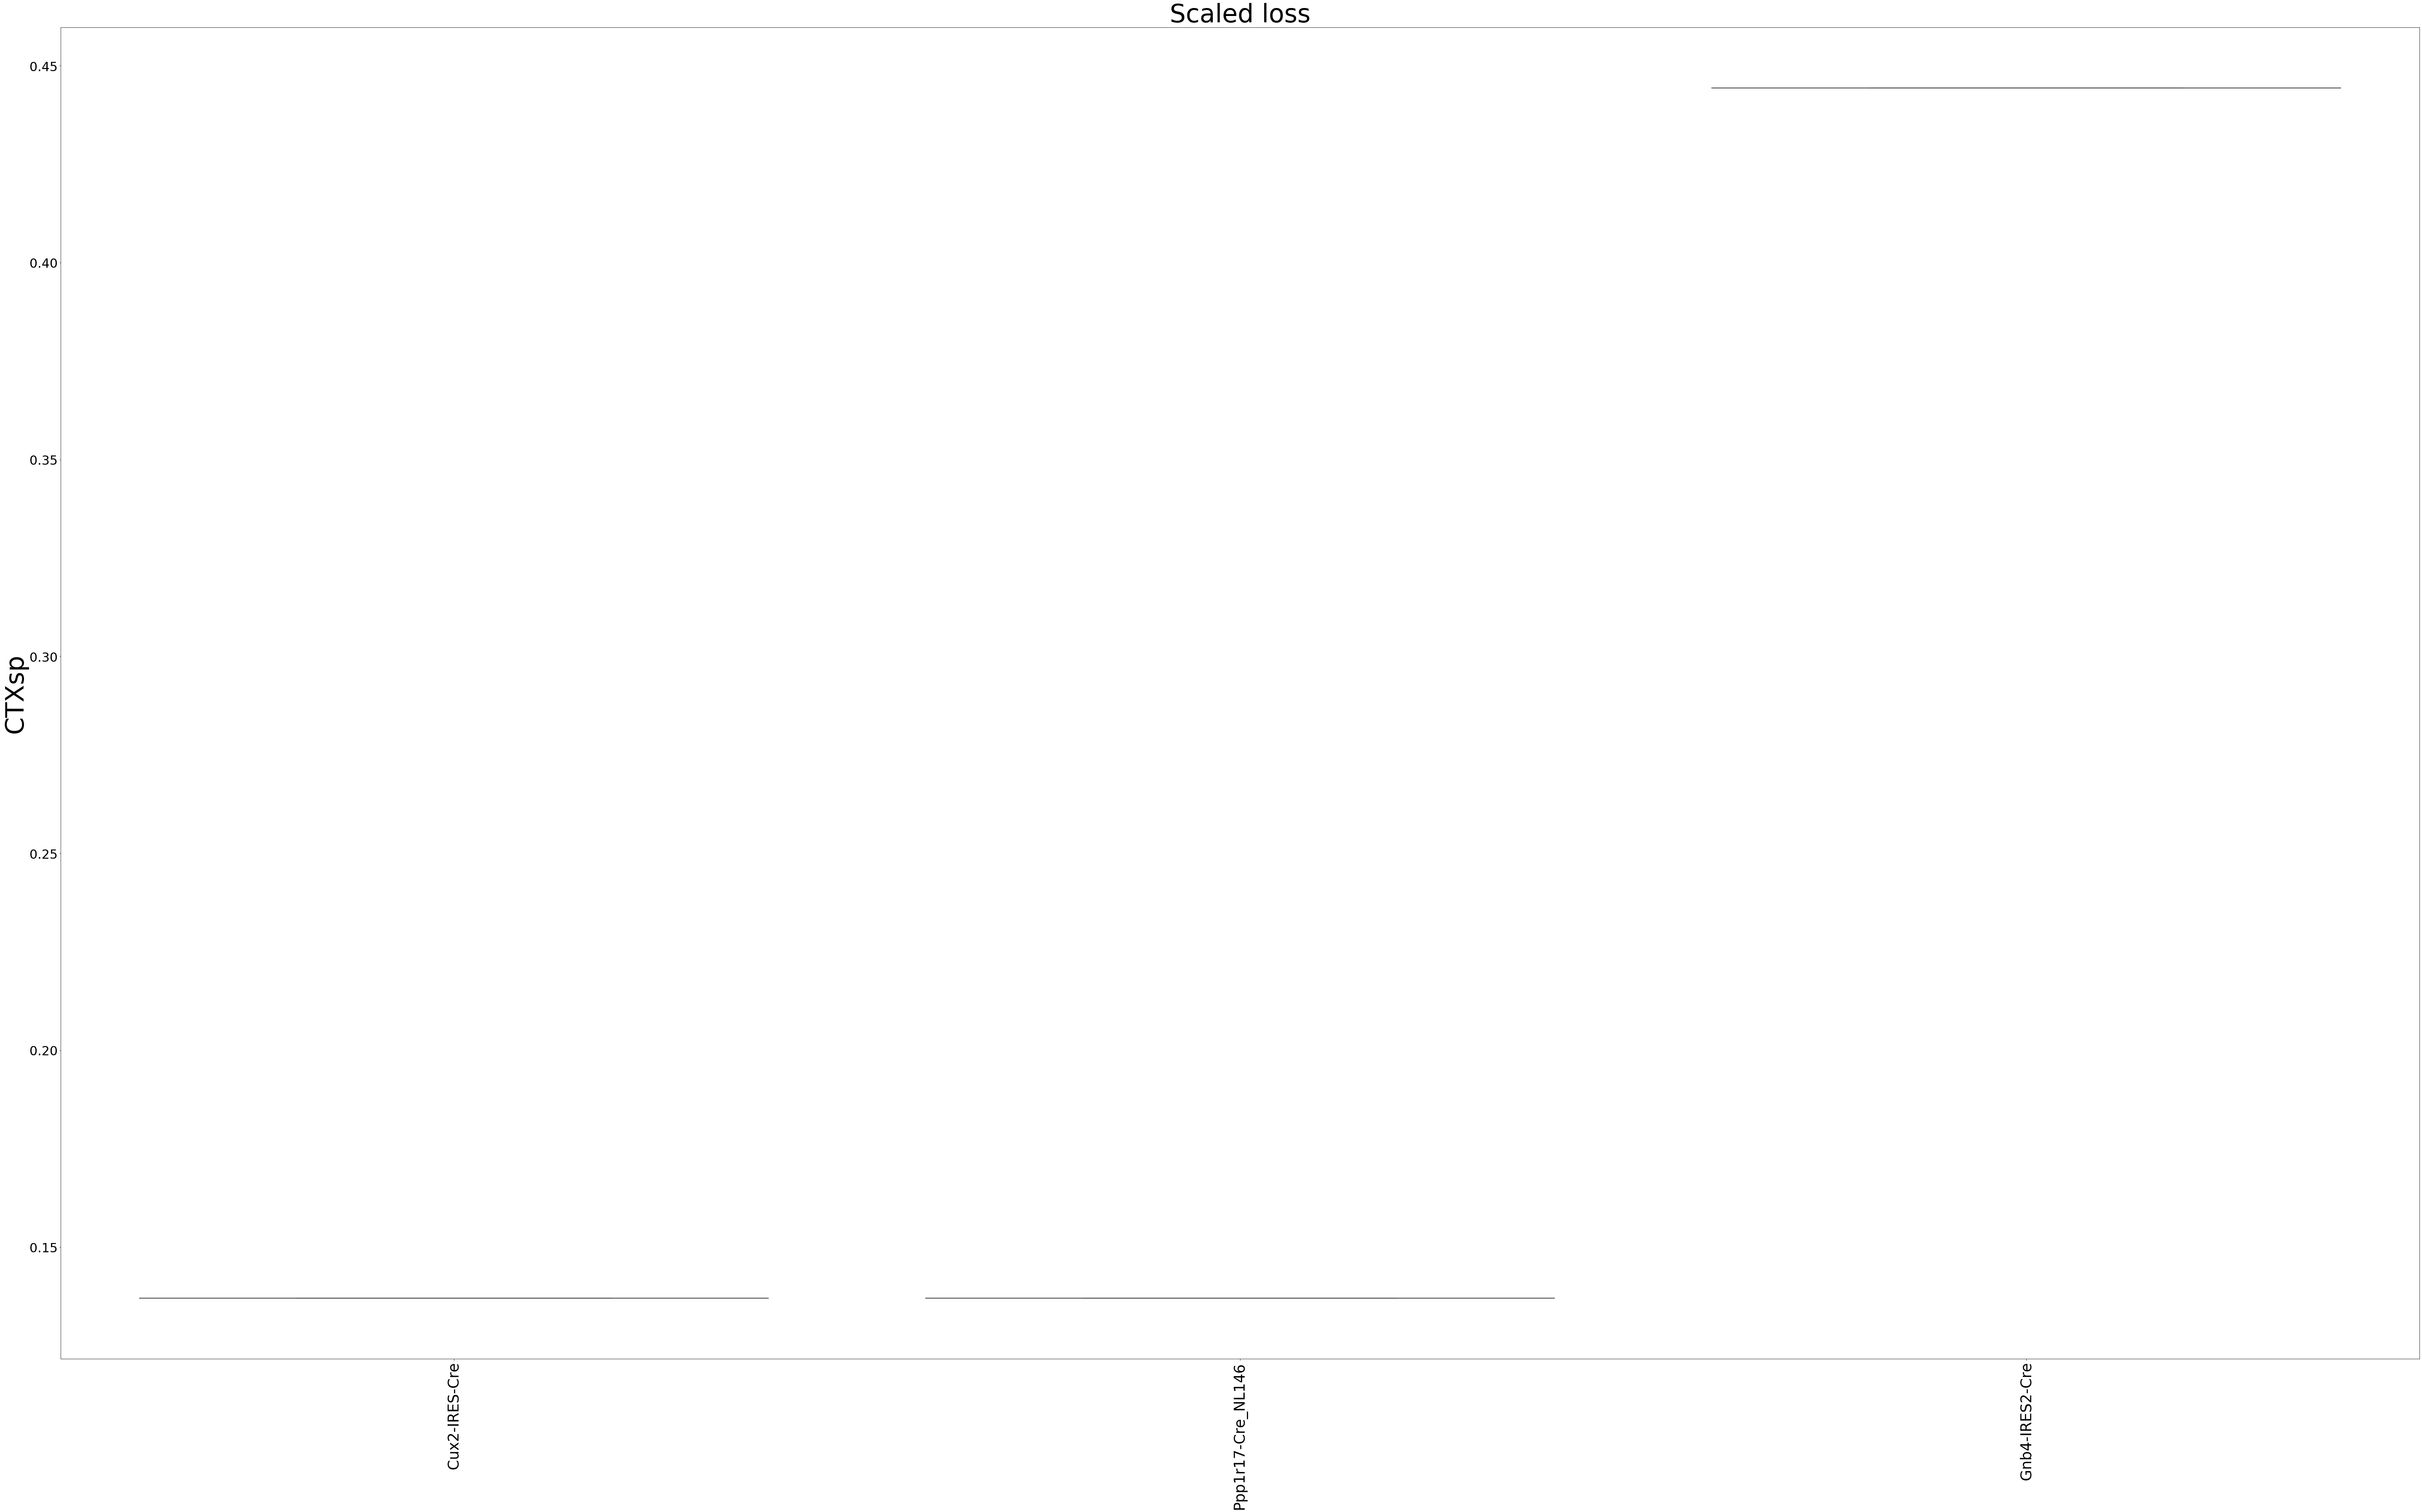

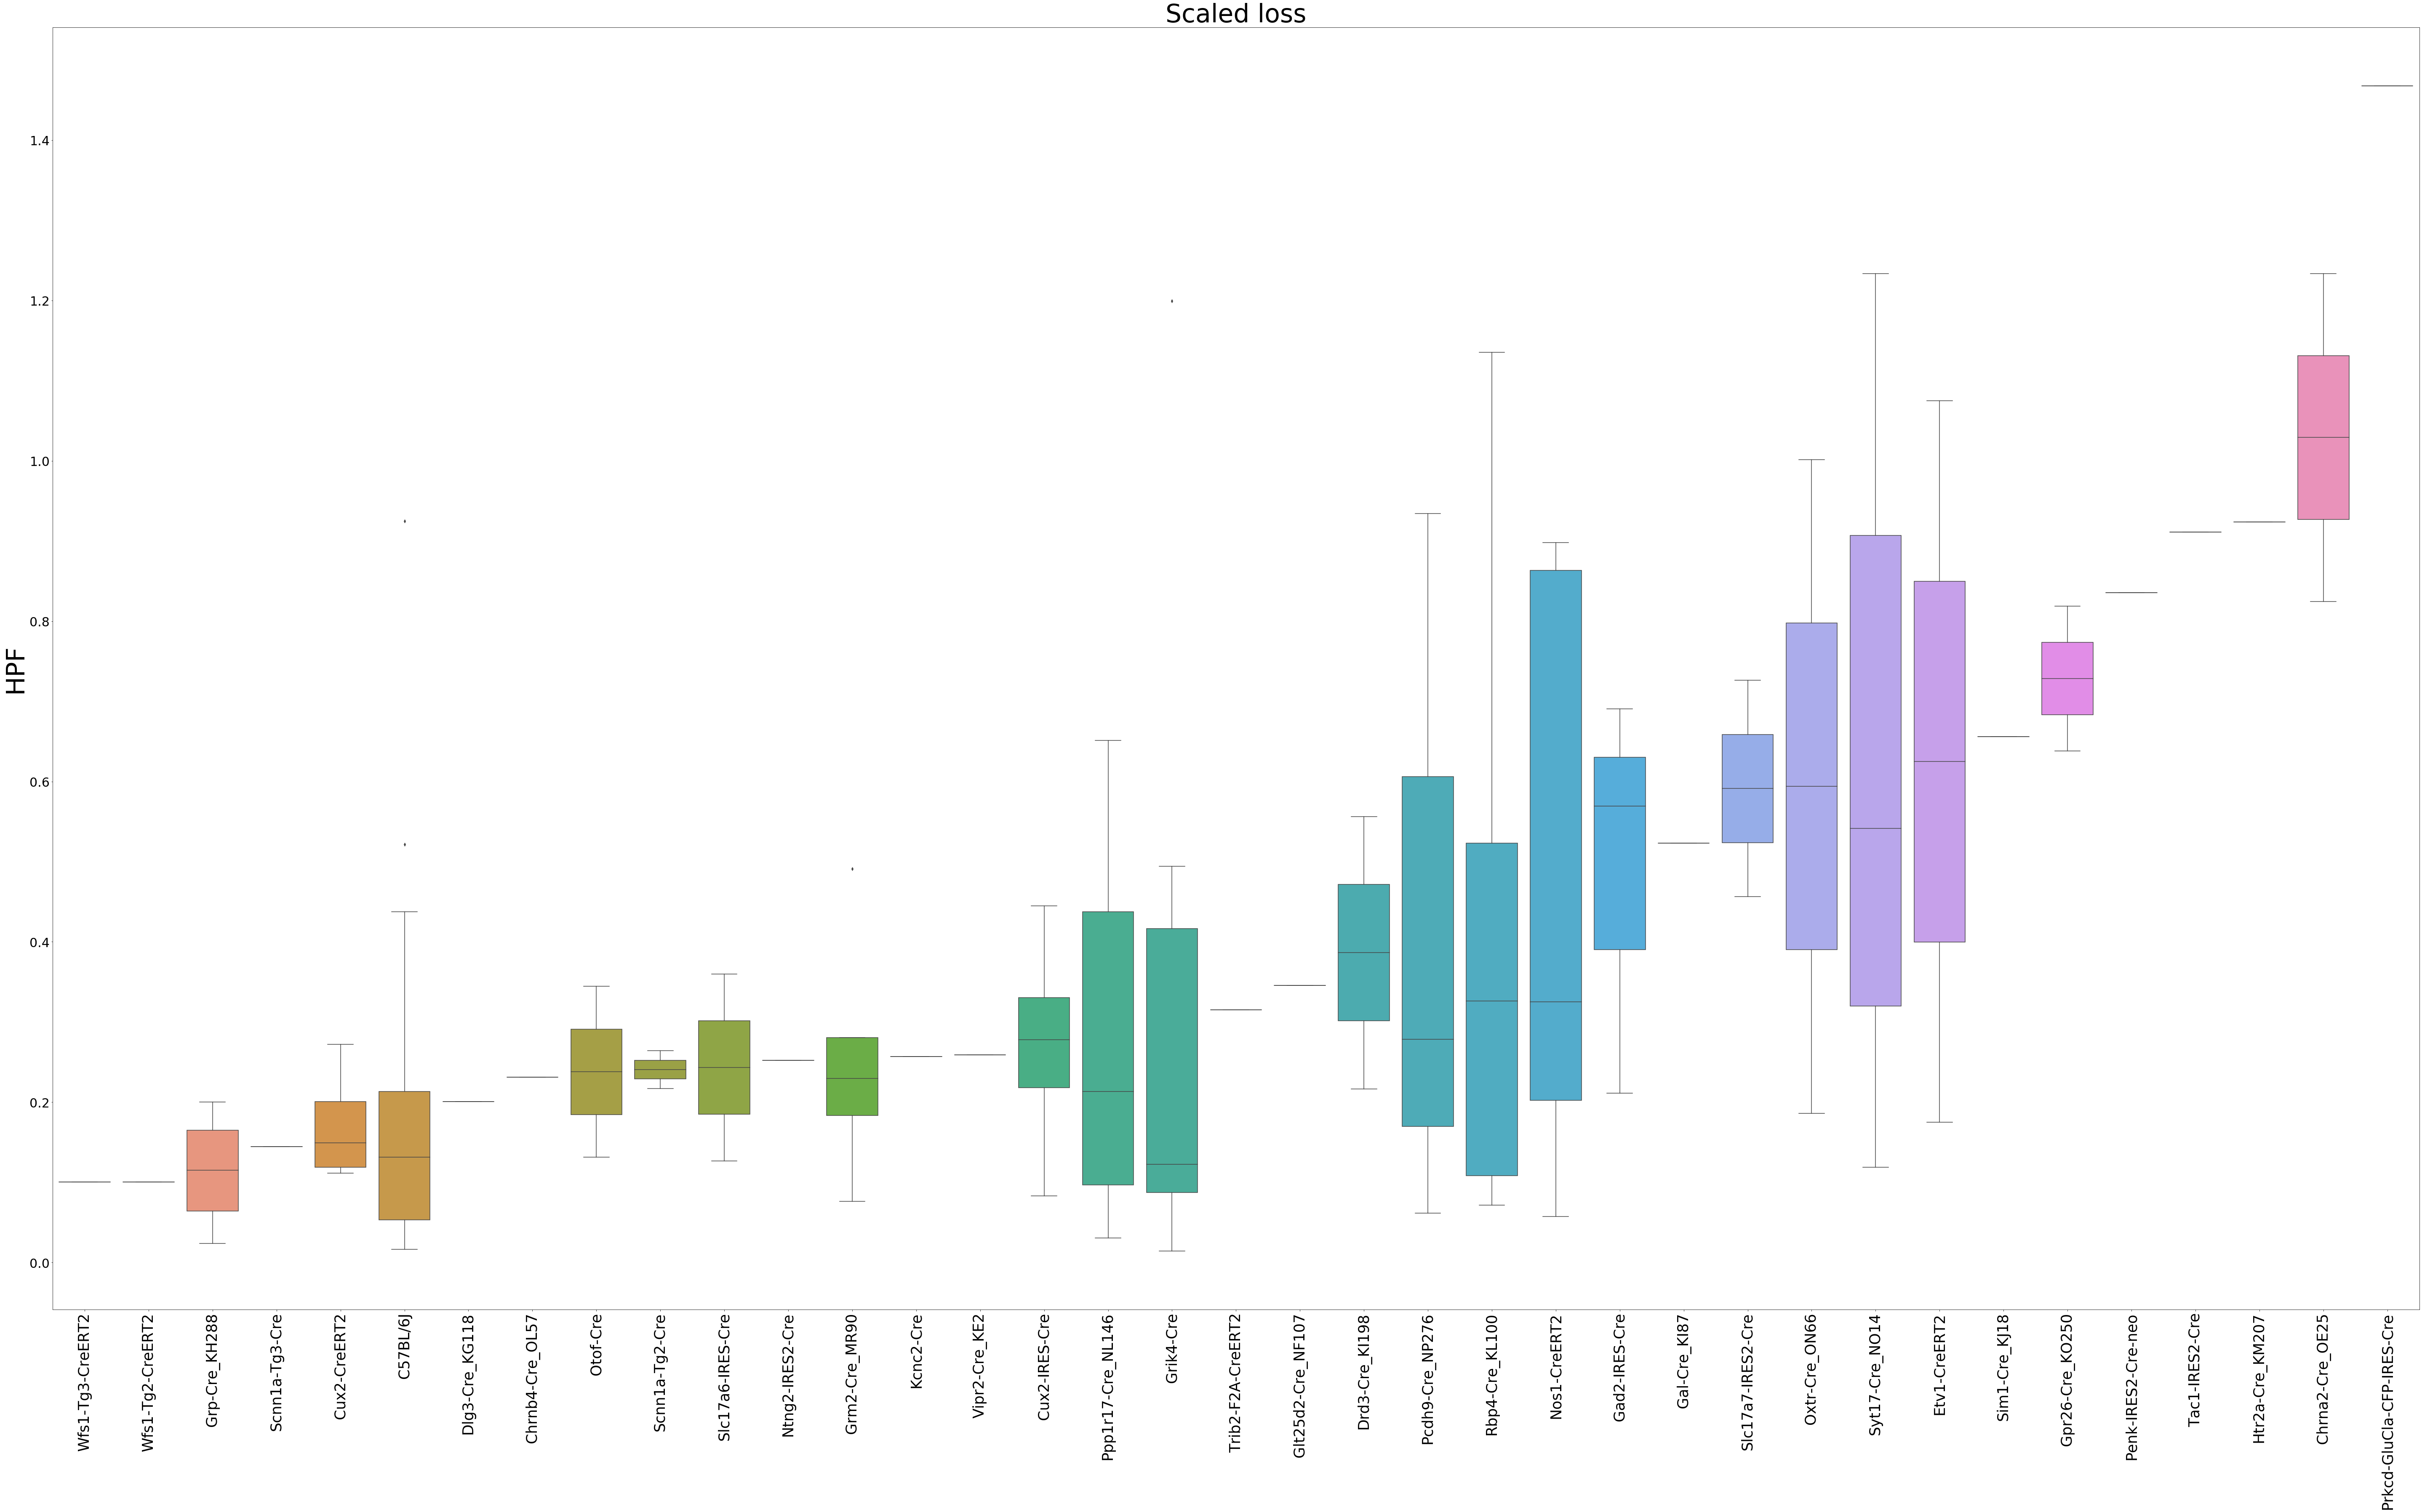

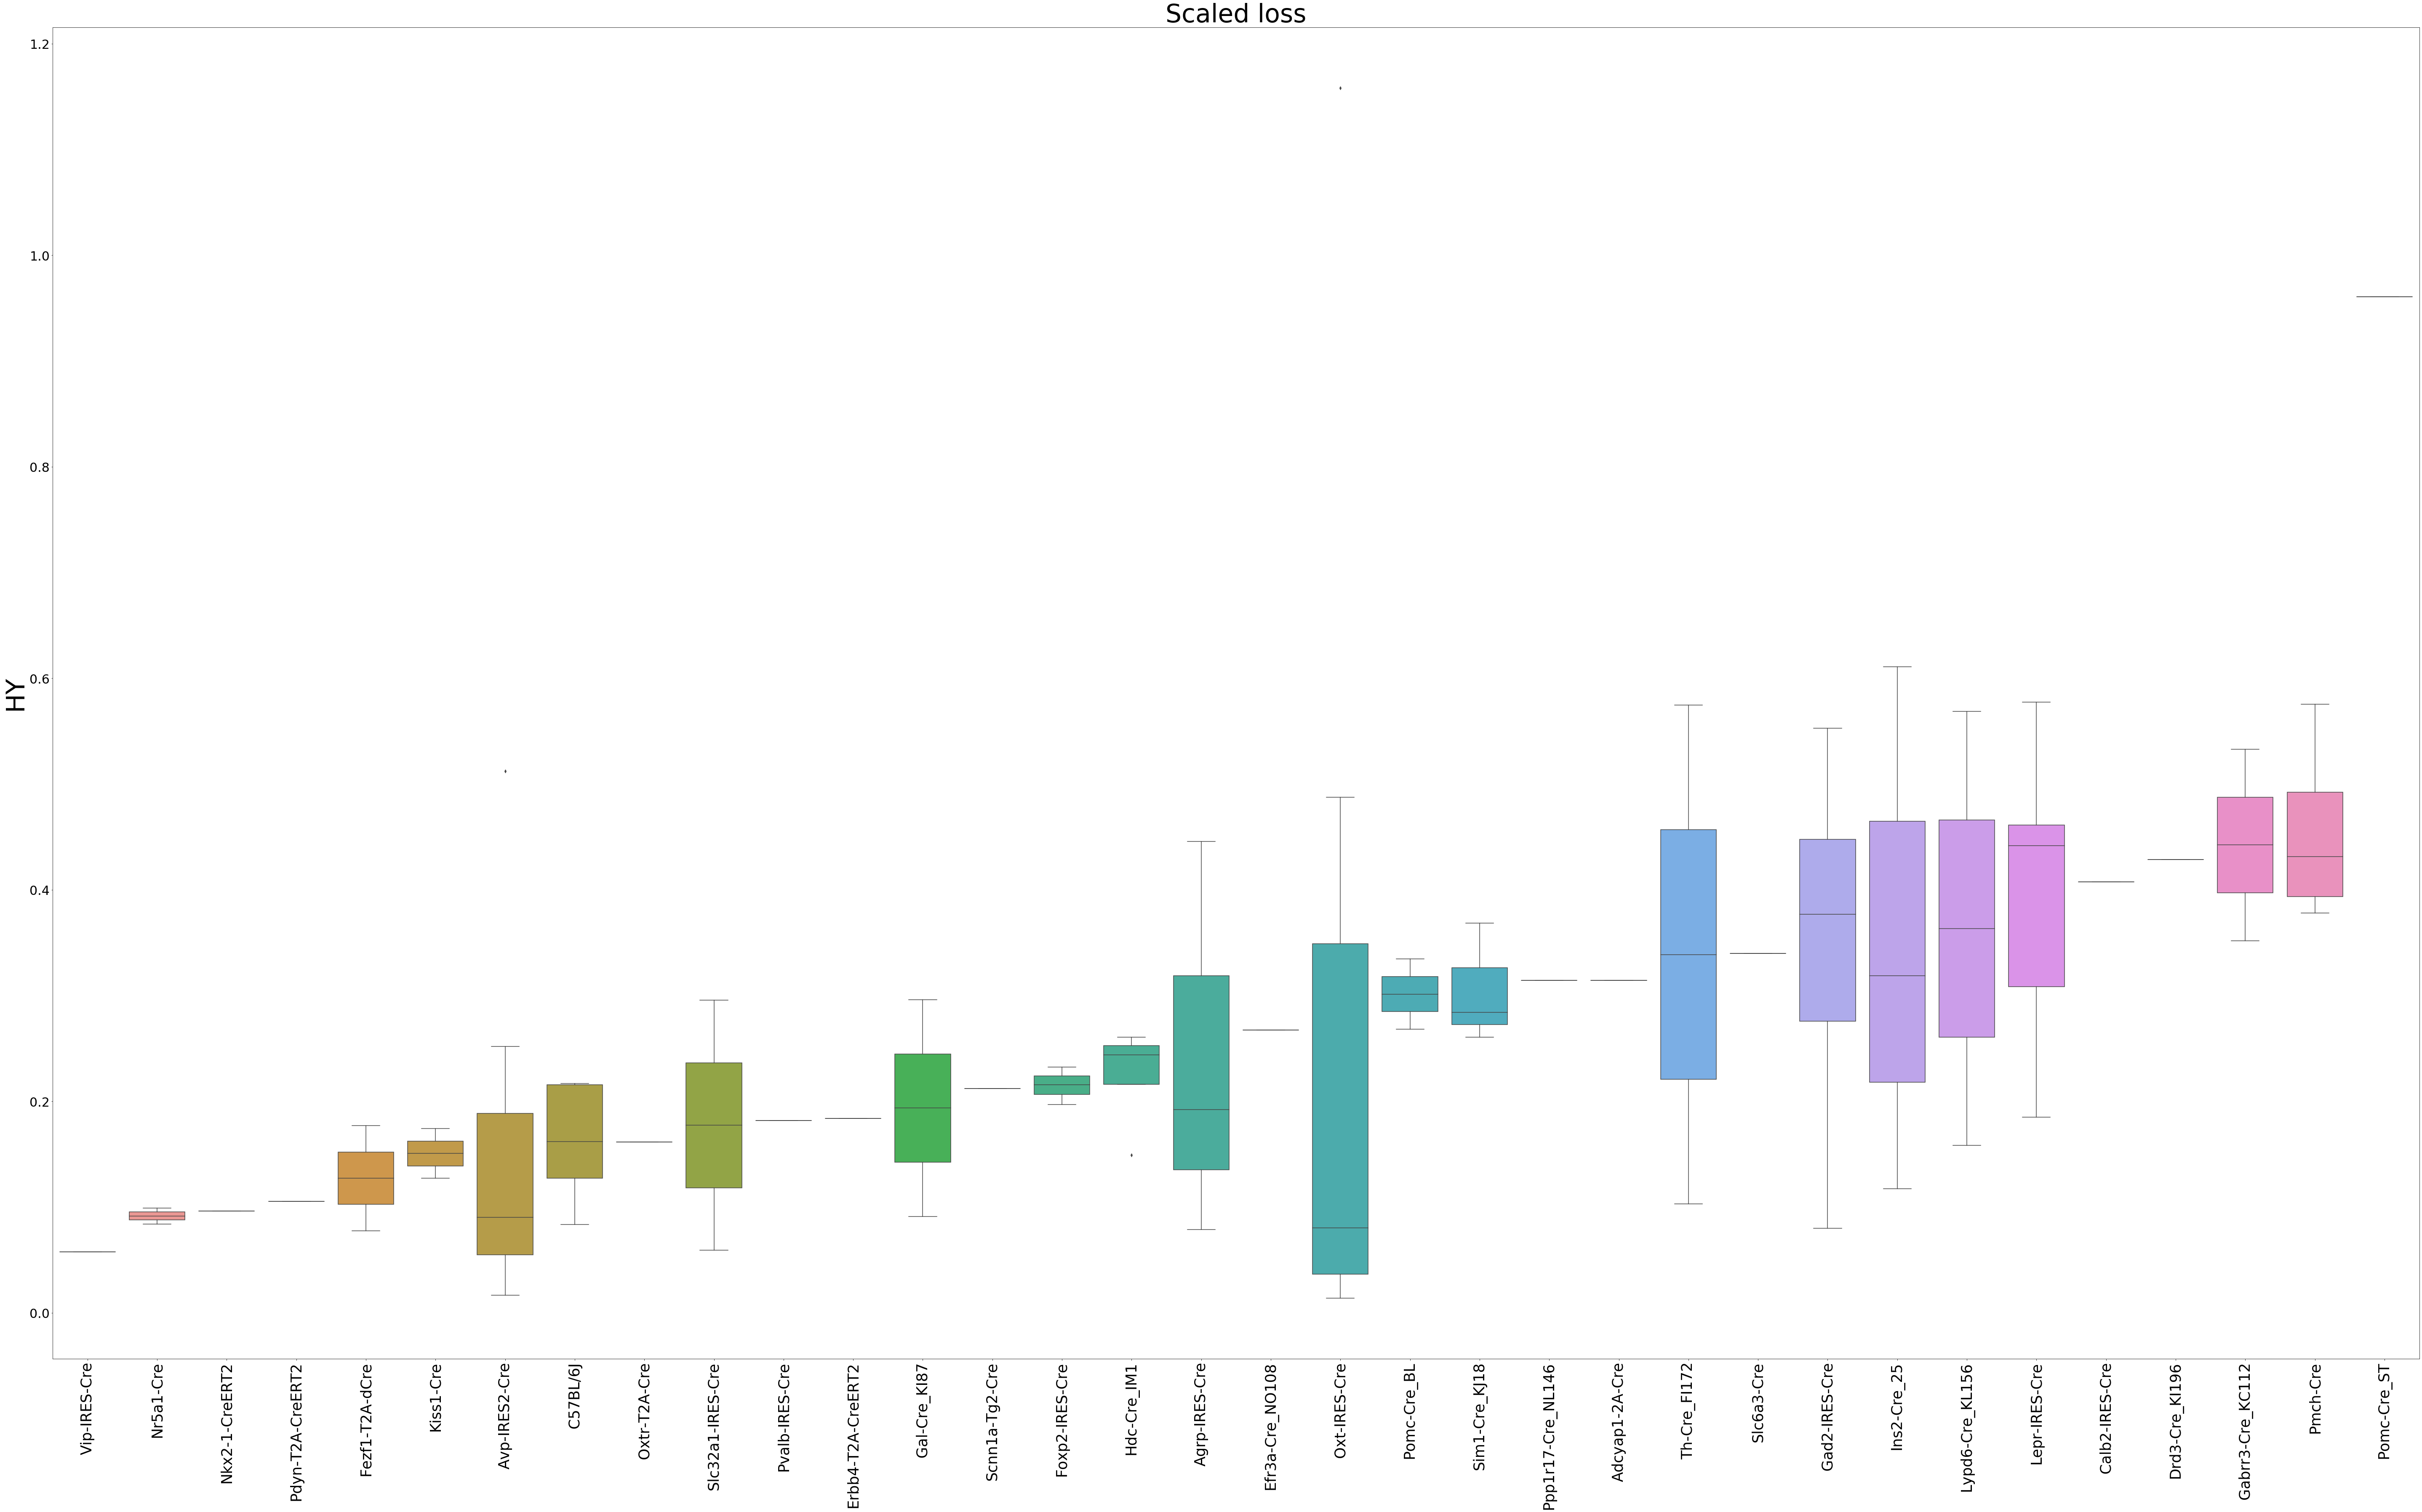

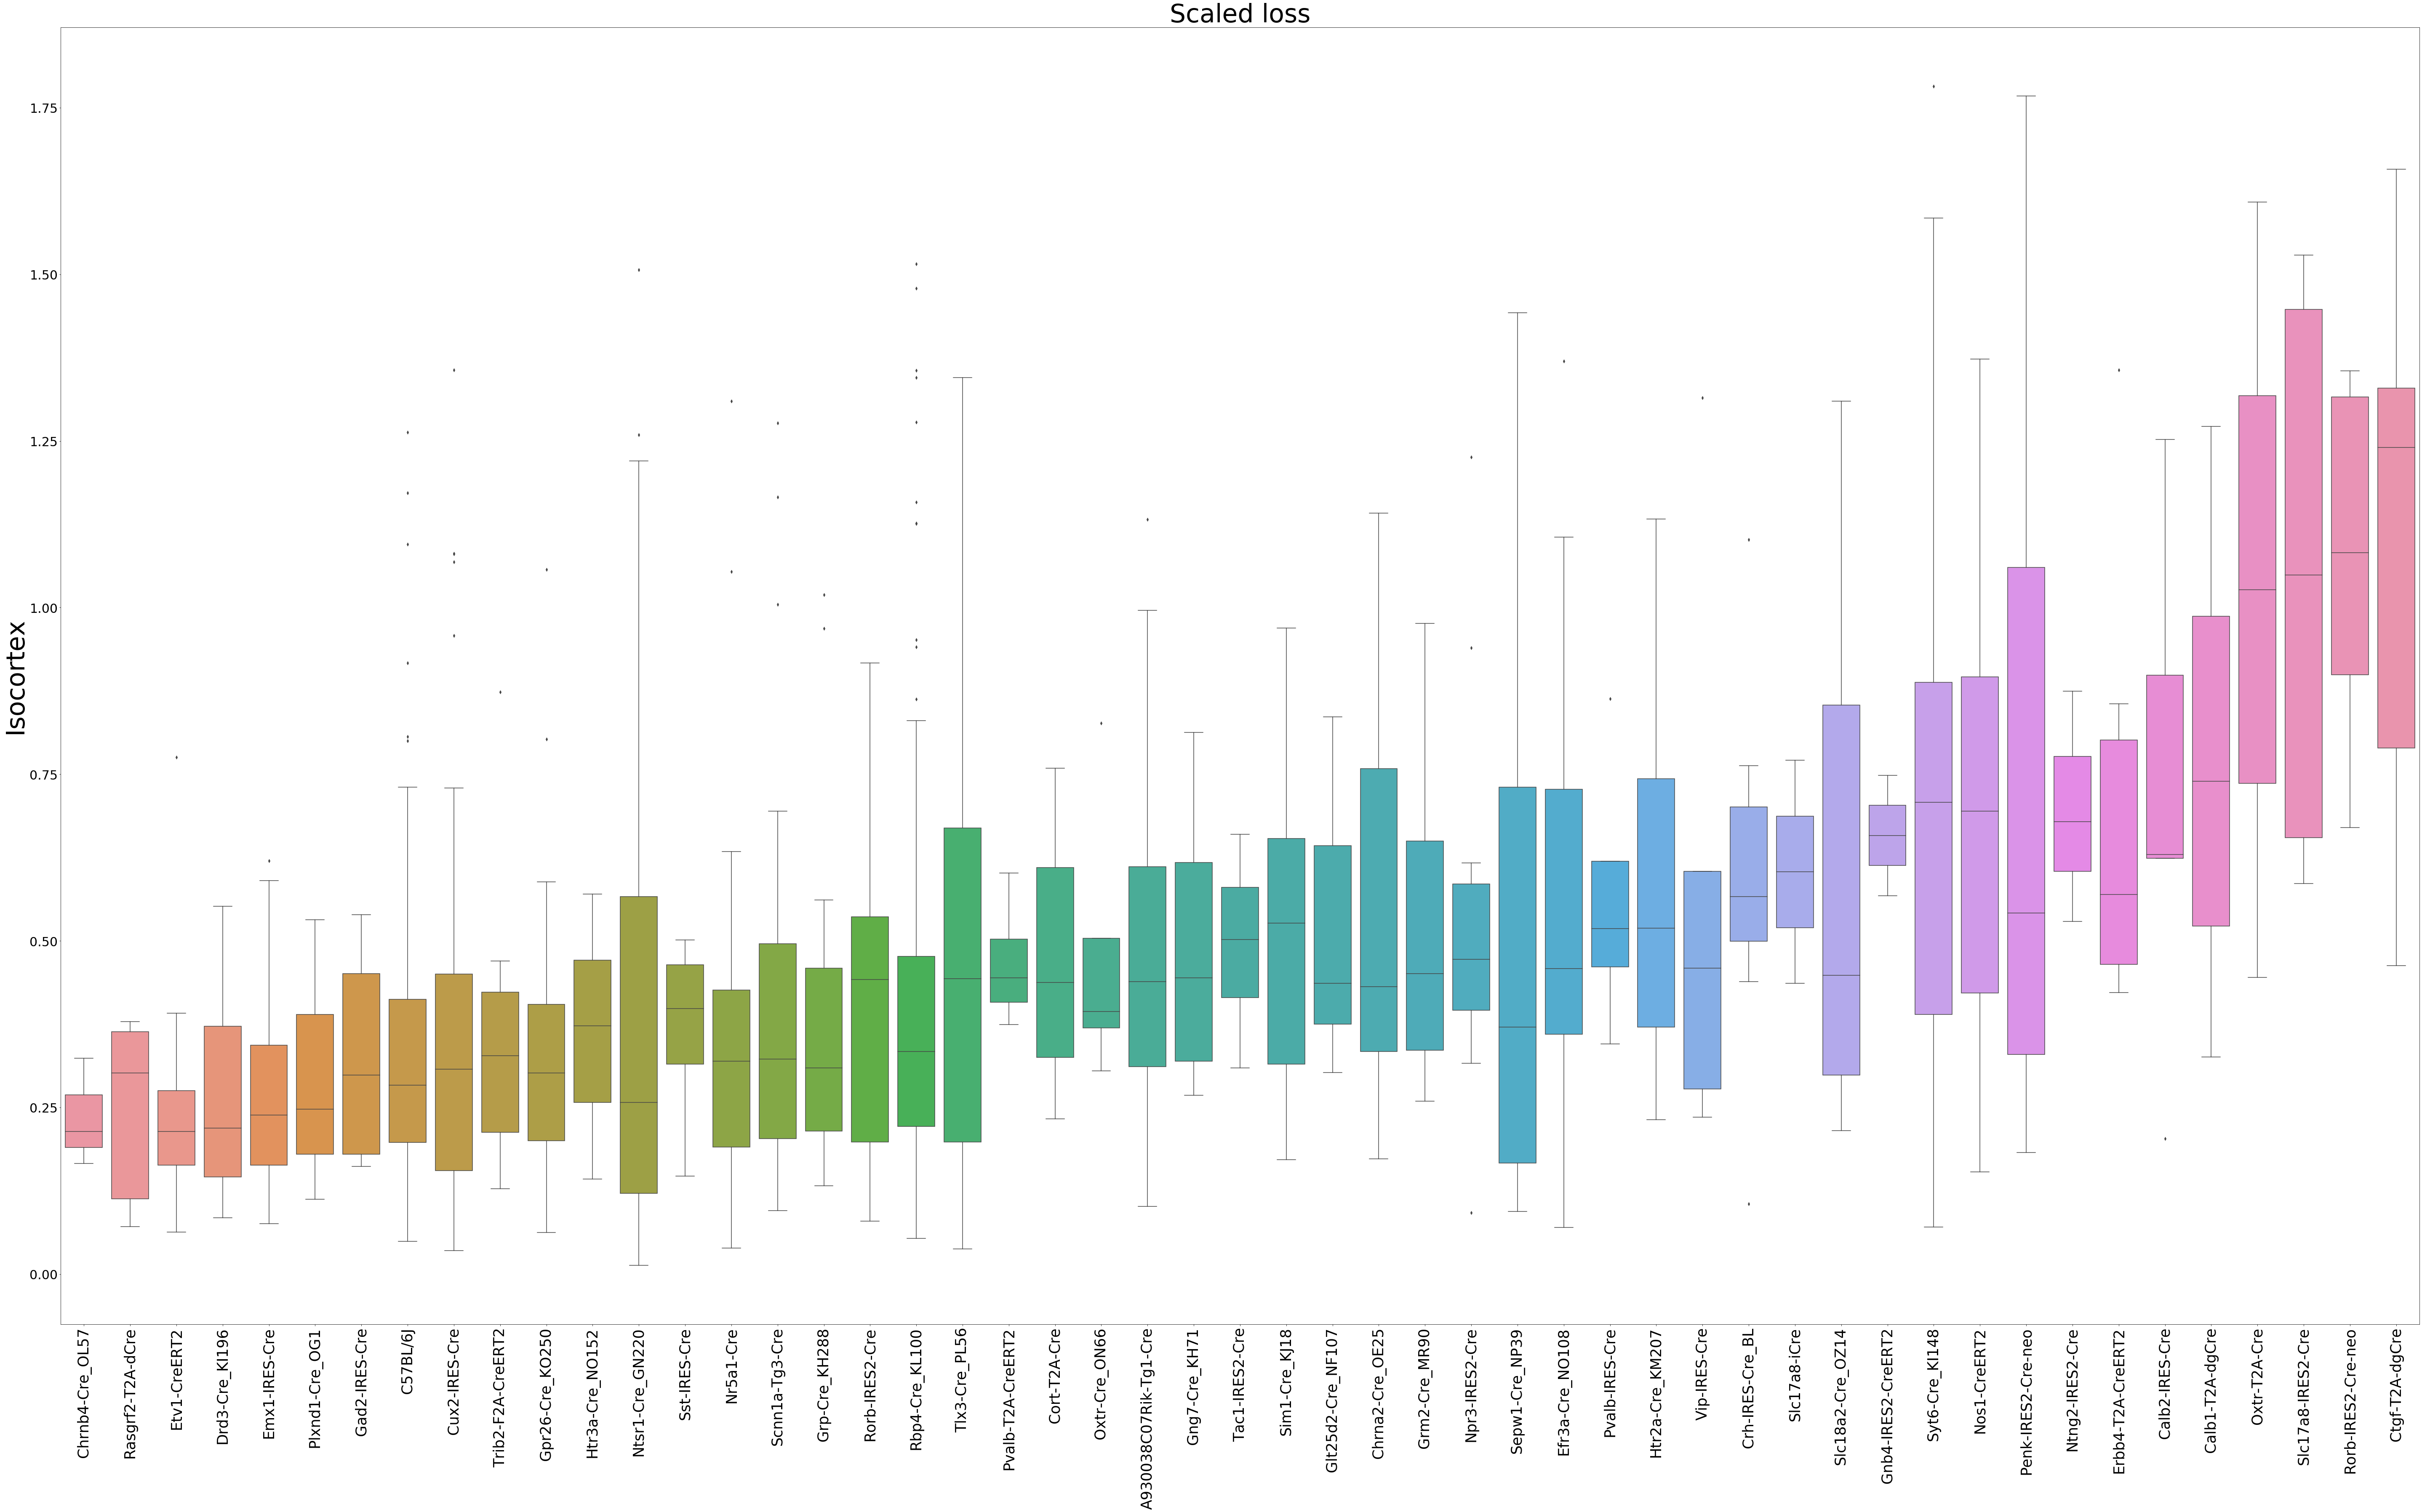

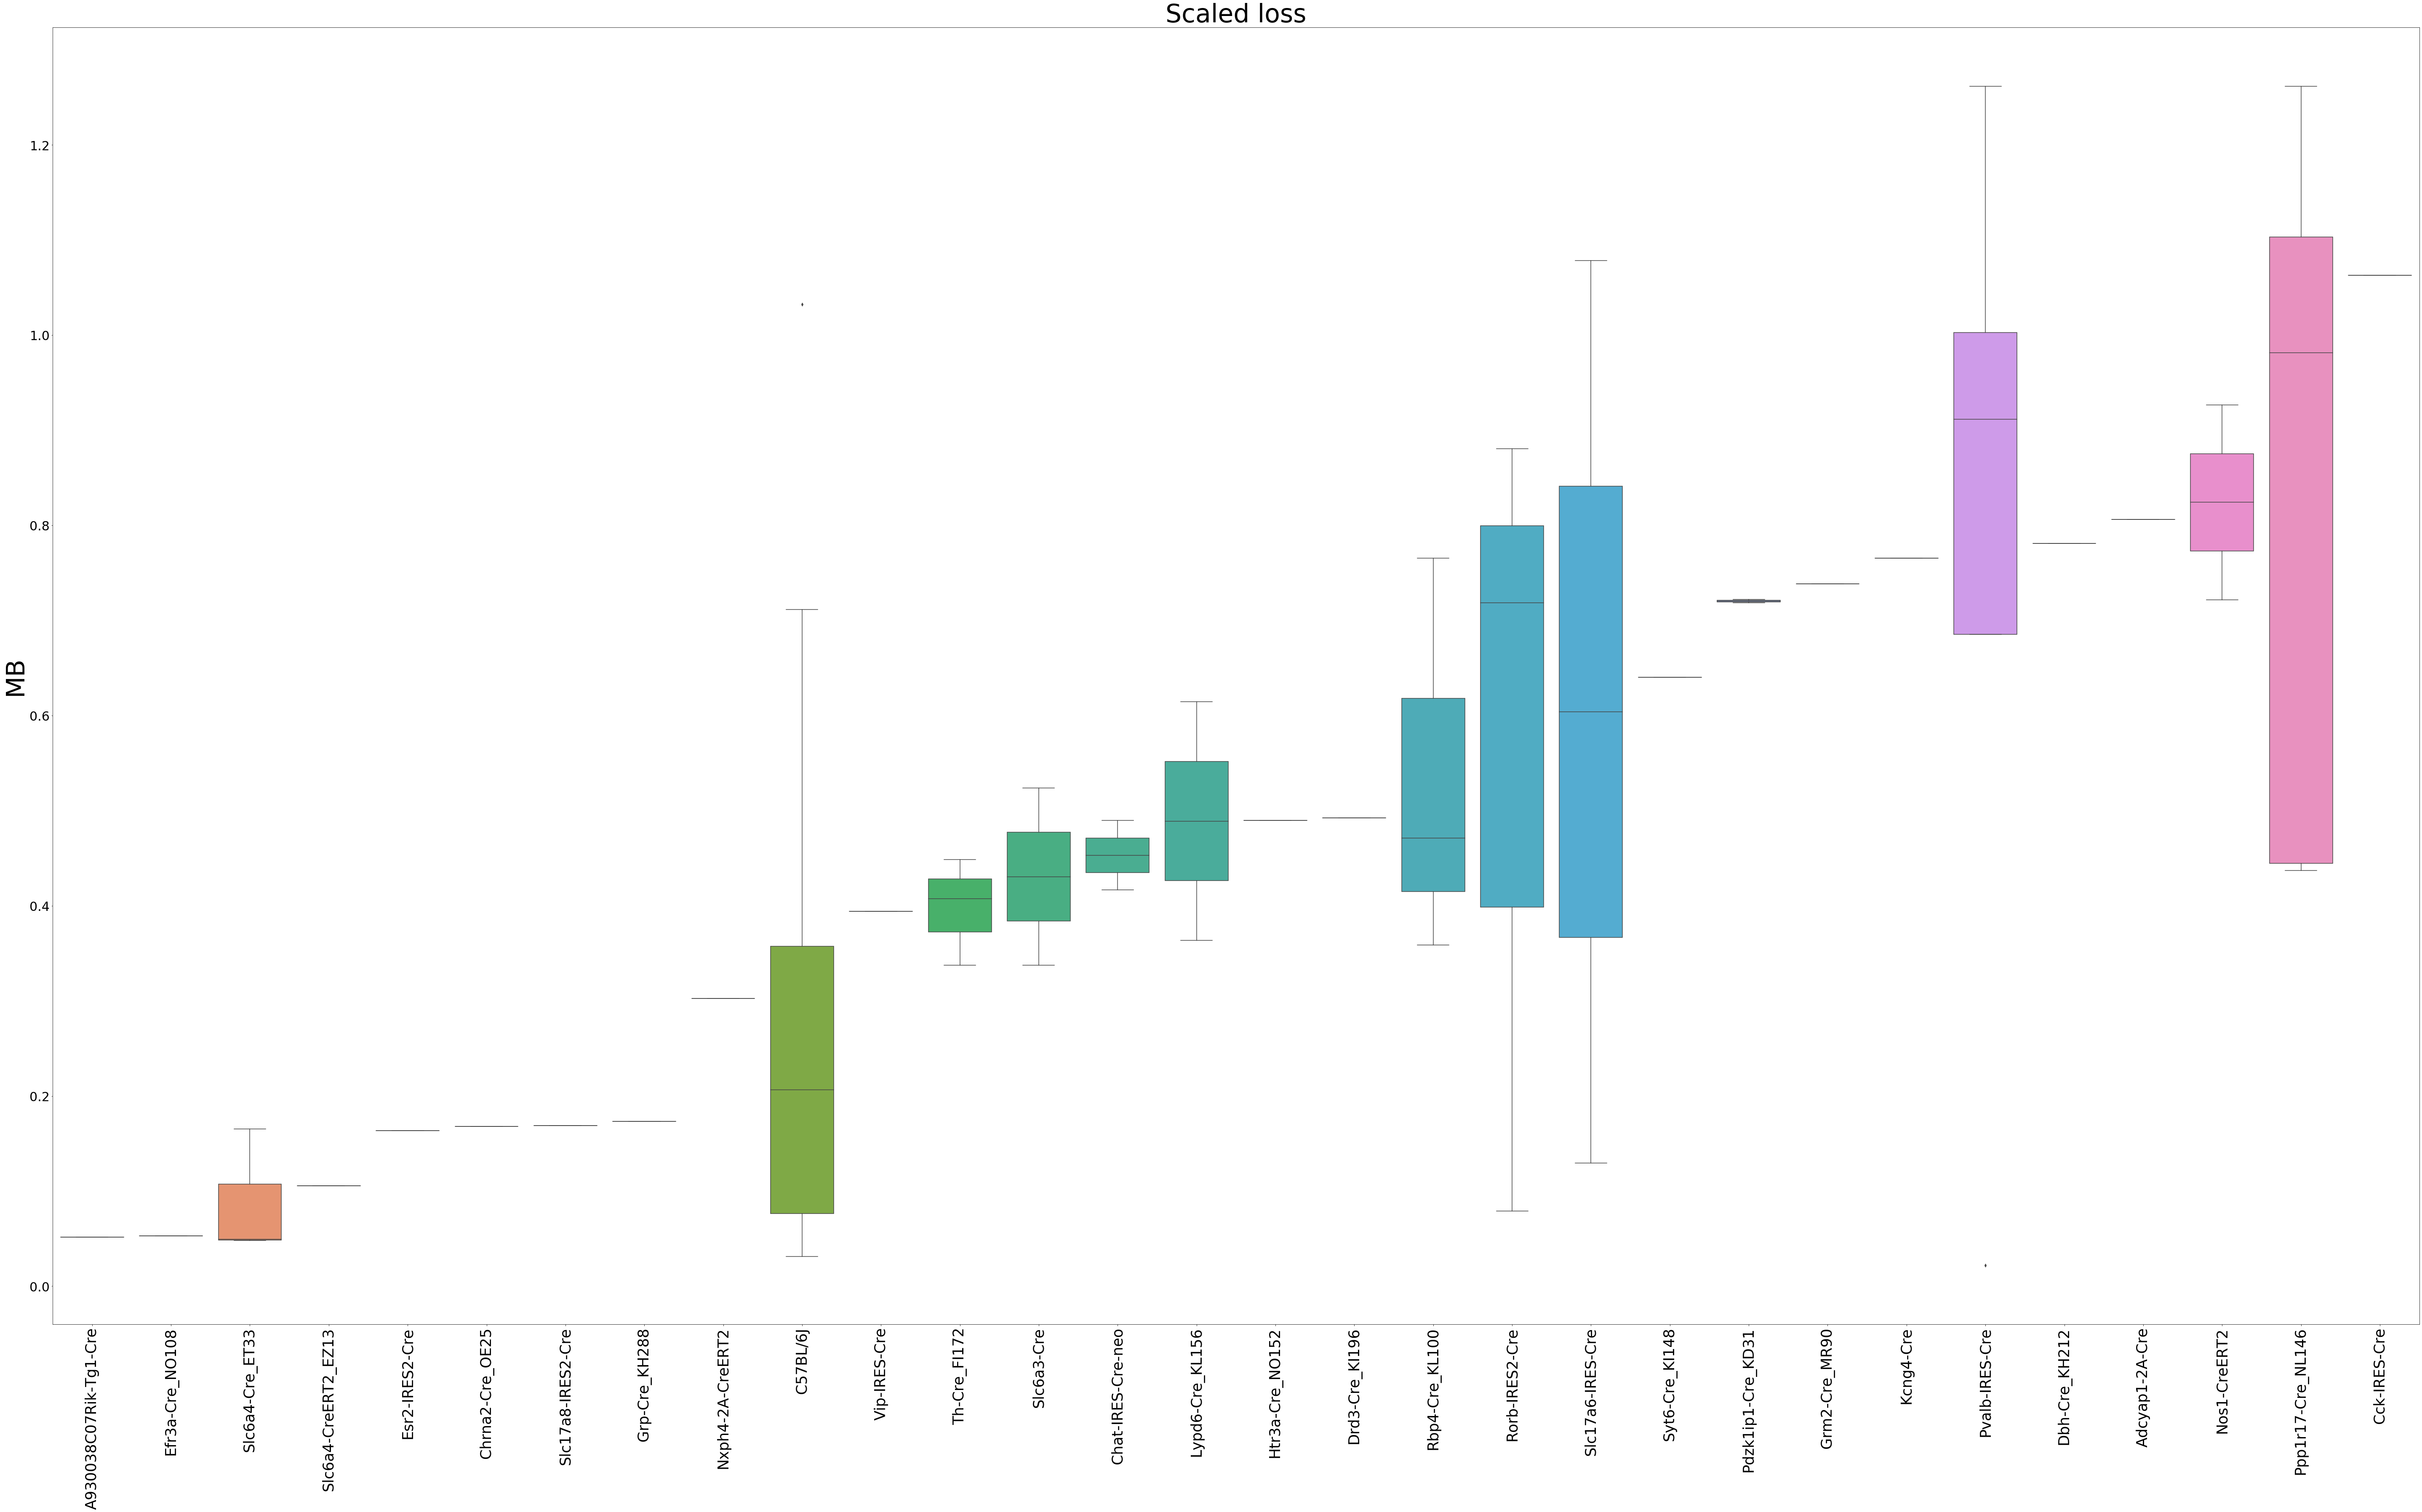

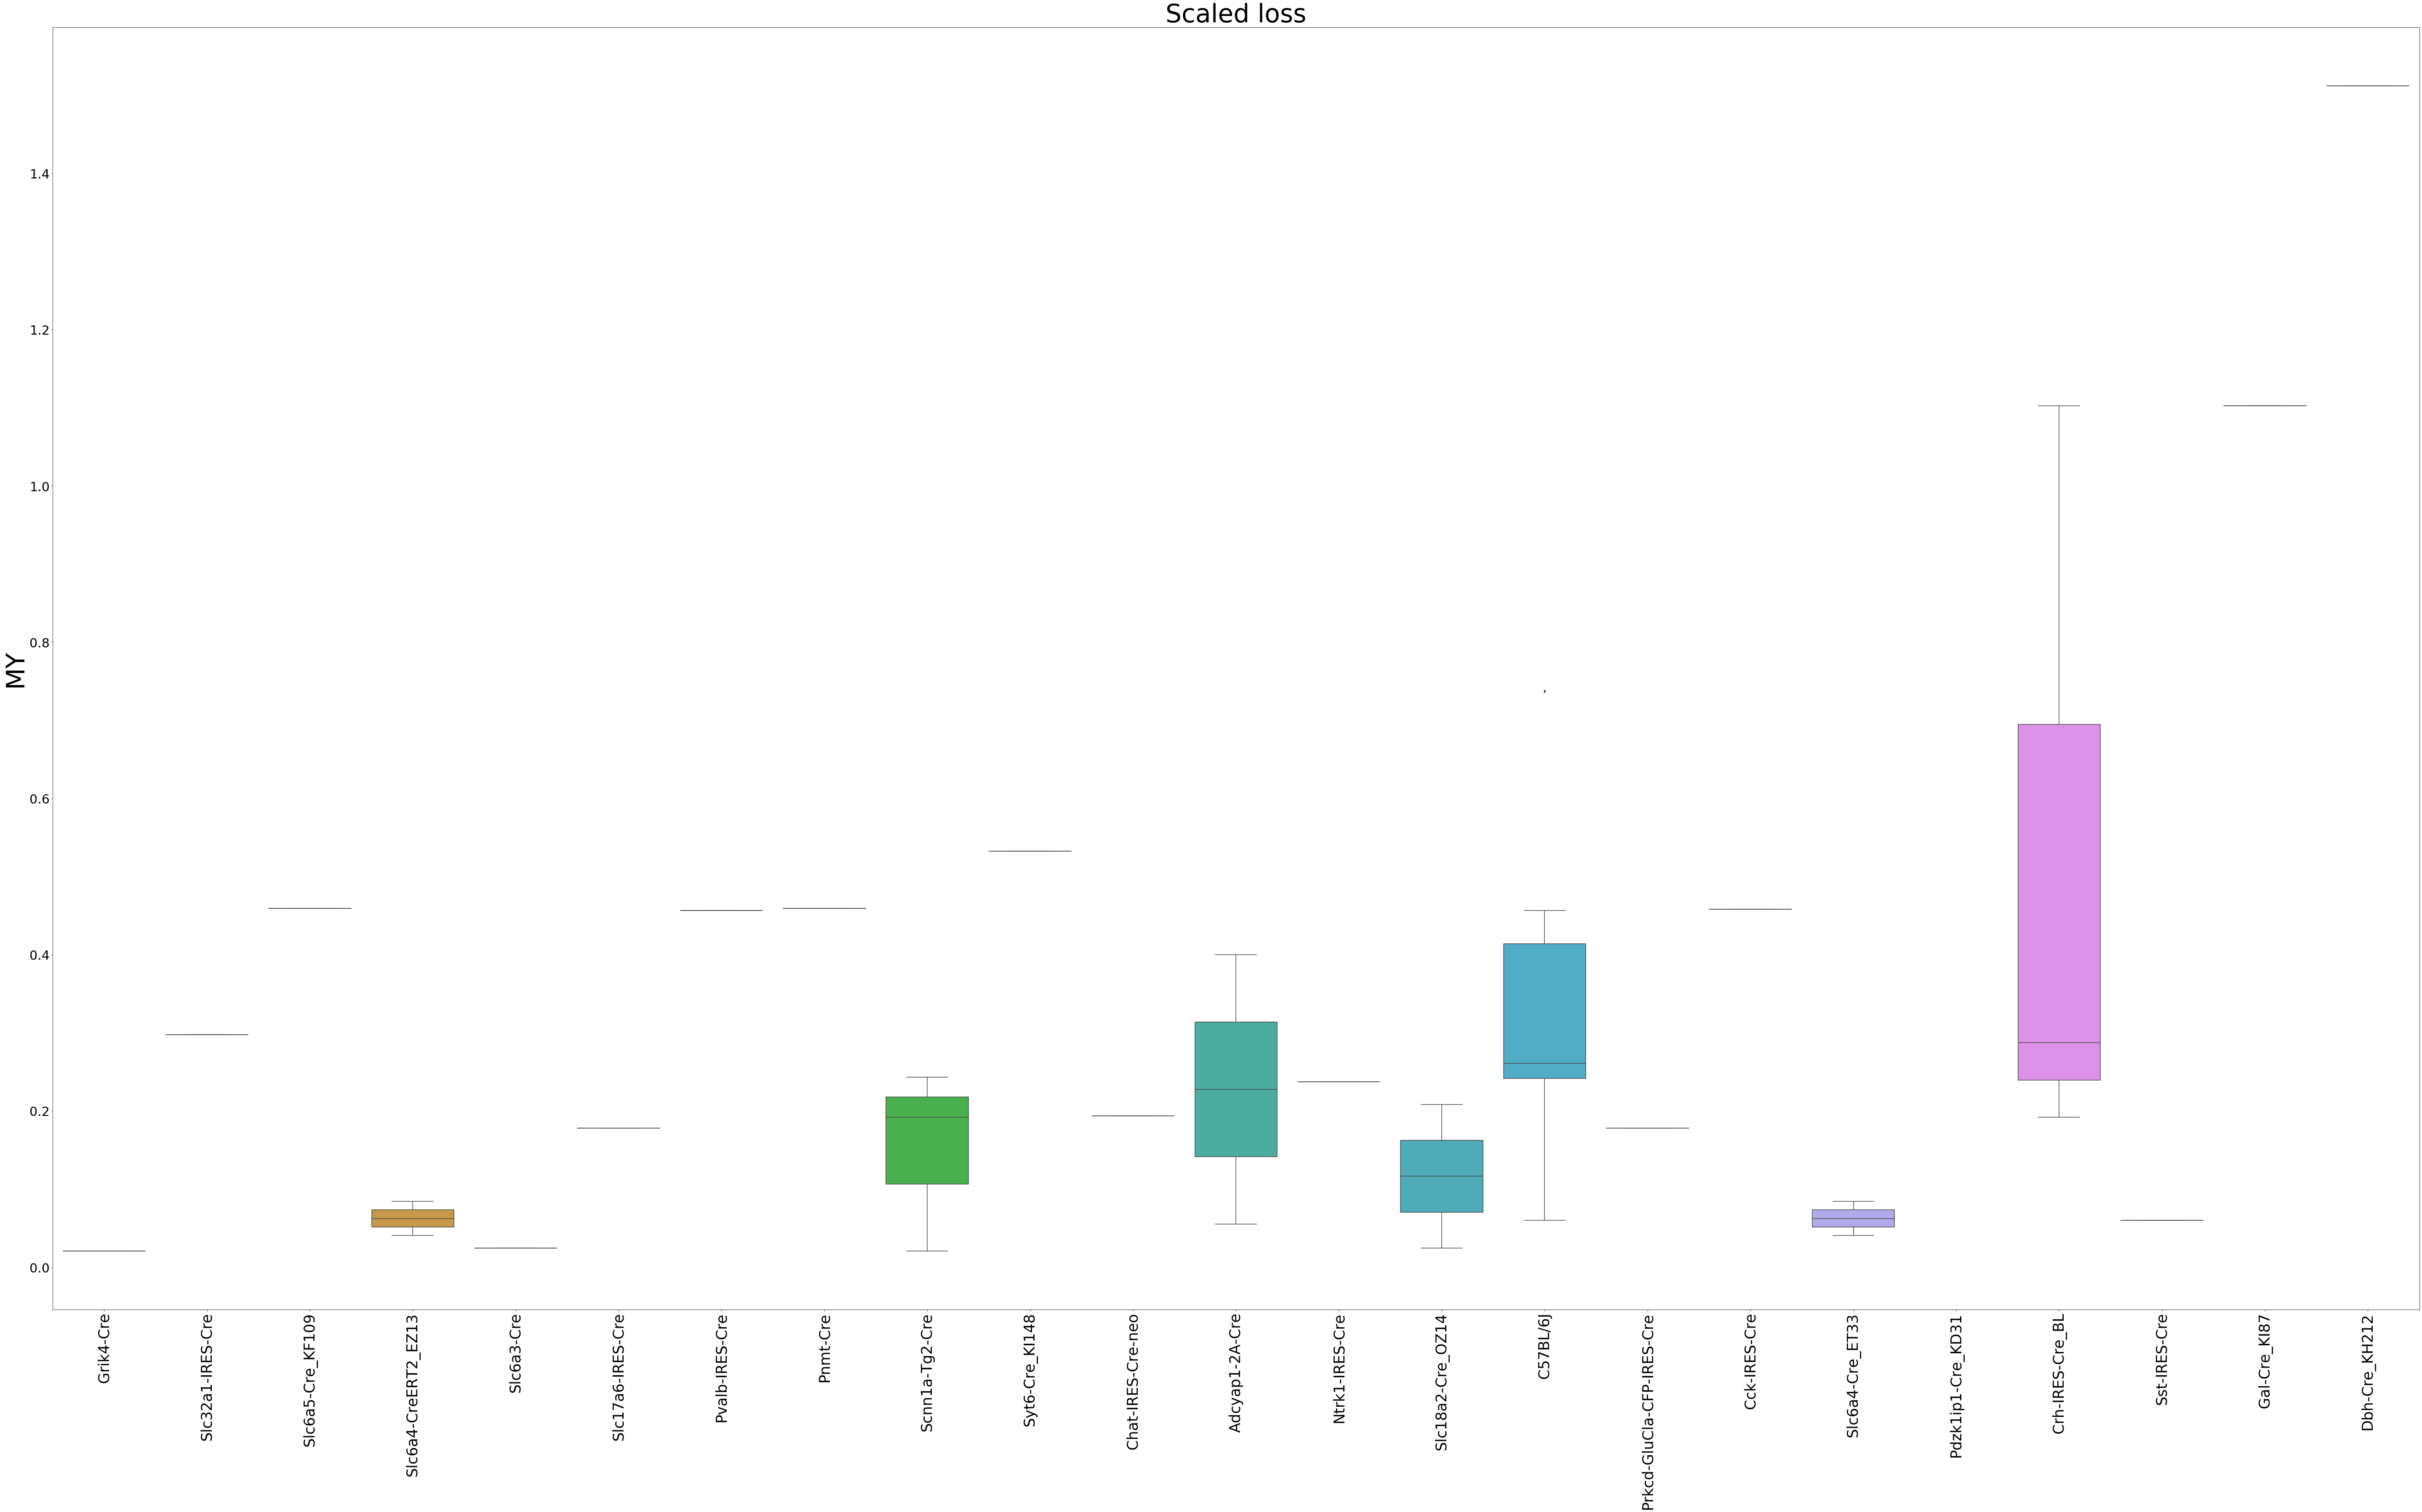

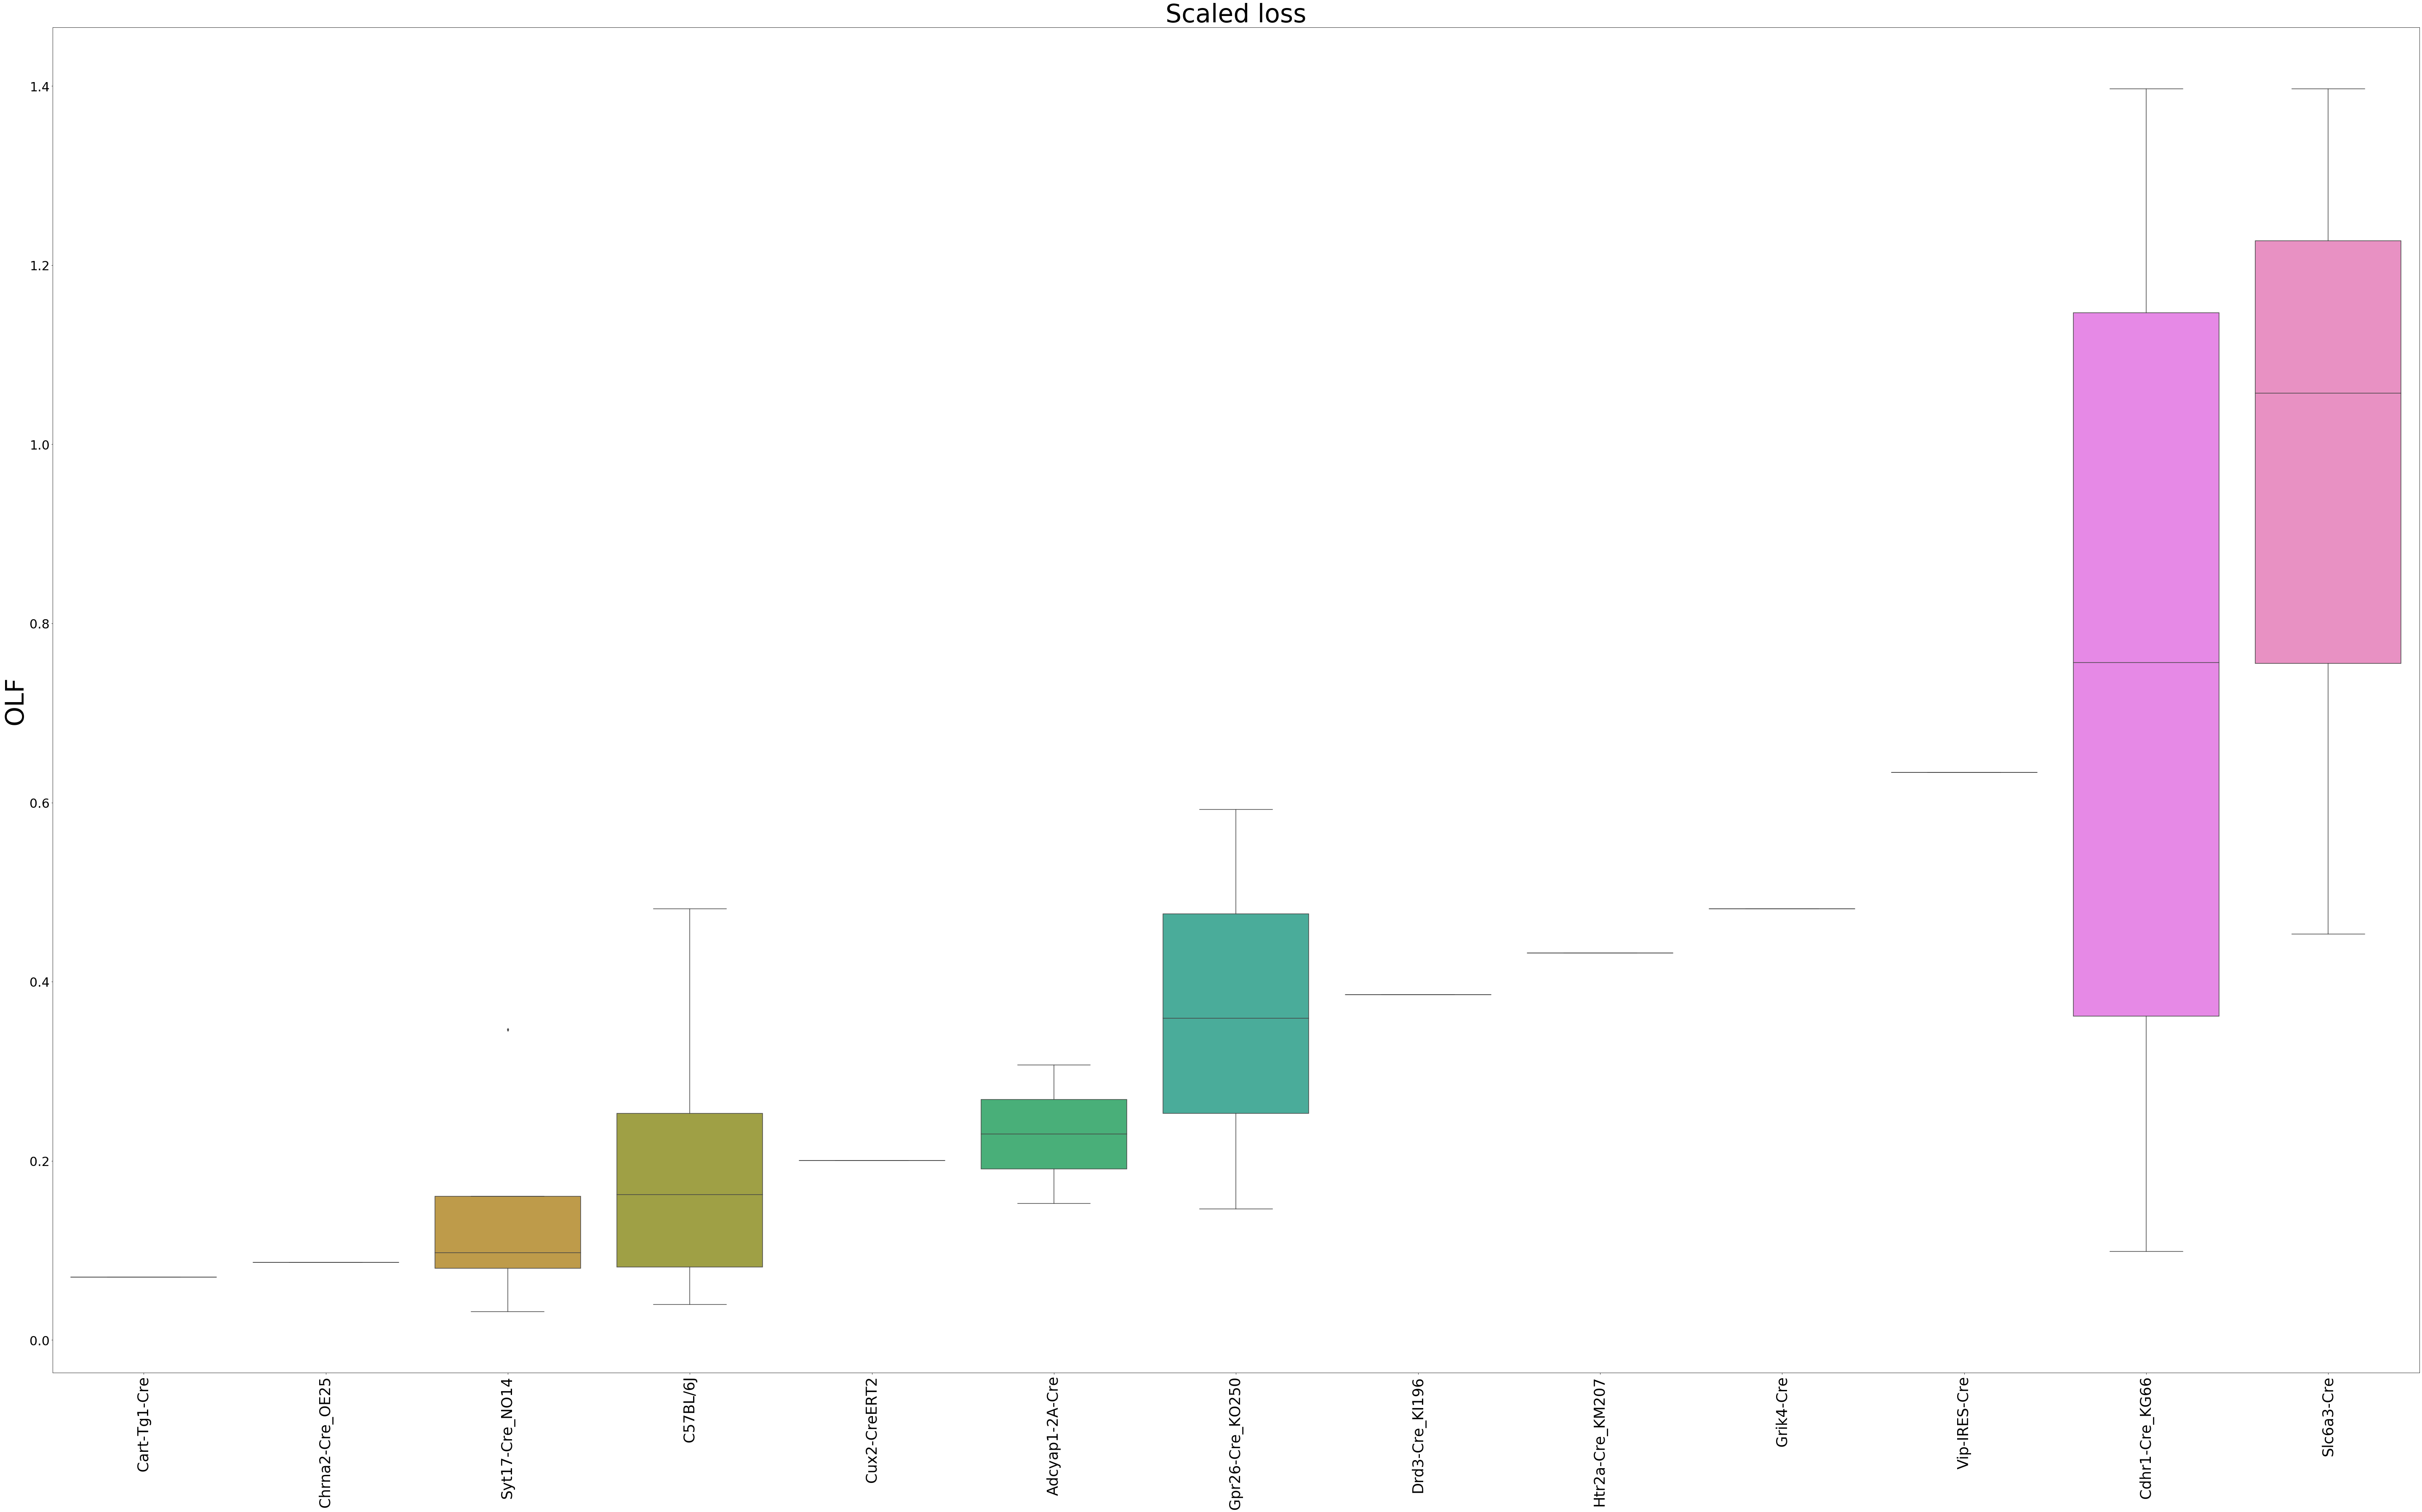

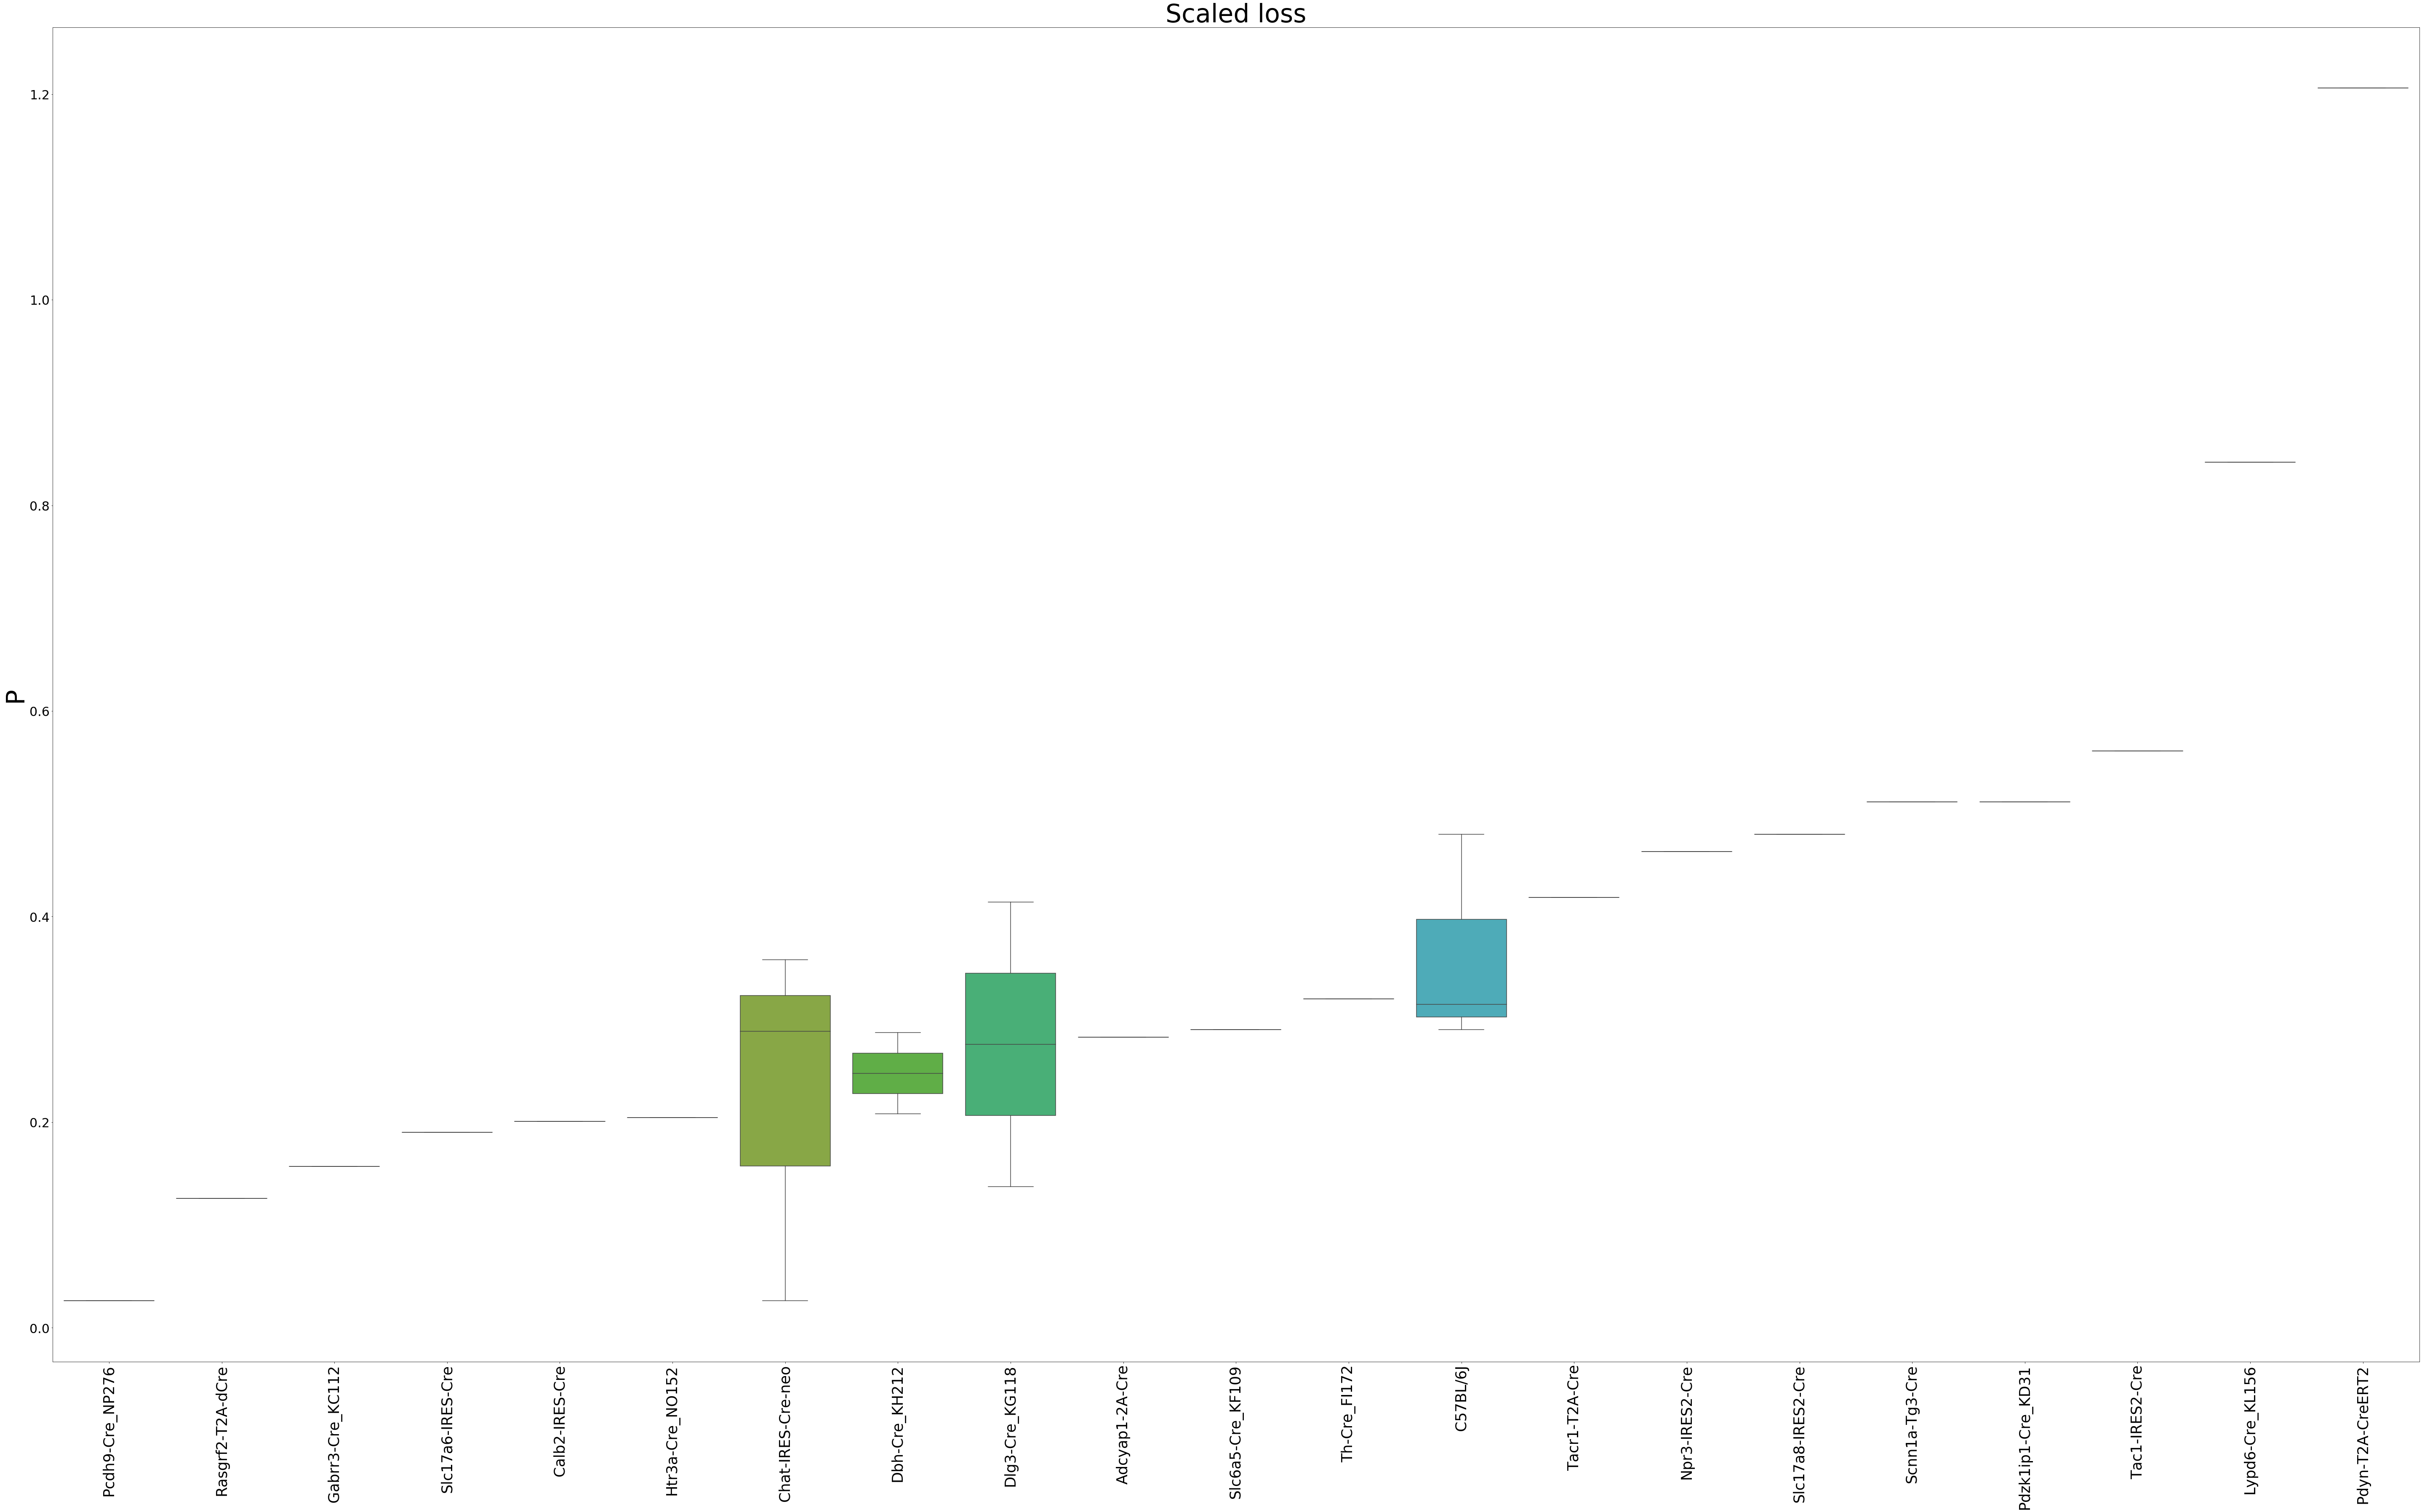

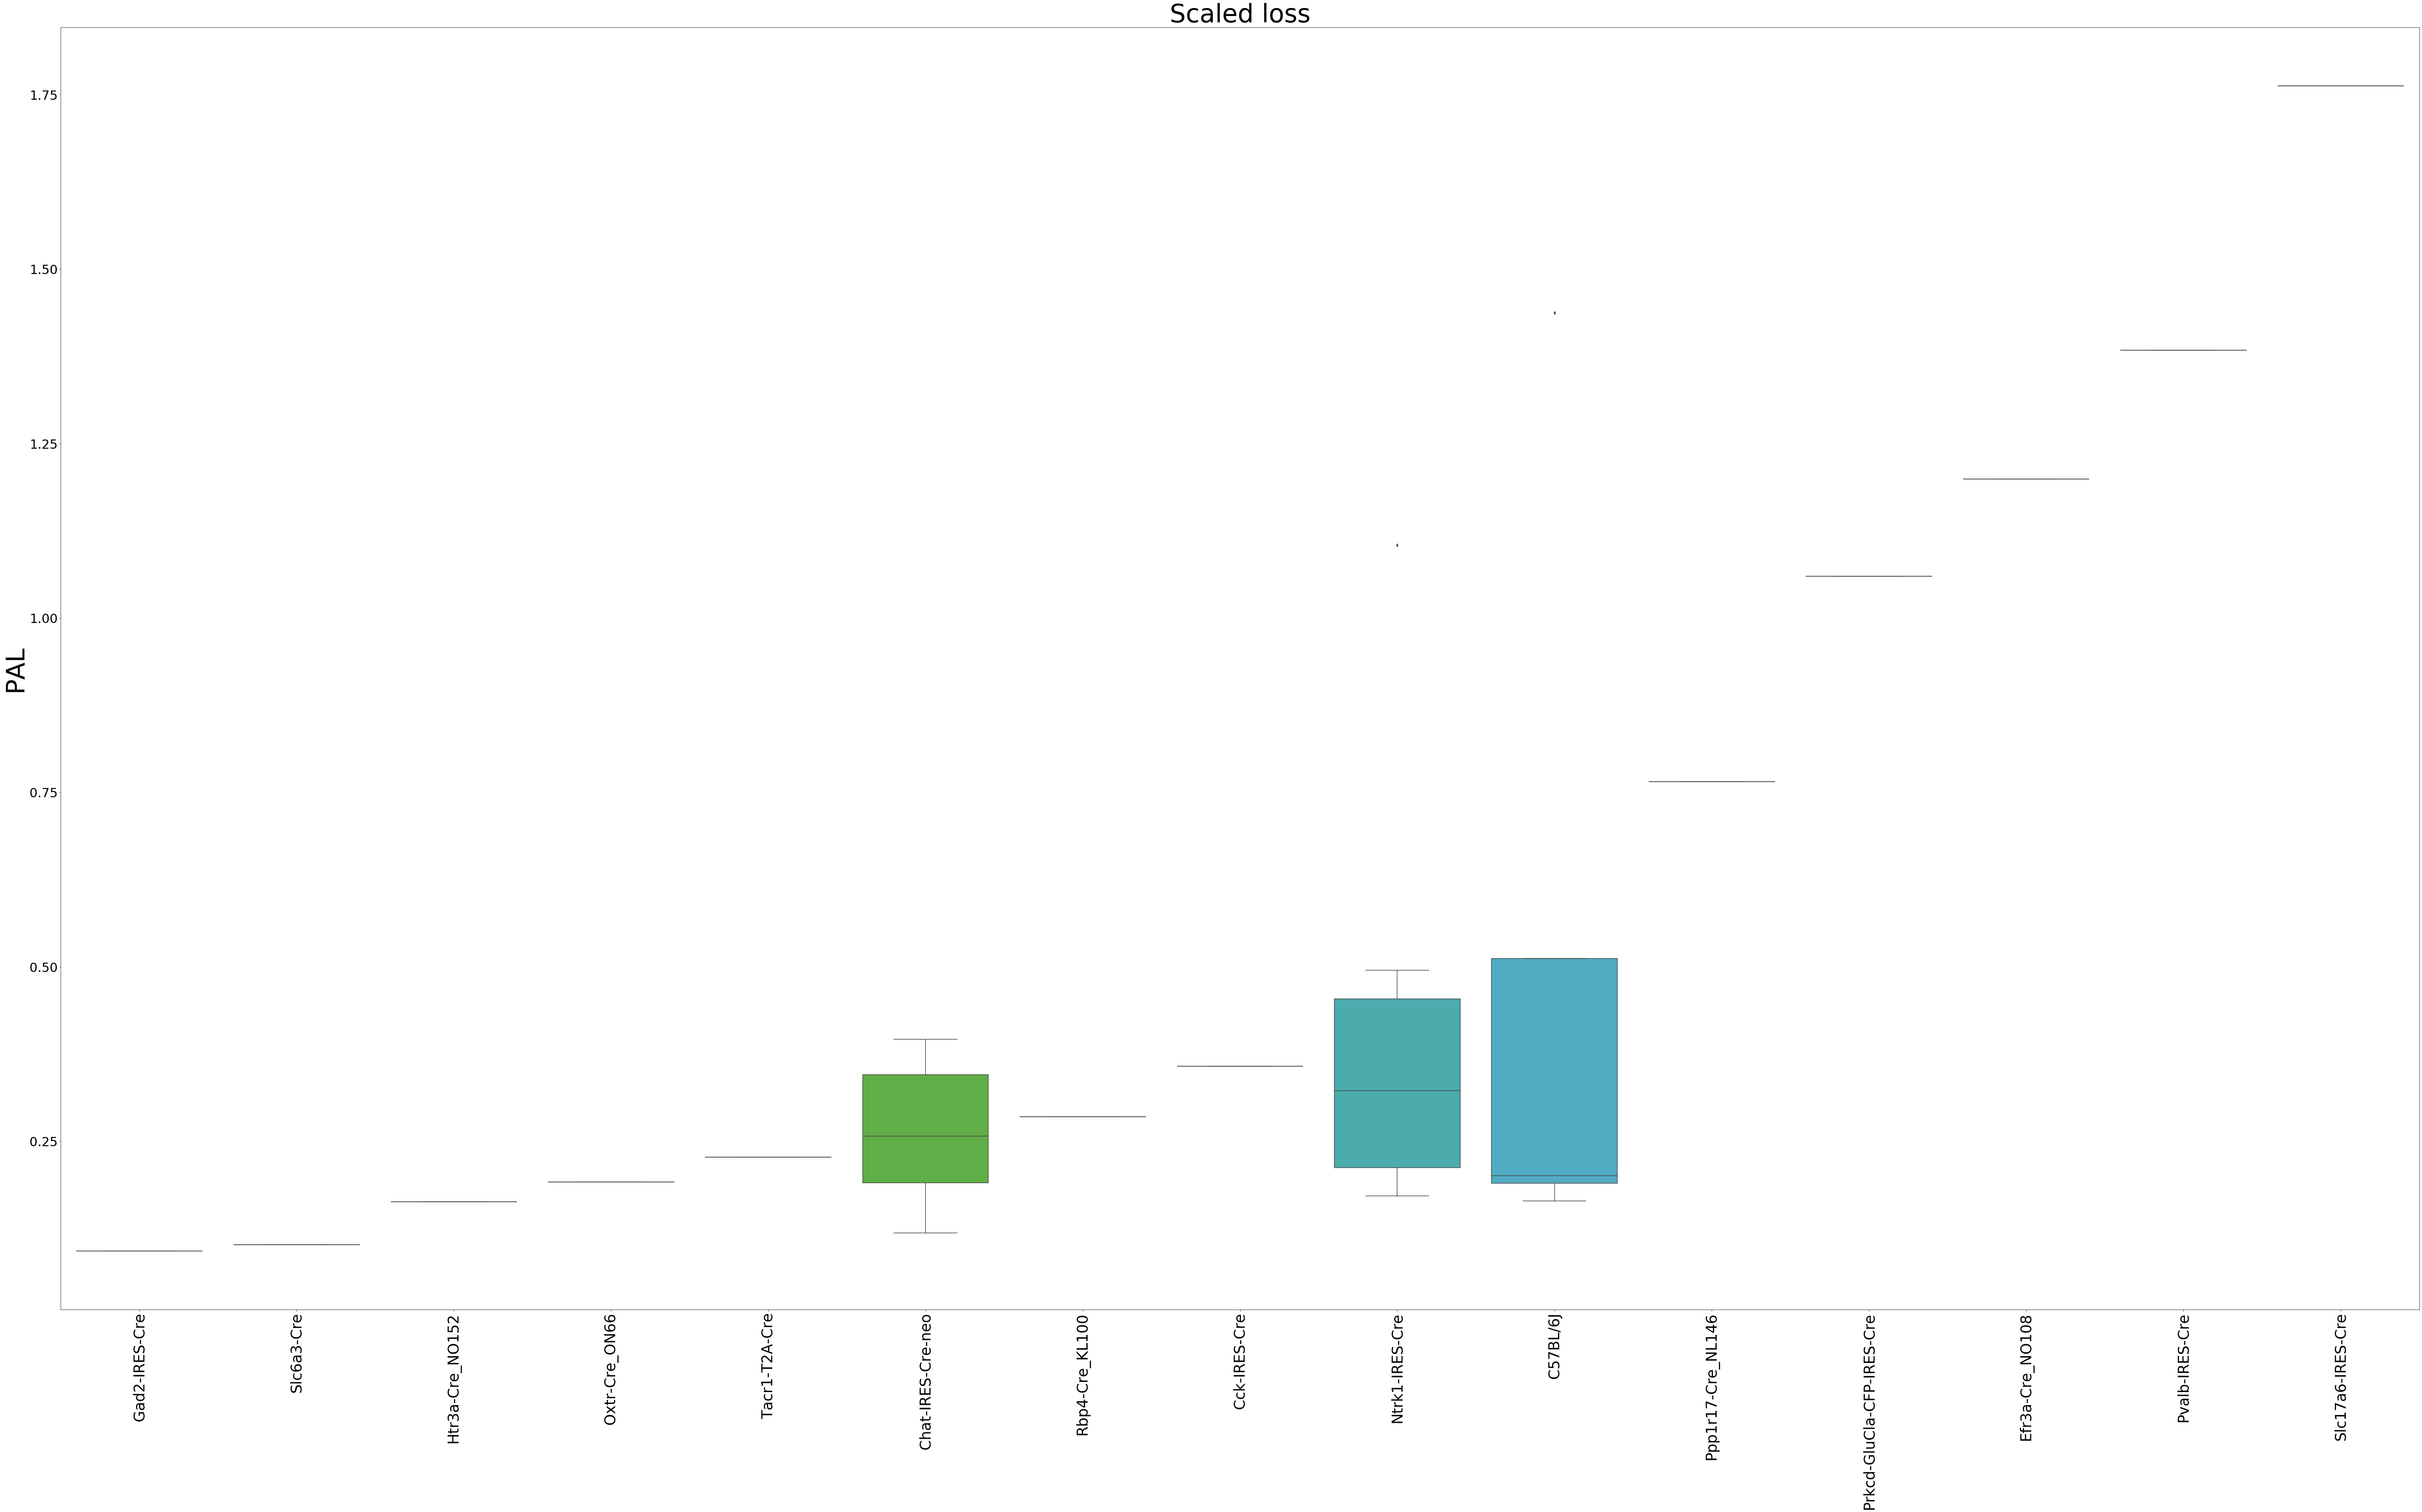

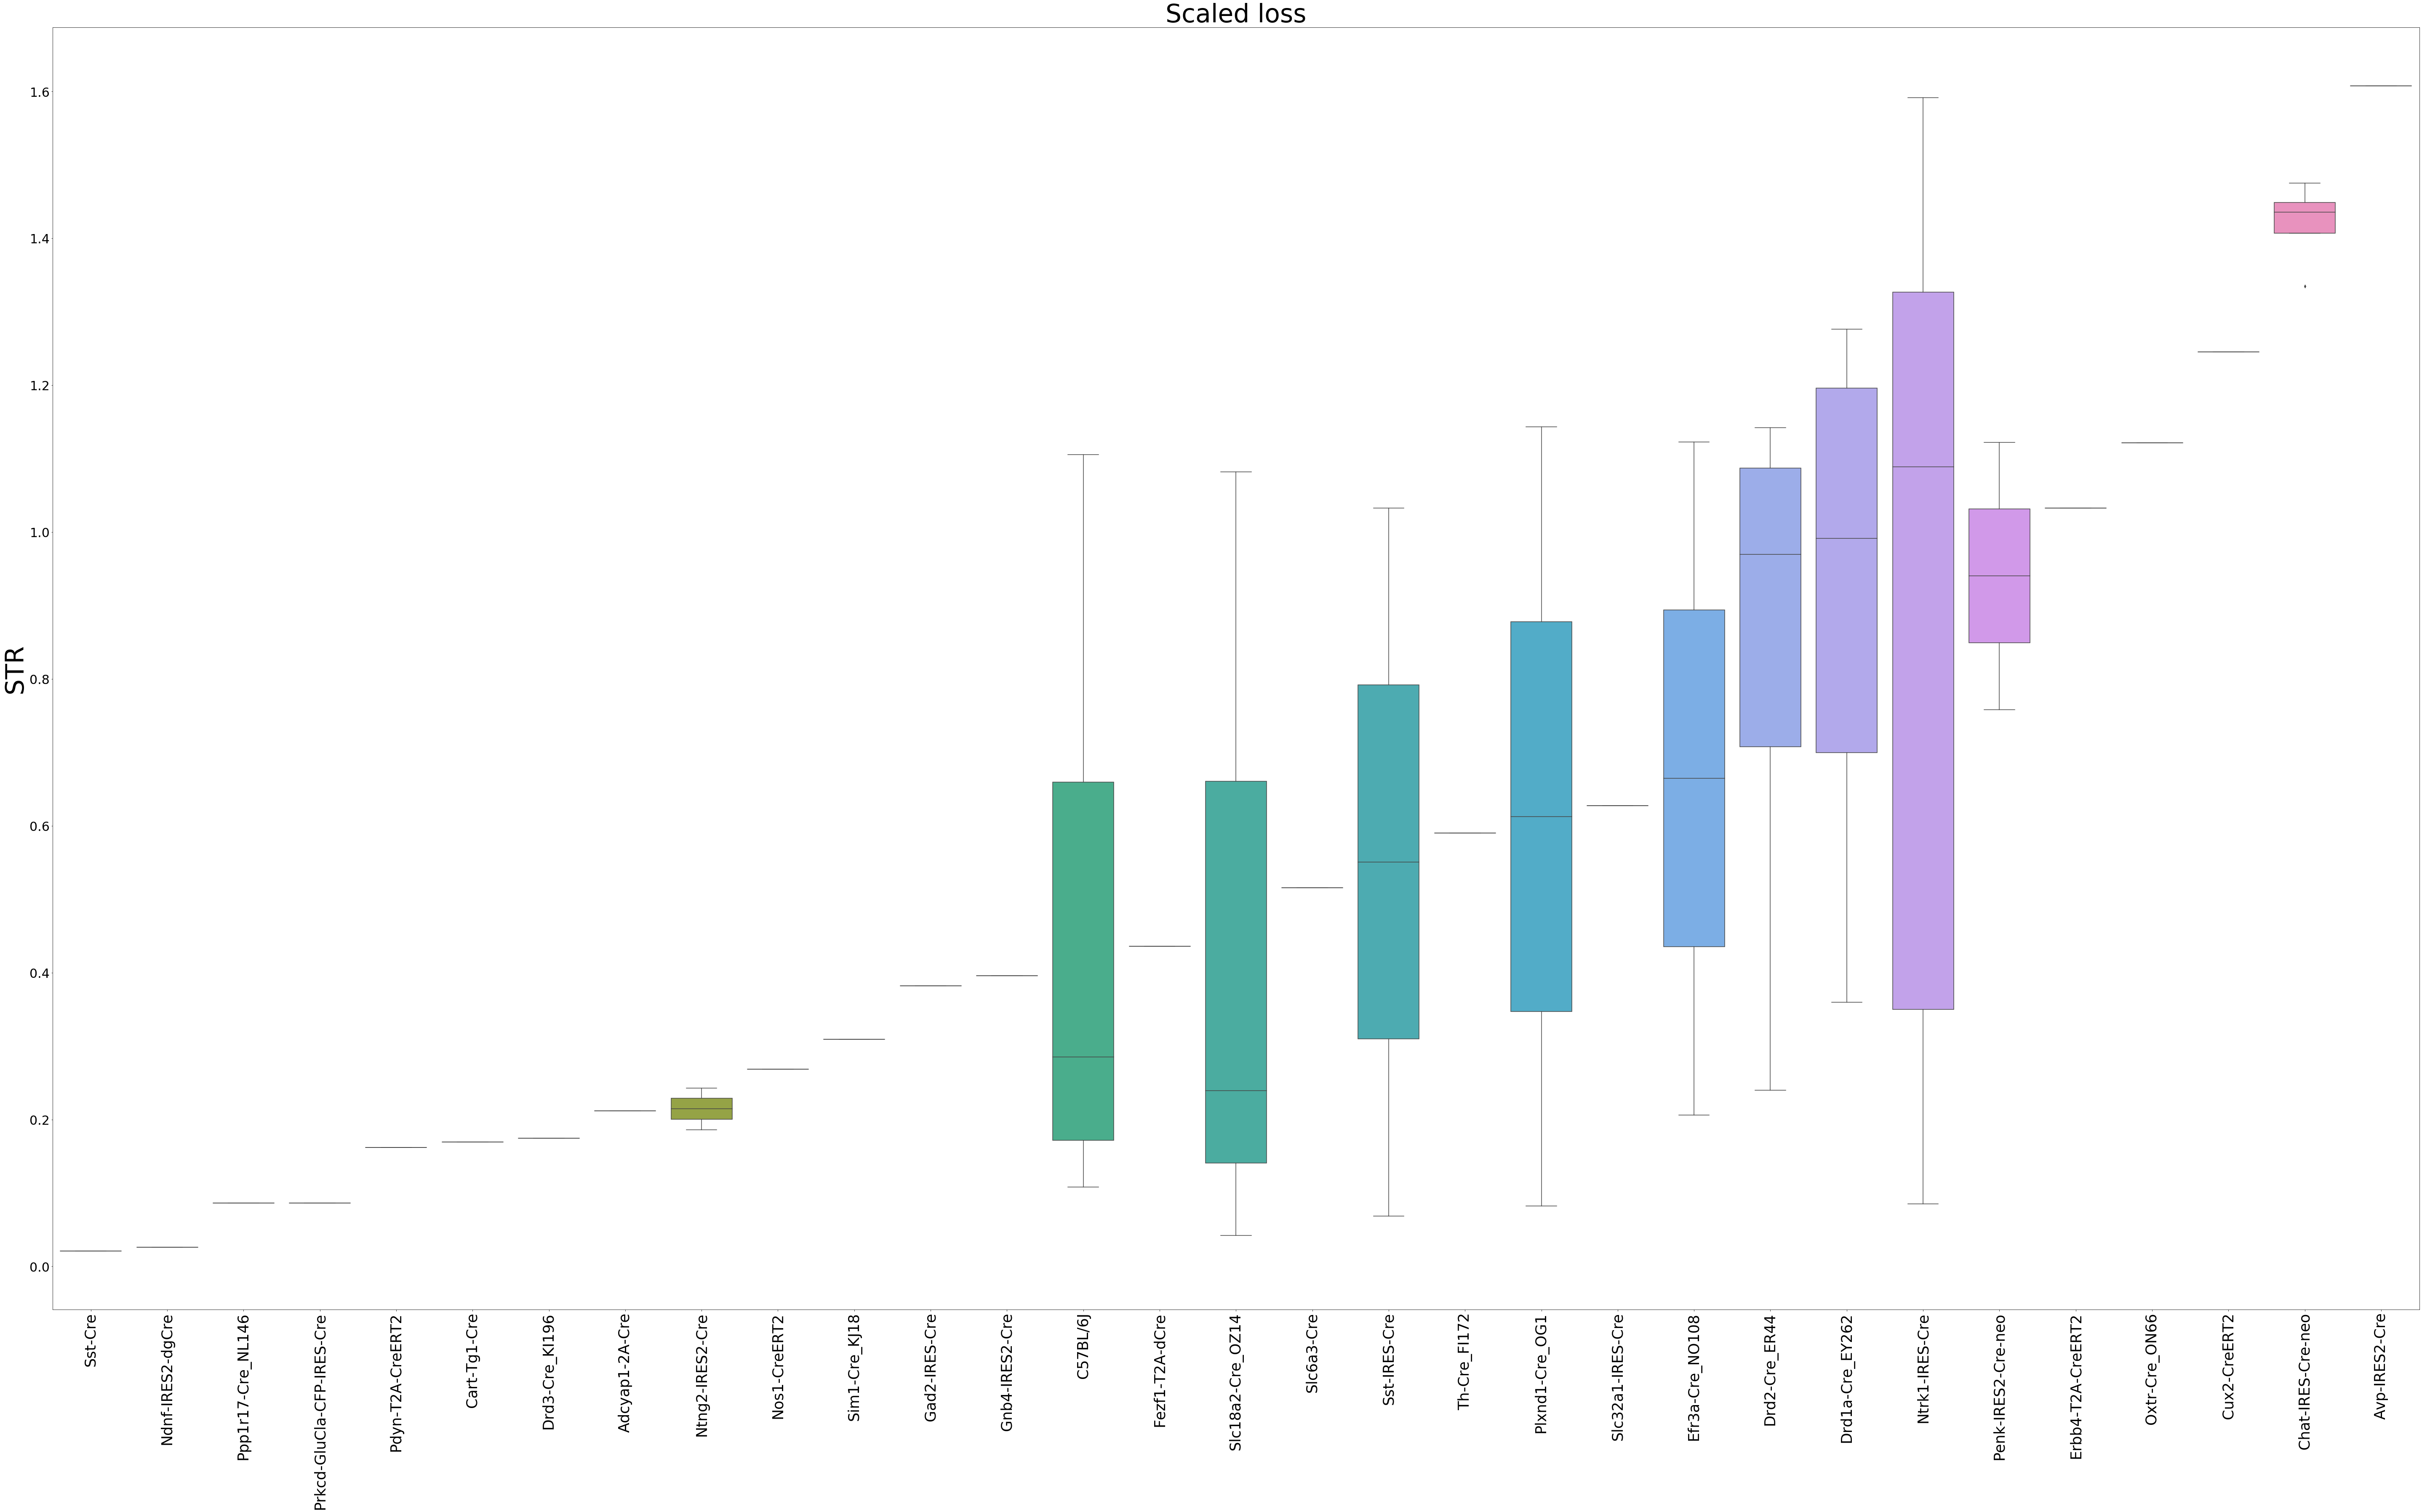

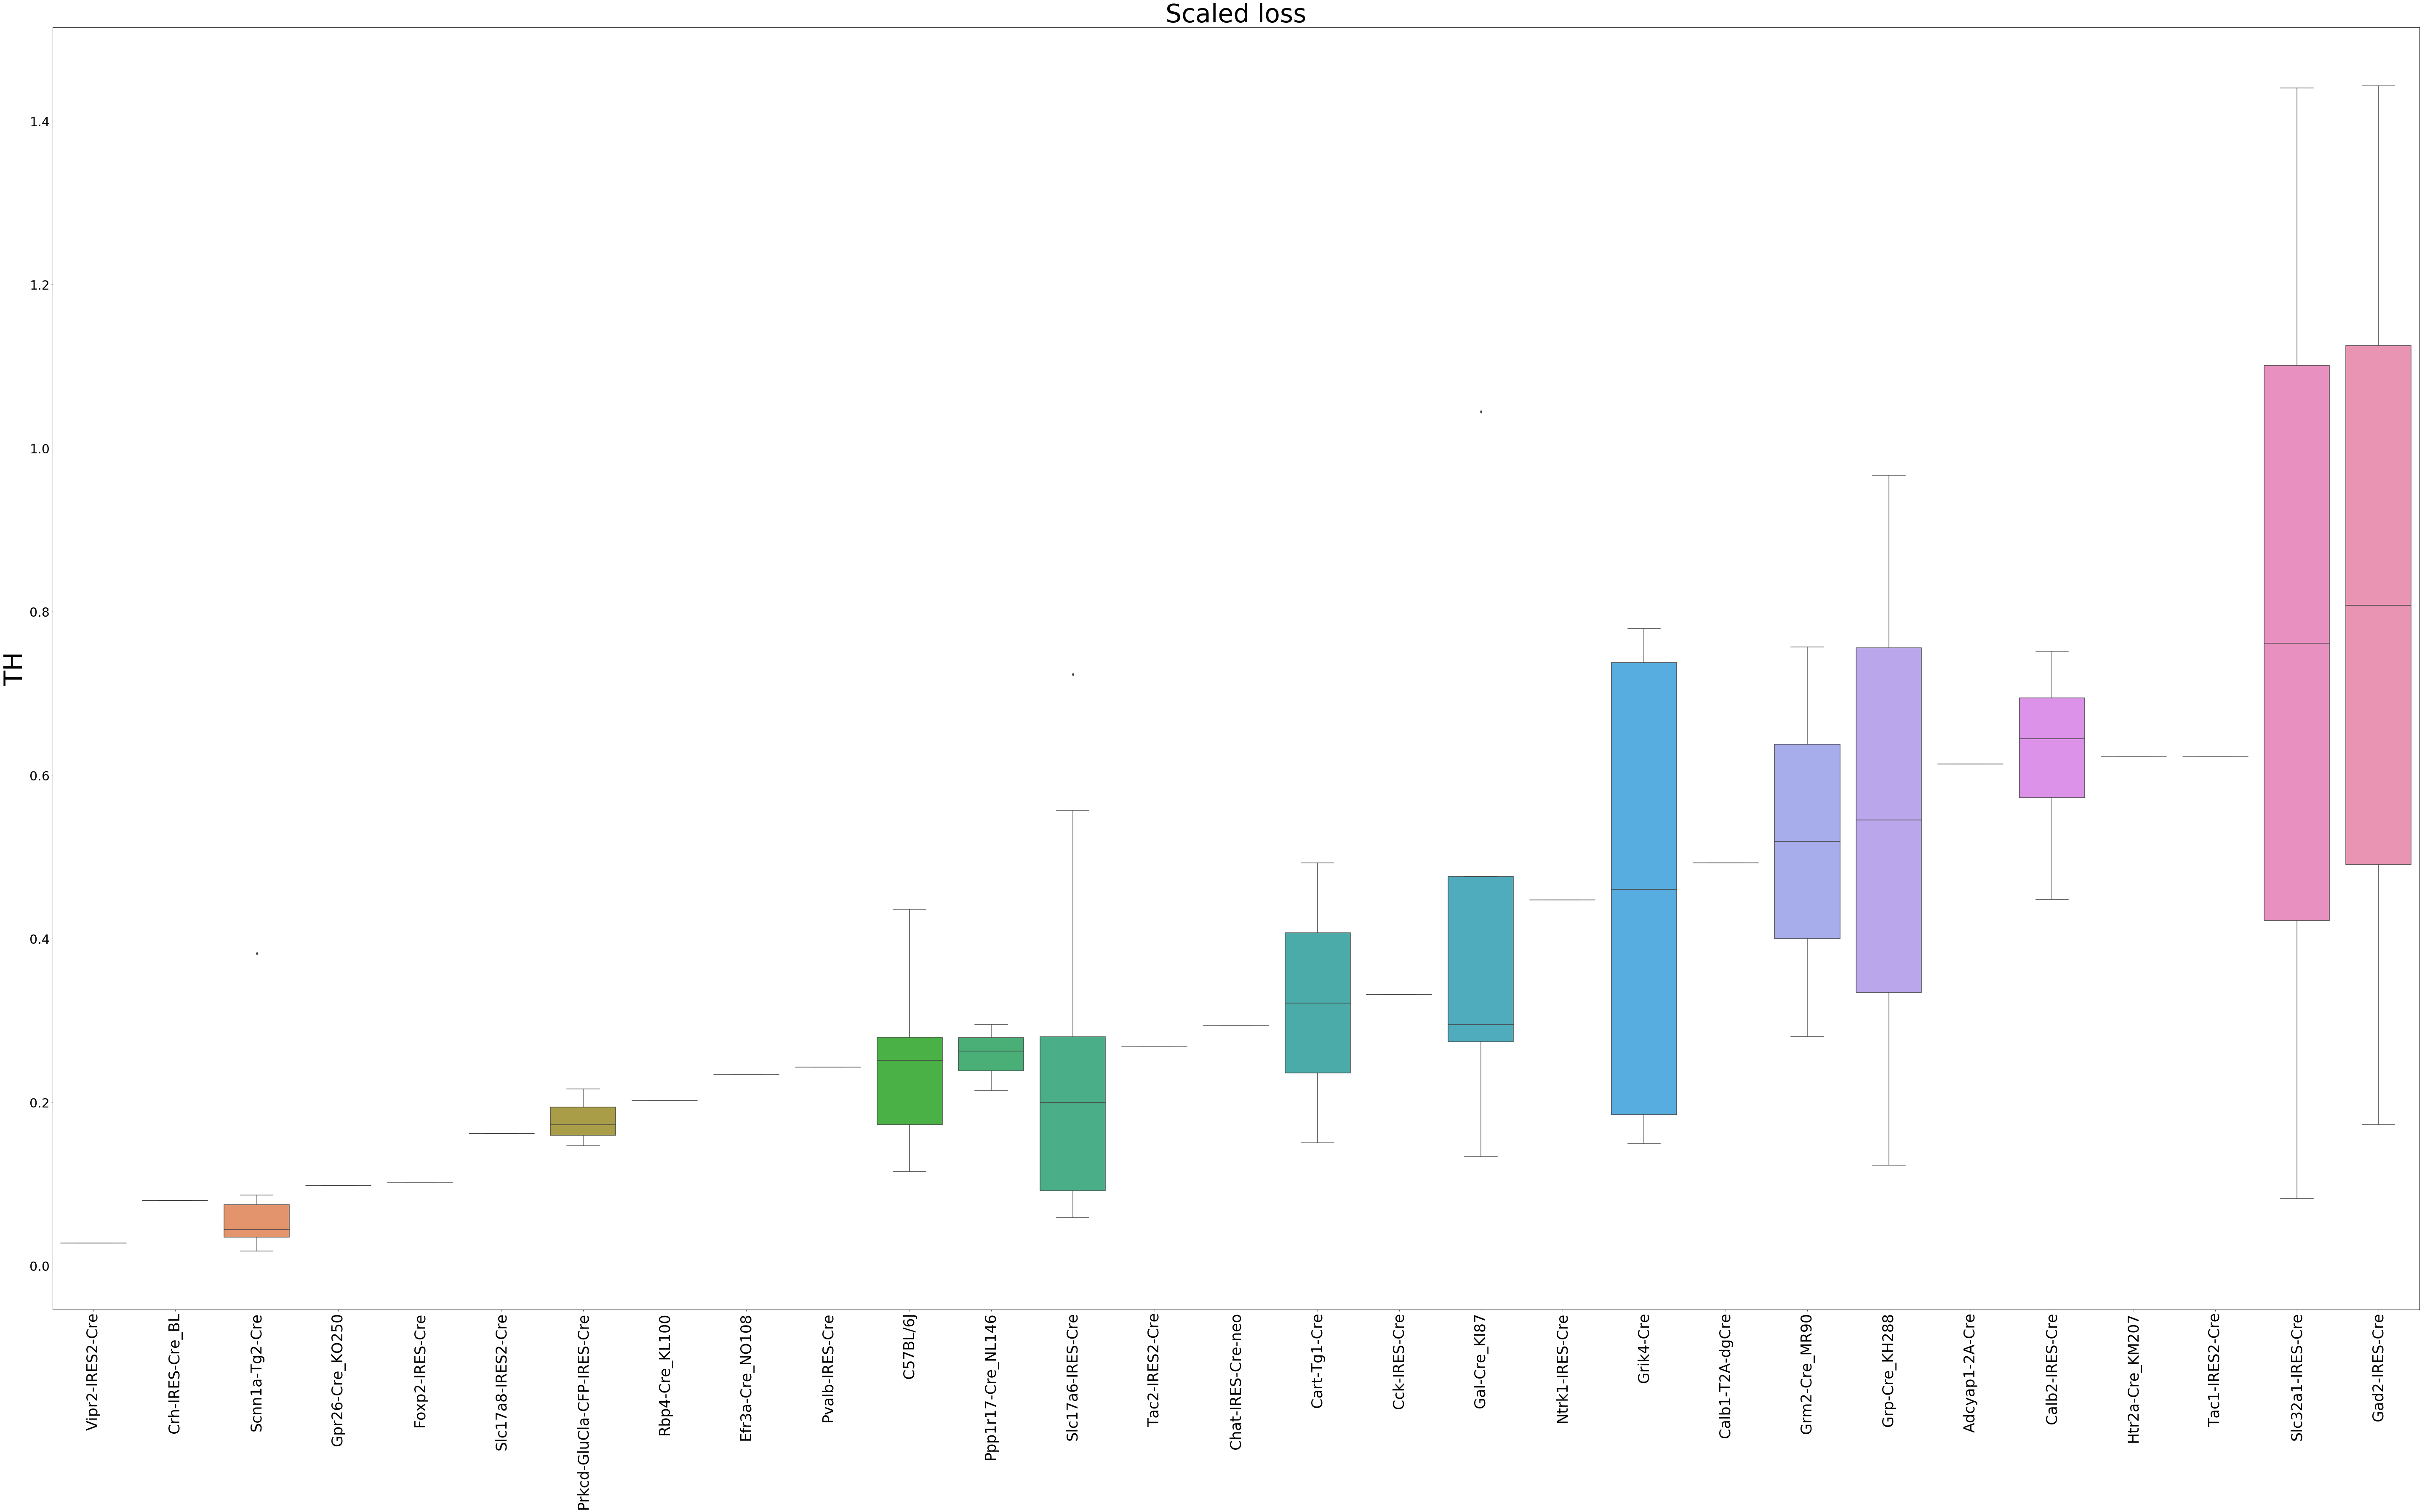

In [386]:
%matplotlib inline
nms = len(major_structure_ids)

#for m in range(1):
for m in range(nms):
    print(m)
    fig, ax = plt.subplots(1,1, figsize = (80,50))
    sid = major_structure_ids[m]
#     sns.boxplot(x = creline[sid], y = paperlosses_all[sid][selected_gamma_all[m]], ax=axes[m,0])
#     axes[m,0].set_xticklabels(axes[m,0].get_xticklabels(), rotation=90, fontsize = 35)
#     #axes[m,0].set_yticklabels(axes[m,0].get_yticklabels(), fontsize = 40)
#     axes[m,0].tick_params(axis='y', which='major', labelsize=30)
#     #axes[m,0].set_xl
#     axes[m,0].set_ylabel(major_structures[m], fontsize = 60)
    losses_bycre = pd.DataFrame(np.asarray([losses_finestall[sid][sel_ga_all[m,0]], creline[sid][finest_twoormore[sid]]]).transpose())
    losses_bycre = losses_bycre.astype({0: np.float64})
    order = np.unique(losses_bycre[1])[losses_bycre.groupby(by=[1])[0].mean().argsort()]
    sns.boxplot(x = creline[sid][finest_twoormore[sid]], y = losses_finestall[sid][sel_ga_all[m,0]], ax=ax, order = order)
    #axes[m,1].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = 35)
    #axes[m,0].set_xl
    ax.tick_params(axis='y', which='major', labelsize=30)
    ax.set_ylabel(major_structures[m], fontsize = 60)
    
#     sns.boxplot(x = creline[sid], y = paperlosses_all_reg[sid][selected_gamma_all_reg[m]], ax=axes[m,2])
#     #axes[m,2].set_yticklabels(axes[m,2].get_yticklabels(), fontsize = 40)
#     axes[m,2].set_xticklabels(axes[m,2].get_xticklabels(), rotation=90, fontsize = 35)
#     axes[m,2].tick_params(axis='y', which='major', labelsize=30)
#     #axes[m,0].set_xl
#     axes[m,2].set_ylabel(major_structures[m], fontsize = 60)
    
    ax.set_title('Scaled loss', fontsize = 60)
    plt.tight_layout() 
    plt.savefig('/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/analyses/creloss' + major_structures[m])
    #axes[0,1].set_title('All-normalized-voxelloss', fontsize = 60)
    #axes[0,2].set_title('All-regionalloss', fontsize = 60)
    #add losses for crenorm

In [ ]:
orders = {}
for m in range(nms):
    print(m)
    sid = major_structure_ids[m]
#     sns.boxplot(x = creline[sid], y = paperlosses_all[sid][selected_gamma_all[m]], ax=axes[m,0])
#     axes[m,0].set_xticklabels(axes[m,0].get_xticklabels(), rotation=90, fontsize = 35)
#     #axes[m,0].set_yticklabels(axes[m,0].get_yticklabels(), fontsize = 40)
#     axes[m,0].tick_params(axis='y', which='major', labelsize=30)
#     #axes[m,0].set_xl
#     axes[m,0].set_ylabel(major_structures[m], fontsize = 60)
    losses_bycre = pd.DataFrame(np.asarray([losses_finestall[sid][sel_ga_all[m,0]], creline[sid][finest_twoormore[sid]]]).transpose())
    losses_bycre = losses_bycre.astype({0: np.float64})
    order = np.unique(losses_bycre[1])[losses_bycre.groupby(by=[1])[0].mean().argsort()]
    orders[sid] = order

In [368]:
import scipy

In [379]:
losses = losses_finestall[sid][sel_ga_all[m,0]]
cre_unique= np.unique(creline[sid][finest_twoormore[sid]])
output = np.zeros(len(cre_unique))
for n in range(len(np.unique(creline[sid][finest_twoormore[sid]]))):
    print(n)
    creids = np.where(creline[sid][finest_twoormore[sid]] == cre_unique[n])[0]
    wtids = np.where(creline[sid] == 'C57BL/6J')[0]
    test= scipy.stats.ttest_ind(losses[creids], losses[creids], equal_var = False)
    output[n] = test.pvalue

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [380]:
output

array([nan,  1., nan,  1.,  1., nan, nan, nan, nan, nan,  1.,  1., nan,
        1.,  1.,  1., nan, nan,  1.,  1., nan, nan,  1.,  1., nan,  1.,
       nan, nan, nan])

In [378]:
test.pvalue

nan

In [ ]:
for sid in major_structure_ids:
    msvds[sid].loocv_predictions_creleaf = get_loocv_predictions_code(projections = msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                 centroids = msvds[sid].centroids,
                                                                 gammas = gammas,
                                                                 codes=goodcreleafs)


In [350]:
    losses_bycre = pd.DataFrame(np.asarray([losses_finestall[sid][sel_ga_all[m,0]], creline[sid][finest_twoormore[sid]]]).transpose())
    losses_bycre = losses_bycre.astype({0: np.float64})
      


In [358]:
help(sns.boxplot)

Help on function boxplot in module seaborn.categorical:

boxplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5, notch=False, ax=None, **kwargs)
    Draw a box plot to show distributions with respect to categories.
    
    A box plot (or box-and-whisker plot) shows the distribution of quantitative
    data in a way that facilitates comparisons between variables or across
    levels of a categorical variable. The box shows the quartiles of the
    dataset while the whiskers extend to show the rest of the distribution,
    except for points that are determined to be "outliers" using a method
    that is a function of the inter-quartile range.
    
    
    Input data can be passed in a variety of formats, including:
    
    - Vectors of data represented as lists, numpy arrays, or pandas Series
      objects passed directly to the ``x``, ``y``, and/or ``

In [ ]:
order = losses_bycre.groupby(by=[1])[0].mean().iloc[::-1].index  

In [349]:
losses_finestall[sid][sel_ga_all[m,0]][np.where(creline[sid][finest_twoormore[sid]] == 'Adcyap1-2A-Cre')[0]]

array([0.61356623])

In [348]:
losses_finestall[sid][sel_ga_all[m,0]][np.where(creline[sid][finest_twoormore[sid]] == 'C57BL/6J')[0]]

array([0.26112202, 0.15427619, 0.27955778, 0.331852  , 0.33152382,
       0.23528963, 0.43603394, 0.17227802, 0.13750749, 0.23968009,
       0.25103731, 0.26432292, 0.1153221 ])

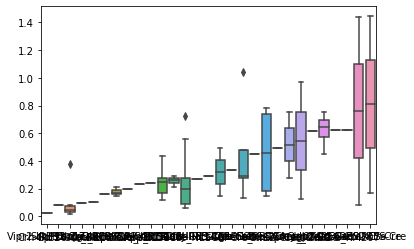

In [363]:
sns.boxplot(x = creline[sid][finest_twoormore[sid]], y = losses_finestall[sid][sel_ga_all[m,0]], order = np.unique(losses_bycre[1])[losses_bycre.groupby(by=[1])[0].mean().argsort()])
    

array(['Adcyap1-2A-Cre', 'C57BL/6J', 'Calb1-T2A-dgCre', 'Calb2-IRES-Cre',
       'Cart-Tg1-Cre', 'Cck-IRES-Cre', 'Chat-IRES-Cre-neo',
       'Crh-IRES-Cre_BL', 'Efr3a-Cre_NO108', 'Foxp2-IRES-Cre',
       'Gad2-IRES-Cre', 'Gal-Cre_KI87', 'Gpr26-Cre_KO250', 'Grik4-Cre',
       'Grm2-Cre_MR90', 'Grp-Cre_KH288', 'Htr2a-Cre_KM207',
       'Ntrk1-IRES-Cre', 'Ppp1r17-Cre_NL146', 'Prkcd-GluCla-CFP-IRES-Cre',
       'Pvalb-IRES-Cre', 'Rbp4-Cre_KL100', 'Scnn1a-Tg2-Cre',
       'Slc17a6-IRES-Cre', 'Slc17a8-IRES2-Cre', 'Slc32a1-IRES-Cre',
       'Tac1-IRES2-Cre', 'Tac2-IRES2-Cre', 'Vipr2-IRES2-Cre'],
      dtype=object)

In [343]:
order

Index(['Vipr2-IRES2-Cre', 'Tac2-IRES2-Cre', 'Tac1-IRES2-Cre',
       'Slc32a1-IRES-Cre', 'Slc17a8-IRES2-Cre', 'Slc17a6-IRES-Cre',
       'Scnn1a-Tg2-Cre', 'Rbp4-Cre_KL100', 'Pvalb-IRES-Cre',
       'Prkcd-GluCla-CFP-IRES-Cre', 'Ppp1r17-Cre_NL146', 'Ntrk1-IRES-Cre',
       'Htr2a-Cre_KM207', 'Grp-Cre_KH288', 'Grm2-Cre_MR90', 'Grik4-Cre',
       'Gpr26-Cre_KO250', 'Gal-Cre_KI87', 'Gad2-IRES-Cre', 'Foxp2-IRES-Cre',
       'Efr3a-Cre_NO108', 'Crh-IRES-Cre_BL', 'Chat-IRES-Cre-neo',
       'Cck-IRES-Cre', 'Cart-Tg1-Cre', 'Calb2-IRES-Cre', 'Calb1-T2A-dgCre',
       'C57BL/6J', 'Adcyap1-2A-Cre'],
      dtype='object', name=1)

In [341]:
losses_bycre.groupby(by=[1])[0].mean().iloc[::-1].index 

Index(['Slc17a6-IRES-Cre', 'Scnn1a-Tg3-Cre', 'Pvalb-IRES-Cre',
       'Ppp1r17-Cre_NL146', 'Pcp2-Cre_GN135', 'Ntsr1-Cre_GN220',
       'Nos1-CreERT2', 'Htr2a-Cre_KM207', 'Grm2-Cre_MR90', 'Grik4-Cre',
       'Gpr26-Cre_KO250', 'Gad2-IRES-Cre', 'Gabra6-IRES-Cre',
       'Efr3a-Cre_NO108', 'C57BL/6J'],
      dtype='object', name=1)

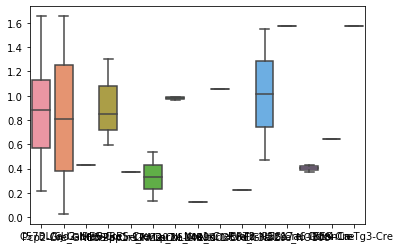

In [291]:
sns.boxplot(x = creline[sid][finest_twoormore[sid]], y = losses_finestall[sid][sel_ga_all[m,0]])

In [288]:
creline[sid][finest_twoormore[sid]].shape

(31,)

In [125]:
mean_nw_all = get_loss_best_hyp(losses_finestall, sel_ga_all)
mean_nw_allwt = get_loss_best_hyp(losses_finestallwts, sel_ga_all)
mean_nw_wt = get_loss_best_hyp(losses_finest_wtwts, sel_ga_wt)


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:263: RuntimeWarning: Mean of empty slice
  output[m] = np.nanmean(losses[sid][hyps[m], :])


In [126]:
mean_nw_allwt

array([0.86154886,        nan, 0.19198754, 0.1610887 , 0.34008342,
       0.30939897, 0.33194044, 0.19114975, 0.36148173, 0.50065412,
       0.43034572, 0.24690795])

In [128]:
losses_finestallwts[512][0].max()

1.654258786806861

In [382]:

# losses_all = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = allfinest_twoormore, true_ind = allfinest_twoormore,keys = keys)
# losses_wts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_wt,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)
# losses_allwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = wt_2ormore, true_ind = wt_2ormore, keys = keys)
# losses_cre = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = crefinest_twoormore, true_ind = crefinest_twoormore, keys = keys)
#losses_finecre = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_allfiner,pred_ind = crefiner_twoormore, true_ind = crefiner_twoormore, keys = keys)
#losses_majorcre = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_allmajor,pred_ind = cremajor_twoormore, true_ind = cremajor_twoormore, keys = keys)

#sel_ga_all = get_best_hyperparameters(losses_all,keys)
#sel_ga_allwt = sel_ga_all#get_gamma(losses_allwt,keys)

#mean_nw_all = get_loss_best_hyp(losses_all, sel_ga_all)
#mean_nw_allwt = get_loss_best_hyp(losses_allwts, sel_ga_all)
#mean_nw_wt = get_loss_best_hyp(losses_all, sel_ga_wt)

print(mean_nw_all)
print(mean_nw_allwt)
print(mean_nw_wt)
losses = np.asarray([mean_nw_all, 
           mean_nw_allwt,mean_nw_wt]).transpose()
losses2 = losses[[4,7,2,1,10,9,11,3,5,8,6,0]]
loss =pd.DataFrame(losses2, columns = ['all','allwt','wt'])

[0.78692754 0.29068181 0.35803372 0.27034826 0.44147834 0.49263346
 0.31888494 0.3827807  0.34821835 0.49121184 0.64899939 0.3360901 ]
[0.86154886        nan 0.19198754 0.1610887  0.34008342 0.30939897
 0.33194044 0.19114975 0.36148173 0.50065412 0.43034572 0.24690795]
[0.23437622        nan 0.25052767 0.15654909 0.16293599 0.1784922
 0.31883125 0.09983318        nan 0.16222868 0.52523973 0.29401735]


In [18]:
mean_nw_all

NameError: name 'mean_nw_all' is not defined

In [19]:
homo_loocv_predictions_all

NameError: name 'homo_loocv_predictions_all' is not defined

In [ ]:
#compare homo and nw_leaf

In [81]:
wt_2ormore

{512: array([ 0,  3,  9, 11, 17, 21, 22, 24, 27, 29, 30, 35]),
 703: array([], dtype=int64),
 1089: array([  0,   2,  11,  23,  25,  34,  38,  39,  47,  49,  51,  59,  65,
         70,  72,  74,  83,  87,  90,  98, 103, 104, 116, 117, 120, 121]),
 1097: array([35, 47, 51, 58, 59, 69]),
 315: array([   9,   13,   33,   41,   74,   81,   93,  101,  116,  120,  121,
         131,  148,  151,  158,  202,  237,  241,  254,  255,  257,  258,
         275,  282,  285,  286,  305,  314,  321,  330,  331,  346,  348,
         354,  360,  366,  381,  394,  398,  410,  421,  427,  429,  433,
         441,  444,  447,  458,  479,  492,  512,  523,  540,  546,  558,
         566,  573,  586,  596,  601,  623,  630,  632,  676,  681,  688,
         696,  697,  701,  710,  712,  749,  755,  765,  772,  778,  800,
         801,  807,  811,  816,  826,  829,  834,  853,  863,  865,  873,
         883,  893,  913,  920,  922,  923,  926,  947,  948,  951,  954,
         965,  981,  998, 1001, 1006, 1015

In [78]:
None is None

True

In [59]:
homo_loocv_predictions_all[549].shape

(5, 83, 577)

In [17]:
mean_nw_all

NameError: name 'mean_nw_all' is not defined

In [ ]:
def get_nw_loocv2(msvd, hyperparameters, groups):

    if len(indices) > 1:
        projections = msvd.reg_proj_vcount_norm_renorm
        centroids = msvd.centroids
        nreg = projections.shape[1]
        nexp = projections.shape[0]
        nhyp = hyperparameters.shape[0]
        loocv_predictions = np.zeros((nhyp, nexp, nreg))
        for g in range(nhyp):
            loocv_predictions[g, indices] = get_loocv_predictions_code(projections[indices], centroids[indices], hyperparameters[g],groups)
        return (loocv_predictions)
    else:
        return (np.asarray([]))


In [48]:
wildtype = creline.copy()

In [49]:
for sid in major_structure_ids:
    wildtype[sid][np.where(wildtype[sid]) != 'C57BL/6J'] = 'Cre'

In [ ]:
def get_loocv_predictions(projections, centroids, gamma):
    projections = np.asarray(projections, dtype=np.float32)
    nexp = centroids.shape[0]
    predictions = projections.copy()
    weights = get_weights(centroids, gamma)

    for i in range(nexp):
        otherindices = np.setdiff1d(np.asarray(list(range(nexp))), i)
        weights_i = weights[i] / weights[i][otherindices].sum()
        weights_i[i] = 0
        weights_i = np.asarray(weights_i, dtype=np.float32)
        pred = np.dot(weights_i, projections)
        predictions[i] = pred

    return (predictions)

In [18]:
losses_all[512][0]

array([0.34166852, 1.02488828, 0.42989263, 1.91087252, 0.36760405,
       0.37124295, 0.37403708, 0.2014561 , 1.04634096, 1.64569044,
       1.92118108, 0.21727991, 0.12731065, 1.31945597, 1.05709393,
       0.03828835, 0.22249691, 1.64916624, 0.35433854, 0.77214151,
       1.55328598, 1.17894373, 1.94892277, 0.42803765, 0.63522155,
       0.64247565, 0.60203188, 1.01437851, 0.39306433, 0.56134609,
       1.85766596, 0.53469826, 1.57203338, 1.32763251, 1.24350352,
       1.54951339])

In [16]:
# exps = np.asarray(data_info.index.values , dtype = np.int)
# creline = {}
# for sid in major_structure_ids:
#     msvd = msvds[sid]
#     experiment_ids = np.asarray(list(msvd.experiments.keys()))
#     nexp = len(experiment_ids)
#     creline[sid] = np.zeros(nexp, dtype = object)
#     for i in range(len(experiment_ids)):
#         index = np.where(exps == experiment_ids[i])[0][0]
#         creline[sid][i] = data_info['transgenic-line'].iloc[index]
ngam  = 5
#inds_bad are where there is no injection
#we can use these to train but shouldnt to evaluate
#the 'wt_ind' should just be 'eval_ind'
inds_bad = {}
inds_good = {}
for sid in major_structure_ids:
    injections = msvds[sid].injections 
    inds_bad[sid] = np.where(injections.sum(axis = 1) == 0.)[0]
    inds_good[sid] = np.where(injections.sum(axis = 1) > 0.)[0]
    
nms = len(major_structure_ids)
#ngam = len(gammas)
wt_2ormore = {}
losses_reg_norm = np.zeros((nms,ngam))
inds_good_wt = {}
inds_good_wtsub = {}
for m in range(nms):
    sid = major_structure_ids[m]
    wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
    wt_2ormore[sid] = np.asarray([])
    #wt_2ormore is the indices of when there are 2 or more wild types
    if len(wt_inds) > 1:
        wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
    wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)
    inds_good_wt[sid] = np.intersect1d(wt_2ormore[sid], inds_good[sid])
    inds_good_wtsub[sid] = np.where(np.isin(wt_2ormore[sid], inds_good[sid]))[0]

In [11]:
print(sel_ga_all,'a', sel_ga_allwt)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [4]
 [4]
 [0]
 [0]
 [1]] a [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [4]
 [4]
 [0]
 [0]
 [1]]


In [7]:
loss

all     allwt
0   0.430291  0.283858
1   0.446265  0.217779
2   0.359464  0.261242
3   0.777379       NaN
4   0.690856  0.482598
5   0.530277  0.500712
6   0.428704  0.348522
7   0.293773  0.268651
8   0.471360  0.264173
9   0.456570  0.576325
10  0.409765  0.396175
11  0.900978  1.209222

In [8]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    

In [10]:

name = 'leafsum_nw_0720'
expfolder = workingdirectory +   '/data/' + name
os.mkdir(expfolder)
loss.to_csv(expfolder + 'losses')

#msvds_save = {}
for sid in major_structure_ids:
    np.save(expfolder +'/'+ str(sid) + 'reg_proj_vcount_norm_renorm',msvds[sid].reg_proj_vcount_norm_renorm)
    np.save(expfolder +'/'+ str(sid) + 'loocv_predictions_all',msvds[sid].loocv_predictions_all)
    np.save(expfolder +'/'+ str(sid) + 'loocv_predictions_wt',msvds[sid].loocv_predictions_wt)
    
with open(expfolder +'/'+ 'wt_2ormore_base.pickle', 'wb') as handle:
    pickle.dump(wt_2ormore, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
ontological_order_leaf = get_ontological_order_leaf(leafs, ontological_order, st)
source_exp_countvec, source_exp_countvec_wt = get_countvec(ontological_order, ia_map, creline, experiments_minor_structures)
hyperparameters = gammas[sel_ga_all]
#leavves v ontological_order_leaf
#leavves is the leaves associated with ontological_order
#ontological_order_leaf is the leaves that are actually present
#leafs is the dictionary with the leaves of the experiments
df = get_connectivity(msvds, cache, ia_map, hyperparameters, ontological_order_leaf, ontological_order, leafs, creline,experiments_minor_structures, ipsi_key, contra_key)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
42
43
44
45
46
48
49
51
53
54
56
57
60
61
62
63
64
65
66
69
70
72
73
74
76
77
78
84
86
87
88
89
91
92
93
94
96
97
98
100
102
106
107
108
109
112
113
116
117
118
119
120
122
123
124
126
127
129
130
132
134
135
136
138
141
144
145
151
154
157
158
160
162
163
165
166
167
168
169
172
174
175
176
177
178
183
184
186
187
188
189
192
196
197
204
206
209
210
212
213
216
217
218
221
222
223
225
226
227
230
232
233
235
237
239
240
242
243
246
247
249
250
253
257
260
265
266
269
273
275
276
279
281
282
283
284
286
288
289
290
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


1
2
3


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


4


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


5


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


6
7


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


8


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


0


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


1


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


2
3
4


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


5


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


6
7
8
9
10
11


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/core/utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / weights.sum(axis=0)


12
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


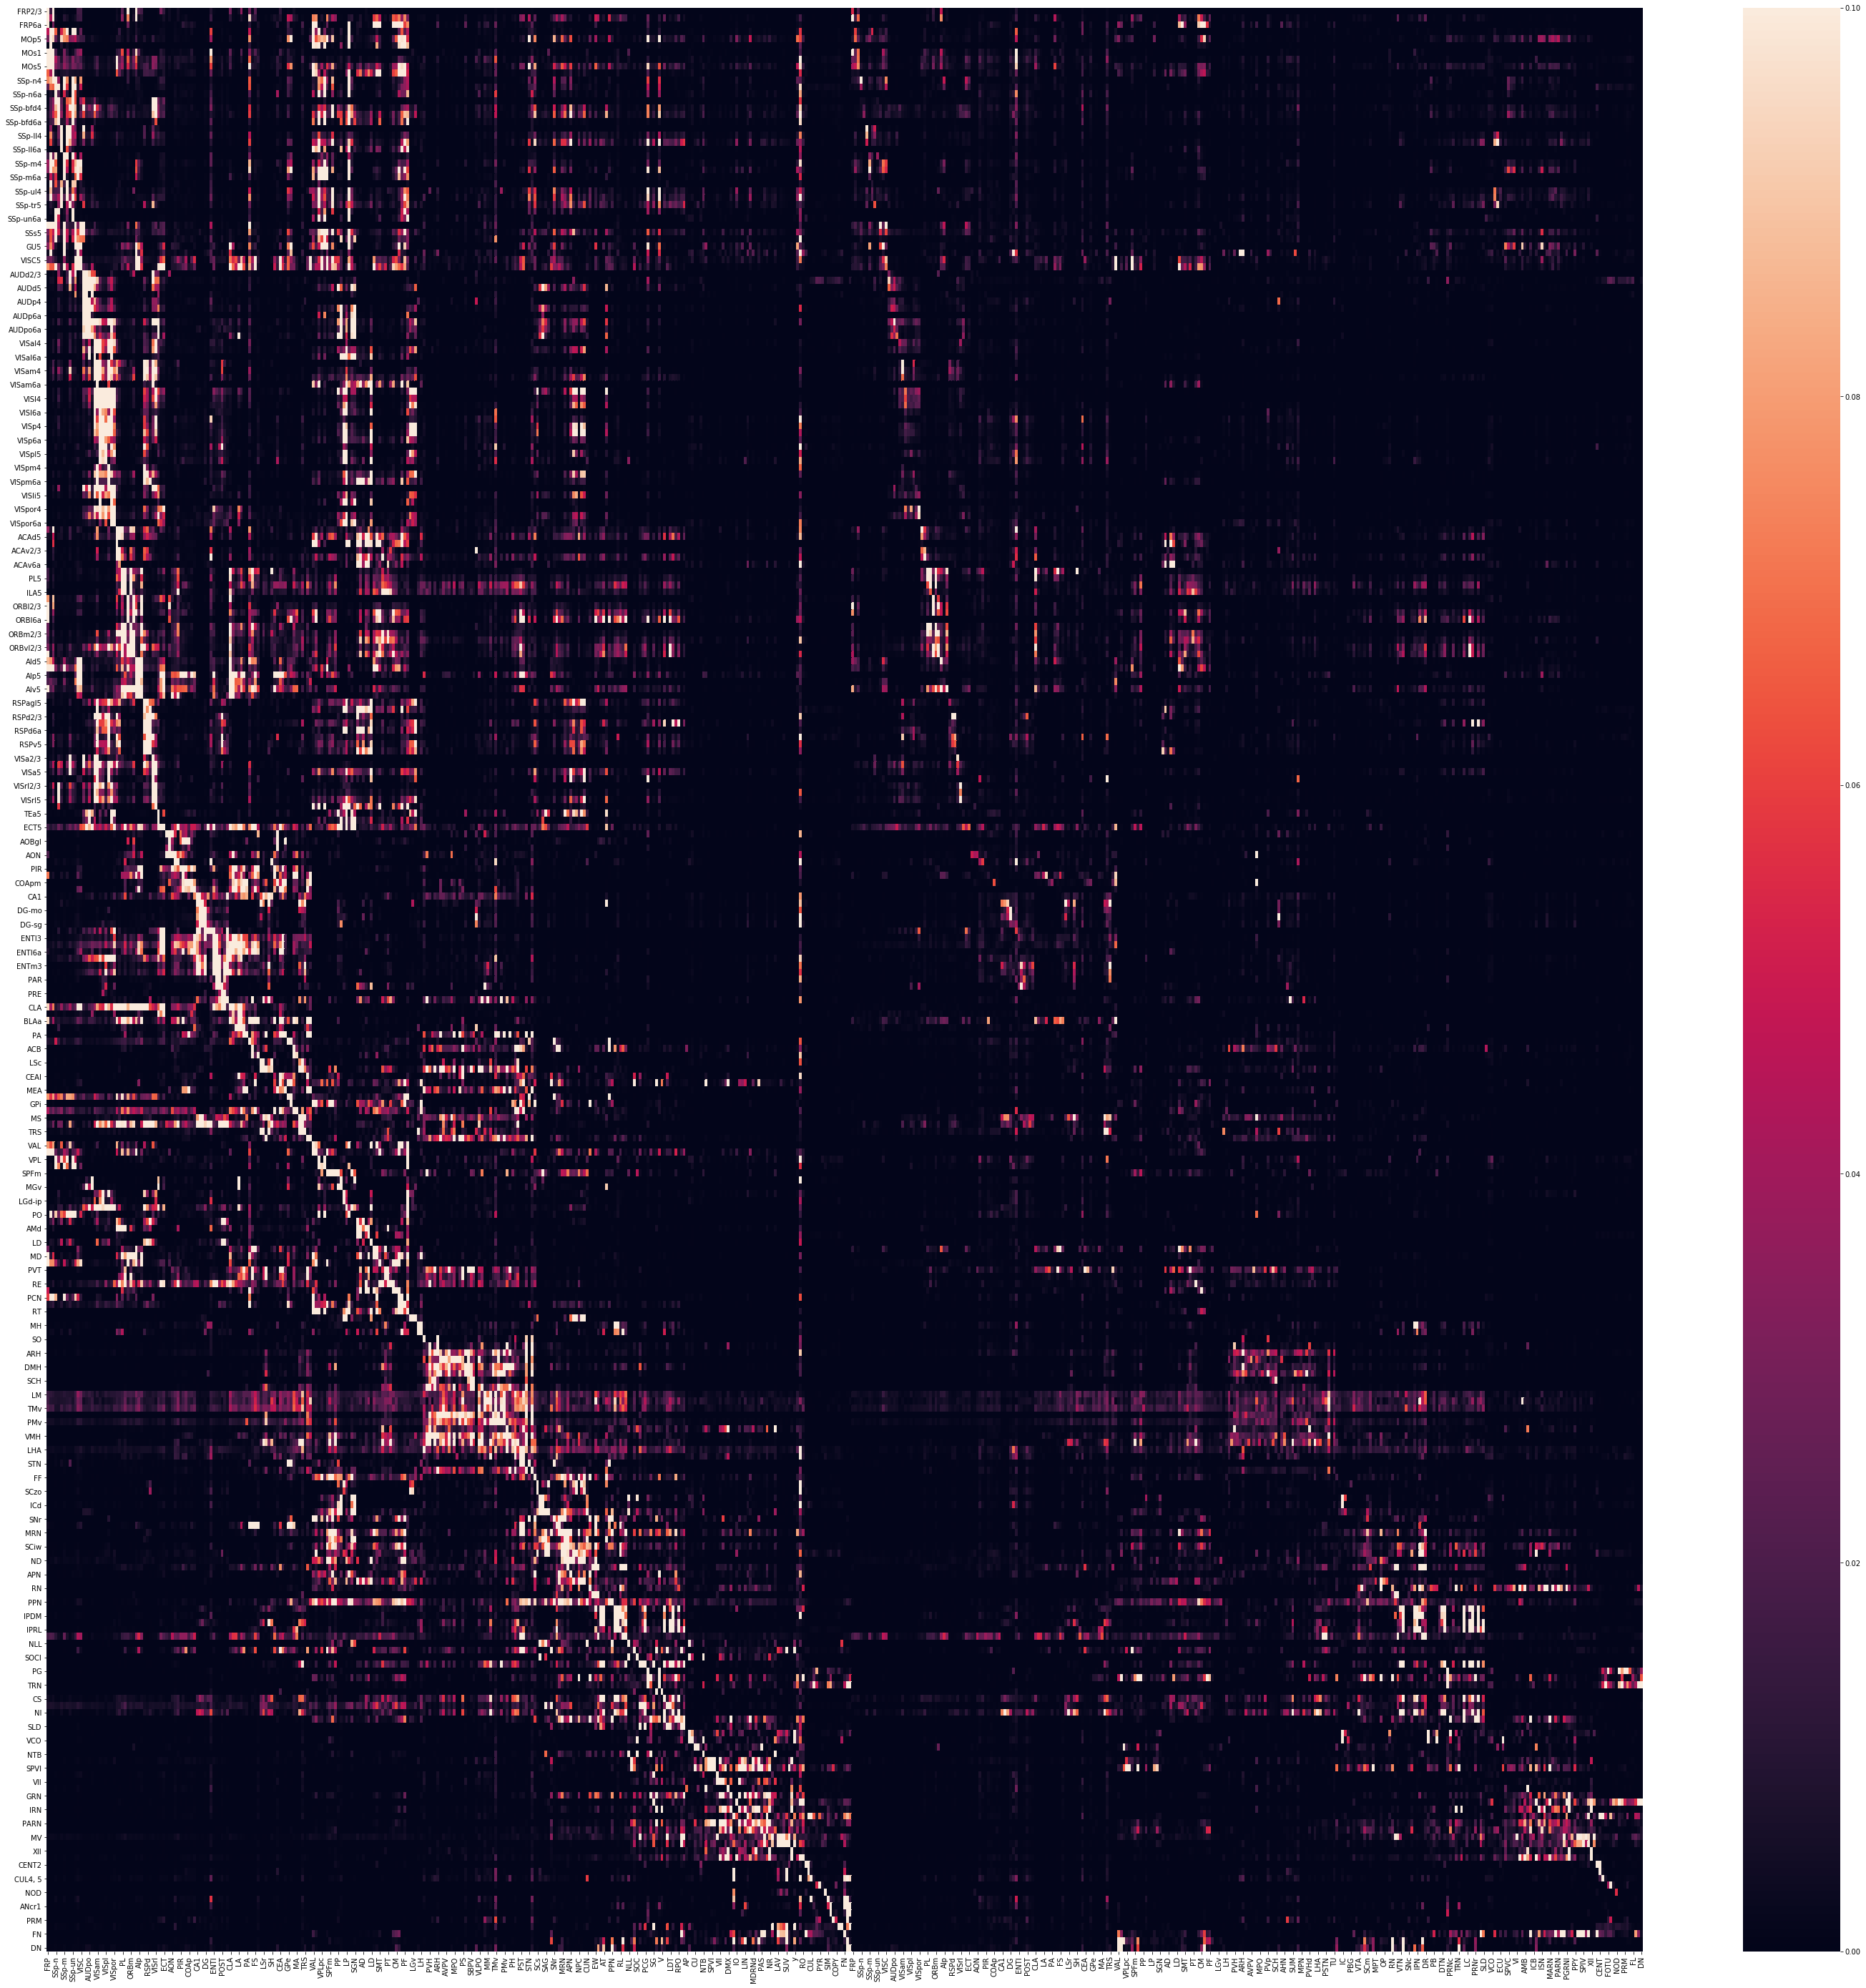

In [12]:
fig, ax = plt.subplots(0,figsize = (50,50))
sns.heatmap(df, vmax = 0.1, vmin=0.)

In [22]:
# data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
# data_info.set_index("id", inplace=True)
# ontological_order = get_ordered_summary_structures(cache)

# exps = np.asarray(data_info.index.values , dtype = np.int)
# creline = {}
# for sid in major_structure_ids:
#     msvd = msvds[sid]
#     experiment_ids = np.asarray(list(msvd.experiments.keys()))
#     nexp = len(experiment_ids)
#     creline[sid] = np.zeros(nexp, dtype = object)
#     for i in range(len(experiment_ids)):
#         index = np.where(exps == experiment_ids[i])[0][0]
#         creline[sid][i] = data_info['transgenic-line'].iloc[index]
        
# experiments_minor_structures = {}
# for sid in major_structure_ids:
#     msvd = msvds[sid]
#     eids = np.asarray(list(msvd.experiments.keys()))
#     experiments_minor_structures[sid] = get_minorstructures(eids, data_info)

In [24]:
# key = list(msvd.experiments.keys())[0]
# contra_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
# ipsi_key = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

# cre = None
# l2losses = {}
# paperlosses = {}
# normspredict = {}
# normtrue = {}
# for sid in major_structure_ids:
#     #print()
#     msvd = msvds[sid]
#     nexp = msvd.projections.shape[0]
#     ngam = 1
    
#     l2losses[sid] = np.zeros((ngam,nexp))
#     paperlosses[sid] = np.zeros((ngam,nexp))
#     normspredict[sid] = np.zeros((ngam,nexp))
#     normtrue[sid] = np.zeros(nexp)

#     minor_structures = np.unique(experiments_minor_structures[sid])
#     nmins = len(minor_structures)
    
#     projections = msvd.projections
#     ipsi_proj = unionize(projections, ipsi_key)
#     contra_proj = unionize(projections, contra_key)
#     reg_proj = np.hstack([ipsi_proj, contra_proj])
#     msvd.reg_proj = reg_proj
    
#     ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_key, return_counts=True)
#     contra_target_regions, contra_target_counts = nonzero_unique(contra_key, return_counts=True)
#     target_counts = np.concatenate([ipsi_target_counts, contra_target_counts])
#     reg_proj_vcount_norm = np.divide(reg_proj, target_counts[np.newaxis, :])
#     msvd.reg_proj_vcount_norm = reg_proj_vcount_norm

#     source_mask = Mask.from_cache(cache, structure_ids=[sid], hemisphere_id=2)
#     source_key = source_mask.get_key(structure_ids=ontological_order)  
#     source_target_counts, source_target_counts =nonzero_unique(source_key, return_counts=True)
    
#     injections = msvd.injections
#     reg_ipsi_inj = unionize(injections, source_key)
#     msvd.reg_inj = reg_ipsi_inj  
#     reg_inj_vcount_norm = np.divide(reg_ipsi_inj, source_target_counts[np.newaxis, :])
#     msvd.reg_inj_vcount_norm = reg_inj_vcount_norm

In [50]:
msvd.reg_proj_vcount_norm.shape

(83, 577)

In [25]:
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
#gammas = np.asarray([0.1,.5,1,2,10])


In [26]:
gammas = np.asarray([0.1,.5,1,2,10])

In [27]:
nms = len(major_structure_ids)
ngam = len(gammas)
wt_2ormore = {}
losses_reg_norm = np.zeros((nms,ngam))
for m in range(12):
    sid = major_structure_ids[m]
    projections = msvds[sid].reg_proj_vcount_norm
    projections = projections / np.expand_dims(np.linalg.norm(projections, axis = 1),1)
    msvds[sid].reg_proj_vcount_norm_renorm = projections
    centroids = msvds[sid].centroids
    nreg = projections.shape[1]
    nexp = projections.shape[0]
    
    nfeat = projections.shape[1]
    #ncomps = np.append(np.asarray(np.linspace(1, nfeat / 10, 5), dtype = int),nfeat - 1)
    #nalpha = len(alphas)
    
    #msvds[sid].loocv_predictions_all = np.zeros((ngam, len(ncomps),nalpha, nexp, nreg))
    #msvds[sid].loocv_predictions_wt = np.zeros((ngam, len(ncomps),nalpha, nexp, nreg))
    msvds[sid].loocv_predictions_wt = np.zeros((ngam, nexp, nreg))
    msvds[sid].loocv_predictions_all = np.zeros((ngam, nexp, nreg))
    wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
    wt_2ormore[sid] = np.asarray([])
    
    
    for g in range(ngam):
        print(g,'g')
        #for c in range(len(ncomps)):
#            print(c,'c')
            #for a in range(nalpha):
#                print(a,'a')
#         losses_reg_norm[m,g] = get_loss_paper(projections[wt_inds], loocv_predictions[wt_inds])
        msvds[sid].loocv_predictions_all[g] = get_loocv_predictions(projections, centroids, gammas[g])
        if len(wt_inds) > 1:
            msvds[sid].loocv_predictions_wt[g, wt_inds] = get_loocv_predictions(projections[wt_inds], centroids[wt_inds], gammas[g])
            if g == 0:
                wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
    wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)

0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

1 g
2 g
3 g
4 g


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalida

0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g
0 g
1 g
2 g
3 g
4 g


/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: divide by zero encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()
/Users/samsonkoelle/alleninstitute/sambranch/mouse_connectivity_models/mcmodels/models/crossvalidation.py:14: RuntimeWarning: invalid value encountered in true_divide
  weights_i = weights[i] / weights[i][otherindices].sum()


In [47]:
exps = np.asarray(data_info.index.values , dtype = np.int)
creline = {}
for sid in major_structure_ids:
    msvd = msvds[sid]
    experiment_ids = np.asarray(list(msvd.experiments.keys()))
    nexp = len(experiment_ids)
    creline[sid] = np.zeros(nexp, dtype = object)
    for i in range(len(experiment_ids)):
        index = np.where(exps == experiment_ids[i])[0][0]
        creline[sid][i] = data_info['transgenic-line'].iloc[index]

#inds_bad are where there is no injection
#we can use these to train but shouldnt to evaluate
#the 'wt_ind' should just be 'eval_ind'
inds_bad = {}
inds_good = {}
for sid in major_structure_ids:
    injections = msvds[sid].injections 
    inds_bad[sid] = np.where(injections.sum(axis = 1) == 0.)[0]
    inds_good[sid] = np.where(injections.sum(axis = 1) > 0.)[0]
    
nms = len(major_structure_ids)
#ngam = len(gammas)
wt_2ormore = {}
losses_reg_norm = np.zeros((nms,ngam))
inds_good_wt = {}
inds_good_wtsub = {}
for m in range(nms):
    sid = major_structure_ids[m]
    wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
    wt_2ormore[sid] = np.asarray([])
    #wt_2ormore is the indices of when there are 2 or more wild types
    if len(wt_inds) > 1:
        wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
    wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)
    inds_good_wt[sid] = np.intersect1d(wt_2ormore[sid], inds_good[sid])
    inds_good_wtsub[sid] = np.where(np.isin(wt_2ormore[sid], inds_good[sid]))[0]

In [33]:
    
def get_loss(true_dict, prediction_dict,pred_ind = None, true_ind = None, keys = None):
    
    output = {}
    major_structure_ids = list(prediction_dict.keys())
    nms = len(major_structure_ids)
    ngam = prediction_dict[major_structure_ids[0]].shape[0]
    nalph = prediction_dict[major_structure_ids[0]].shape[1]
    for m in range(nms):
        sid = major_structure_ids[m]
        if pred_ind == None:
            #prediction_dict and true_dict will contain predictions for 'bad' experiments with no recorded injection
            #when we have the wild type predictions, the subset is what is good among the wild types
            #so 'true' subsetting is always good, since it is w.r.t. the full injection
            #but prediction needs good w.r.t. wt
            pind = np.asarray(list(range(prediction_dict[sid].shape[1])), dtype = int)
        else:
            pind = pred_ind[sid]
        if true_ind == None:
            tind = np.asarray(list(range(true_dict[sid].shape[0])), dtype = int)
        else:
            tind = true_ind[sid]
        
        nexp = len(pind)
        
        output[sid] = np.zeros(np.append([len(np.unique(keys[:,i])) for i in range(keys.shape[1])], nexp))

        for j in range(keys.shape[0]):
            output[sid][tuple(keys[j])] = np.asarray([get_loss_paper(true_dict[sid][tind[i]], prediction_dict[sid][tuple(keys[j])][pind[i]]) for i in range(nexp)]) 
                
    return(output)

In [34]:
homo_loocv_predictions_all = {}
homo_loocv_predictions_wt = {}
homo_reg_proj_vcount_norm_renorms= {}
for sid in major_structure_ids:
    homo_loocv_predictions_all[sid ] = msvds[sid].loocv_predictions_all
    homo_loocv_predictions_wt[sid ] = msvds[sid].loocv_predictions_wt
    homo_reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm

In [35]:
exps = np.asarray(data_info.index.values , dtype = np.int)
creline = {}
for sid in major_structure_ids:
    msvd = msvds[sid]
    experiment_ids = np.asarray(list(msvd.experiments.keys()))
    nexp = len(experiment_ids)
    creline[sid] = np.zeros(nexp, dtype = object)
    for i in range(len(experiment_ids)):
        index = np.where(exps == experiment_ids[i])[0][0]
        creline[sid][i] = data_info['transgenic-line'].iloc[index]

#inds_bad are where there is no injection
#we can use these to train but shouldnt to evaluate
#the 'wt_ind' should just be 'eval_ind'
inds_bad = {}
inds_good = {}
for sid in major_structure_ids:
    injections = msvds[sid].injections 
    inds_bad[sid] = np.where(injections.sum(axis = 1) == 0.)[0]
    inds_good[sid] = np.where(injections.sum(axis = 1) > 0.)[0]
    
nms = len(major_structure_ids)
#ngam = len(gammas)
wt_2ormore = {}
losses_reg_norm = np.zeros((nms,ngam))
inds_good_wt = {}
inds_good_wtsub = {}
for m in range(nms):
    sid = major_structure_ids[m]
    wt_inds = np.where(creline[sid] == 'C57BL/6J')[0]
    wt_2ormore[sid] = np.asarray([])
    #wt_2ormore is the indices of when there are 2 or more wild types
    if len(wt_inds) > 1:
        wt_2ormore[sid] = np.append(wt_2ormore[sid],wt_inds)
    wt_2ormore[sid] = np.asarray(wt_2ormore[sid], dtype = int)
    inds_good_wt[sid] = np.intersect1d(wt_2ormore[sid], inds_good[sid])
    inds_good_wtsub[sid] = np.where(np.isin(wt_2ormore[sid], inds_good[sid]))[0]

In [36]:
import itertools
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))

In [37]:
losses_all = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = inds_good, true_ind = inds_good,keys = keys)
losses_wts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_wt,pred_ind = inds_good_wtsub, true_ind = inds_good_wt, keys = keys)
losses_allwts = get_loss(homo_reg_proj_vcount_norm_renorms, homo_loocv_predictions_all,pred_ind = inds_good_wt, true_ind = inds_good_wt, keys = keys)

In [39]:
def get_gamma(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.zeros((nms,nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        output[m] = keys[np.nanargmin(lvec)]
        #if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))
    
    output = np.asarray(output, dtype = int)
    return(output)


In [40]:
import itertools
a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))
sel_ga_all = get_gamma(losses_all,keys)
sel_ga_allwt = sel_ga_all#get_gamma(losses_allwt,keys)
#sel_ga_wt = get_gamma(losses_wts,keys)

0
1
2
3
4
5
6
7
8
9
10
11


In [41]:
def get_ms_loss(losses, gammas):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    output = np.zeros(nms)
    for m in range(nms):
        sid = major_structure_ids[m]
        output[m] = np.nanmean(losses[sid][gammas[m],:])
    return(output)


In [42]:
mean_nw_all = get_ms_loss(losses_all, sel_ga_all)
mean_nw_allwt = get_ms_loss(losses_allwts, sel_ga_all)
#mean_nw_wt = get_ms_loss(losses_all, sel_ga_wt)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [43]:
mean_nw_all

array([0.90097783, 0.77737892, 0.35946378, 0.29377341, 0.43029092,
       0.47135974, 0.40976477, 0.44626504, 0.45657043, 0.53027727,
       0.69085557, 0.42870434])

In [44]:
mean_nw_allwt

array([1.20922247,        nan, 0.26124218, 0.26865134, 0.28385839,
       0.26417285, 0.39617524, 0.2177794 , 0.57632538, 0.50071204,
       0.48259818, 0.34852249])

In [46]:
losses2 = np.asarray(mean_nw_allwt[[4,7,2,1,10,9,11,3,5,8,6,0]])

In [47]:
losses2

array([0.28385839, 0.2177794 , 0.26124218,        nan, 0.48259818,
       0.50071204, 0.34852249, 0.26865134, 0.26417285, 0.57632538,
       0.39617524, 1.20922247])

In [52]:
len(ipsi_target_regions)

291